# Sistema de recomendación de comidas y establecimientos según restaurant deseado

## Modelamiento y evaluación con machine learning

### 1. Objetivos:
Fortalecer la imagen de marca ayudando al usuario a seleccionar adecuadamente el establecimiento deseado y ofreciéndole nuevas opciones de restaurant que podrían encantarle. Para lograr esto, proponemos los siguiente: 
* Implementar un modelo de clasificación con aprendizaje supervisado basado en un algoritmo de similitud de coseno. 
* Recomendar los mejores tres restaurantes según el algoritmo.

**Se desplegarán los siguientes endpoints:**
   1. Endpoint 1: 
      1. Función: Recomendar un restaurante basado en una palabra clave, con la posibilidad de establecer filtros según las preferencias del usuario. Los filtros disponibles serán: nombre del restaurante, tipo de cocina, calificación del negocio, ciudad y código postal.
      2. Método: Filtro de contenido. 
      3. Texto para el usuario: Ingrese una palabra clave y complete los filtros según sus preferencias.
   2. Endpoint 2: 
      1. Función: Recomendar restaurantes basándose en las reseñas que ha escrito el usuario en cuestión.
      2. Método: Filtro de contenido
      3. Texto para el usuario: restaurant que te podrían gustar en base a tus experiencias.
   3. Endpoint 3: 
      1. Función: Recomendar restaurantes basándose en las calificaciones del usuario en cuestión.
      2. Método: Filtro colaborativo.
      3. Texto para el usuario: restaurant que te podrían gustar en base a tus calificaciones positivas.
   4. Endpoint 4: 
      1. Función: Recomendar el restaurante que más le gustó al usuario, considerando sus experiencias y calificaciones.
      2. Método: Filtro híbrido.
      3. Texto para el usuario: el restaurant que más te gustó.
   5. Endpoint 5: 
      1. Función: Recomendar restaurant utilizando un híbrido entre los endpoints 2, 3, 4
      2. Método: Filtro híbrido.
      3. Texto para el usuario: comidas que te podrian gustar siguiendo un balance entre tus experiencias previas, calificaciones previas y restaurant mejor calificados.

### 2. Consideraciones:
1. Se procederá a probar los tiempos de ejecución con distintas variables, primero numéricas, y luego se agregarán las categóricas. Se buscará que el algortimo cuando sea deployado se demote 1 segundo.
2. Se optar por empezar a trabajar con las siguientes variables.
3. Luego de realizar el MVP con las variables dle punto 2, se procedera a probar nuevas variables y se hará un feature importance.

### 3. Importación de libreria:

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ndcg_score
from sklearn.metrics import ndcg_score
from sklearn.model_selection import KFold
import random 
import seaborn as sns
import matplotlib.pyplot as plt

### 4. Carga y visualización del DataFrame

In [4]:
df_business = pd.read_csv('business.CSV')
df_business_categories = pd.read_csv('business_categories.CSV')
df_categories = pd.read_csv('categories.CSV')
df_cities = pd.read_csv('cities.CSV')
df_states = pd.read_csv('states.CSV')
df_users = pd.read_csv('users.CSV')
df_reviews = pd.read_csv('reviews.CSV', delimiter=';')

### 5. Eliminar la columna Unnamed e inspección de valores faltantes

#### business

##### Eliminar columna Unnamed

In [6]:
df_business = df_business.drop(columns=['Unnamed: 0'])

print("DataFrame sin la columna 'Unnamed: 0':")
df_business


DataFrame sin la columna 'Unnamed: 0':


,id,name,id_city,latitude,longitude,stars,review_count
0,0x89c6c89efcaed69d:0xded973f6033e7dba,Vivi Bubble Tea,1,39.940293,-75.150923,4.0,8
1,0x89c6c9d5df403af7:0xa304c9f7a08ac8e3,Pete's Place,1,39.941969,-75.152634,4.8,97
2,0x89c6c78eab0a32b9:0xfc6173640d850f40,Sushi and Poke,1,39.943259,-75.163745,4.8,88
3,0x89c6c9c34b867061:0x2be61cc879fba19c,MANDALAY BOWL,1,39.942285,-75.153238,4.6,8
4,0x89c6c94228976445:0x2fe5791d10782c1,Taco & Ramen,1,39.942243,-75.152919,5.0,28
...,...,...,...,...,...,...,...
71979,0x89e841c0ef4cdcbf:0x3c96cc2a146c1032,Taco Island Tex-Mex,4309,40.930552,-73.032639,4.6,198
71980,0x88d9223977b3a6c9:0x20a7235371d8e904,Big Bubba’s Que,2255,26.497351,-80.206095,4.1,24
71981,0x88c2eb6db3540ba1:0xf28c1bea1954ff2e,NABRUZZI TRATTORIA,2256,28.069683,-82.629875,4.6,17
71982,0x88e60d5b8a76c313:0x57561dcf135a5146,Subway,2257,29.732373,-81.882460,3.7,24


##### Inspección de valores faltantes

In [7]:
business_missing_values = df_business.isnull().sum()

print("Valores faltantes por columna:")
print(business_missing_values)

print("\n¿Hay valores faltantes en el DataFrame?")
print(df_business.isnull().any().any())


Valores faltantes por columna:
id              0
name            1
id_city         0
latitude        0
longitude       0
stars           0
review_count    0
dtype: int64

¿Hay valores faltantes en el DataFrame?
True


In [8]:
business_row_missings = df_business[df_business.isnull().any(axis=1)]

print("Filas con valores faltantes:")

business_row_missings

Filas con valores faltantes:


,id,name,id_city,latitude,longitude,stars,review_count
41610,0x89cb5acaef2bc841:0x6a442b3e9368c108,NaN,245,40.613114,-79.175641,3.2,13


##### Eliminar filas con valores faltantes

In [9]:
df_business = df_business.dropna()

print("\n¿Hay valores faltantes en el DataFrame?")
print(df_business.isnull().any().any())


¿Hay valores faltantes en el DataFrame?
False


#### business_categories

##### Eliminar columna Unnamed

In [10]:
df_business_categories = df_business_categories.drop(columns=['Unnamed: 0'])

print("DataFrame sin la columna 'Unnamed: 0':")
df_business_categories

DataFrame sin la columna 'Unnamed: 0':


,id_business,id_category,id
0,0x89c6c89efcaed69d:0xded973f6033e7dba,1,1
1,0x88db4147b1d9e6f3:0x943dbd10a92ba1b1,1,2
2,0x88c2e4e34f1ed783:0x76c5da381c499d79,2,3
3,0x8856a9a821ba2781:0xed82f944a300f3b5,1,4
4,0x8890b9241e704667:0x3a1e565c17c00993,1,5
...,...,...,...
188327,0x89c81997ab131515:0xee746ac21887fe01,1,188328
188328,0x89c81bdd8ae87749:0xd0c17064d8560660,14,188329
188329,0x89d31f176b64da79:0x202faca0f650e880,45,188330
188330,0x89d373386b718fff:0xf82c90ef48e7b23,45,188331


##### Inspección de valores faltantes

In [11]:
# Obtener las filas que contienen valores faltantes
business_categories_row_missings = df_business_categories[df_business_categories.isnull().any(axis=1)]

# Imprimir las filas con valores faltantes
print("Filas con valores faltantes:")

business_categories_row_missings

Filas con valores faltantes:


,id_business,id_category,id


#### categories

##### Eliminar columna Unnamed

In [12]:
df_categories = df_categories.drop(columns=['Unnamed: 0'])

print("DataFrame sin la columna 'Unnamed: 0':")

df_categories

DataFrame sin la columna 'Unnamed: 0':


,category_name,id
0,Restaurant,1
1,Buffet restaurant,2
2,Coffee shop,3
3,Bagel shop,4
4,Bakery,5
...,...,...
1227,Bridal shop,1228
1228,Formal wear store,1229
1229,Disco club,1230
1230,Mutton barbecue restaurant,1231


##### Inspección de valores faltantes

In [13]:
# Obtener las filas que contienen valores faltantes
categories_row_missings = df_categories[df_categories.isnull().any(axis=1)]

# Imprimir las filas con valores faltantes
print("Filas con valores faltantes:")

categories_row_missings

Filas con valores faltantes:


,category_name,id


#### cities

##### Eliminar columna Unnamed

In [14]:
df_cities = df_cities.drop(columns=['Unnamed: 0'])

print("DataFrame sin la columna 'Unnamed: 0':")

df_cities

DataFrame sin la columna 'Unnamed: 0':


,city_name,postal_code,id,id_state
0,Philadelphia,19147,1,1
1,Lewisburg,17837,2,1
2,Bloomsburg,17815,3,1
3,Erie,16507,4,1
4,Richboro,18954,5,1
...,...,...,...,...
7398,Snow Hill,21863,7399,10
7399,Towson,21252,7400,10
7400,Sunderland,20689,7401,10
7401,Kitzmiller,21538,7402,10


##### Inspección de valores faltantes

In [15]:
# Obtener las filas que contienen valores faltantes
cities_row_missings = df_cities[df_cities.isnull().any(axis=1)]

# Imprimir las filas con valores faltantes
print("Filas con valores faltantes:")

cities_row_missings

Filas con valores faltantes:


,city_name,postal_code,id,id_state


#### reviews

##### Eliminar columna Unnamed

In [16]:
df_reviews = df_reviews.drop(columns=['Unnamed: 0'])

print("DataFrame sin la columna 'Unnamed: 0':")

df_reviews

DataFrame sin la columna 'Unnamed: 0':


,id_user,id_business,rating,text,date,id
0,1,0x8894b5a7a7909725:0xe4687299fd288188,5,The salads were lackluster though with well wr...,2018-09-17 14:51:08.022,1
1,2,0x8894b5a7a7909725:0xe4687299fd288188,1,"Love this place. Great little restaurant, with...",2018-09-20 00:12:47.631,2
2,3,0x8894b5a7a7909725:0xe4687299fd288188,5,A classy restaurant to match the charm of the ...,2018-08-22 11:13:16.392,3
3,4,0x8894b5a7a7909725:0xe4687299fd288188,5,Great atmosphere and good food,2019-04-17 01:25:32.274,4
4,5,0x8894b5a7a7909725:0xe4687299fd288188,5,Good food,2019-05-20 22:42:50.993,5
...,...,...,...,...,...,...
2459704,1412628,0x884d69bfbc74c06d:0x7c606b655fc10508,5,Just GREAT,2018-09-08 17:07:58.851,2459705
2459705,1412629,0x884d69bfbc74c06d:0x7c606b655fc10508,5,NaN,2021-05-24 10:01:01.212,2459706
2459706,1412630,0x884d69bfbc74c06d:0x7c606b655fc10508,5,NaN,2020-11-07 01:15:26.076,2459707
2459707,1412631,0x884d69bfbc74c06d:0x7c606b655fc10508,3,NaN,2021-04-23 23:59:17.890,2459708


##### Inspección de valores faltantes

In [17]:
reviews_row_missings = df_reviews[df_reviews.isnull().any(axis=1)]

print("Filas con valores faltantes:")

reviews_row_missings

Filas con valores faltantes:


,id_user,id_business,rating,text,date,id
6,7,0x8894b5a7a7909725:0xe4687299fd288188,5,NaN,2018-11-03 12:51:14.150,7
7,8,0x8894b5a7a7909725:0xe4687299fd288188,5,NaN,2017-09-17 00:35:45.661,8
8,9,0x8894b5a7a7909725:0xe4687299fd288188,5,NaN,2018-08-07 19:24:53.762,9
10,10993,0x88f5a178d51075bd:0x85daa2b989c538c,5,NaN,2018-06-26 02:26:08.731,11
12,198333,0x88f5a178d51075bd:0x85daa2b989c538c,5,NaN,2018-02-20 02:38:47.128,13
...,...,...,...,...,...,...
2459694,1405769,0x884d69bfbc74c06d:0x7c606b655fc10508,5,NaN,2021-03-05 01:36:21.865,2459695
2459705,1412629,0x884d69bfbc74c06d:0x7c606b655fc10508,5,NaN,2021-05-24 10:01:01.212,2459706
2459706,1412630,0x884d69bfbc74c06d:0x7c606b655fc10508,5,NaN,2020-11-07 01:15:26.076,2459707
2459707,1412631,0x884d69bfbc74c06d:0x7c606b655fc10508,3,NaN,2021-04-23 23:59:17.890,2459708


#### states

##### Eliminar columna Unnamed

In [18]:
df_states = df_states.drop(columns=['Unnamed: 0'])

print("DataFrame sin la columna 'Unnamed: 0':")

df_states

DataFrame sin la columna 'Unnamed: 0':


,state_name,id
0,PA,1
1,FL,2
2,NC,3
3,NY,4
4,TN,5
5,GA,6
6,MA,7
7,VA,8
8,NJ,9
9,MD,10


##### Inspección de valores faltantes

In [19]:
states_row_missings = df_states[df_states.isnull().any(axis=1)]

print("Filas con valores faltantes:")

states_row_missings

Filas con valores faltantes:


,state_name,id


#### users

##### Eliminar columna Unnamed

In [20]:
df_users = df_users.drop(columns=['Unnamed: 0'])

print("DataFrame sin la columna 'Unnamed: 0':")

df_users

DataFrame sin la columna 'Unnamed: 0':


,user_id,name,id
0,113068308323231430437,Edwin Ashurst,1
1,105941553219163737304,Douglas Gummere,2
2,109857700811373231502,David Powell,3
3,114737748503783343160,Hillary Hutchins,4
4,108987048547659250890,Ajay patel,5
...,...,...,...
1436038,115487679005444715242,Jeffrey Breeding,1436039
1436039,111740453816858283227,Samantha Cundiff,1436040
1436040,105600206248577537335,C C H,1436041
1436041,100808371633227262143,McDeadBeef,1436042


##### Inspección de valores faltantes

In [21]:
users_row_missings = df_users[df_users.isnull().any(axis=1)]

print("Filas con valores faltantes:")

users_row_missings

Filas con valores faltantes:


,user_id,name,id
270597,103188255914786533115,NaN,270598
486781,105761284279650262995,NaN,486782
499595,104360487323198393944,NaN,499596
977341,113927981581295338213,NaN,977342
1352599,114348252857440273515,NaN,1352600
1401450,114499425790063428974,NaN,1401451


### 6. Transformaciones: escalado de atributos

#### 6.1. business

In [22]:
df_business.head(1)

,id,name,id_city,latitude,longitude,stars,review_count
0,0x89c6c89efcaed69d:0xded973f6033e7dba,Vivi Bubble Tea,1,39.940293,-75.150923,4.0,8


Se decide escalar solo el atributo review_count, la cual tiene un distribución sesgada hacia la derecha, y muchos valores atípicos. Por lo cual, se decidirá realizar el escalado co RobustScaler

In [23]:
# Escalar la columna review_count utilizando RobustScaler
review_count_scaler = RobustScaler()
df_business['review_count_scaled'] = review_count_scaler.fit_transform(df_business[['review_count']])

# Imprimir el DataFrame resultante
print("DataFrame con review_count escalada utilizando RobustScaler:")

df_business.head(1)


DataFrame con review_count escalada utilizando RobustScaler:


C:\Users\Josue\AppData\Local\Temp\ipykernel_6548\3043283164.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_business['review_count_scaled'] = review_count_scaler.fit_transform(df_business[['review_count']])


,id,name,id_city,latitude,longitude,stars,review_count,review_count_scaled
0,0x89c6c89efcaed69d:0xded973f6033e7dba,Vivi Bubble Tea,1,39.940293,-75.150923,4.0,8,-0.441176


In [24]:
# Imprimir los mínimos y máximos del review_count escalado
print('máximo', df_business['review_count_scaled'].max())
print('minimo', df_business['review_count_scaled'].min())

máximo 77.69117647058823
minimo -0.5441176470588235


### 7. Filtrado

#### Reconstrucción de la tabla categories

El filtro de contenido será basado en la tabla categories. Seran filtradas las categorias que tengan el nombre de Restaurant y además, sean para almorzar o cenar. A continuación, se reconstruye la tabla agregando las siguientes columnas:
* cuisine
* region
* dishes
* description (una combinacion de los anteriores. Se itera como combinarla a fin de que la métrica NDCG de el mejor resultado.)

#### Alternativas para el motor de búsqueda

In [25]:
# Lista de datos, donde cada lista interna representa una fila
data = [ 
    [10, 'Modern French Restaurant', 'Mediterranean Cuisine', 'West-Europe', 'Foie gras with seasonal fruits and balsamic reduction.', 'Reinterpreted ratatouille with modern cooking techniques.', 'Duck breast with beet puree and red wine sauce.', 'Tuna tartare with avocado and citrus emulsion.', 'Apple tarte Tatin with vanilla ice cream.', 'Chocolate mousse with sea salt and olive oil.'],
    [14, 'Pizza Resturant', 'Italian Mediterranean Cuisine', 'South-Europe', 'Margherita pizza with fresh mozzarella, basil, and tomatoes.', 'Pepperoni pizza with spicy pepperoni slices and melted cheese.', 'Quattro Stagioni pizza with artichokes, ham, mushroom, and olive.', 'Prosciutto and arugula pizza with shaved Parmesan and balsamic glaze.', 'Calzone stuffed with ricotta, mozzarella, and spinach.', 'Tiramisu for dessert.'],
    [15, 'Mexican Restaurant', 'Mesoamerican Spanish Cuisine', 'Latin-America', 'Taco al pastor with pineapple and onion.', 'Enchilada with mole poblano, served with rice and beans.', 'Fresh guacamole with tortilla chips.', 'Red pozole with lettuce, radishe, and lime.', 'Chile en nogada filled with picadillo and covered with walnut sauce.', 'Cajeta flan for dessert.'],
    [16, 'Family Restaurant', 'American Cuisine', 'Family Friendly Casual', 'Cheeseburger with fries and a drink.', 'Chicken tenders with honey mustard dipping sauce.', 'Macaroni and cheese.', 'Grilled cheese sandwiches with tomato soup.', 'Pancake with syrup and fresh fruit.', 'Ice cream sundae for dessert.'],
    [17, 'American Restaurant', 'Regional-American Cuisine', 'North-America', 'Cheeseburger with fries.', 'New York strip steak with mashed potatoes and gravy.', 'Barbecue ribs with coleslaw and cornbread.', 'Clam chowder in a bread bowl.', 'Caesar salad with grilled chicken.', 'Apple pie with vanilla ice cream.'],
    [20, 'Italian Restaurant', 'Mediterranean Cuisine', 'South-Europe', 'Margherita pizza with fresh mozzarella, tomatoes, and basil.', 'Spaghetti carbonara with pancetta and creamy egg sauce.', 'Lasagna with layers of pasta, meat sauce, and cheese.', 'Osso buco with saffron risotto.', 'Caprese salad with tomatoes, mozzarella, and basil.', 'Tiramisu for dessert.'],
    [22, 'Creole Restaurant', 'Southern-American Cuisine', 'North-America', 'Chicken and sausage gumbo with rice.', 'Shrimp étouffée with a rich roux-based sauce.', 'Jambalaya with a mix of chicken, sausage, and shrimp.', 'Crawfish po-boy sandwich with remoulade sauce.', 'Red beans and rice with Andouille sausage.', 'Bread pudding with whiskey sauce for dessert.'],
    [23, 'Caribbean Restaurant', 'African Spanish French Indian Cuisine', 'Caribbean', 'Jerk chicken with rice and peas.', 'Curry goat with steamed rice.', 'Ackee and saltfish with fried dumpling.', 'Fried plantain with a side of mango salsa.', 'Callaloo soup with coconut milk and crab.', 'Rum cake for dessert.'],
    [25, 'Soul Food Restaurant', 'Southern-American Cuisine', 'North-America', 'Fried chicken with collard green and cornbread.', 'Smothered pork chop with gravy and mashed potato.', 'Black-eyed pea with ham hock.', 'Macaroni and cheese with a crispy breadcrumb topping.', 'Sweet potato pie with a dollop of whipped cream.', 'Peach cobbler for dessert.'],
    [27, 'Health Food Restaurant', 'Plant-Based Organic Healthy Cuisine', 'North-America', 'Quinoa salad with avocado, cherry tomato, and lemon vinaigrette.', 'Avocado toast with a sprinkle of chia seed and microgreens.', 'Smoothie bowl with acai, banana, and granola.', 'Grilled salmon with steamed broccoli and brown rice.', 'Veggie wrap with hummus, spinach, and red pepper.', 'Almond flour brownie for dessert.'],
    [31, 'Cheesesteak Restaurant', 'American Street-Food Fast-Casual Cuisine', 'North-America', 'Classic cheesesteak with thinly sliced beef, melted cheese, and sautéed onion.', 'Chicken cheesesteak with grilled chicken, melted cheese, and bell pepper.', 'Veggie cheesesteak with mushrooms, onions, bell pepper, and melted cheese.', 'Cheesesteak hoagie with lettuce, tomato, and mayonnaise.', 'Fries with a side of cheese sauce.', 'Milkshake for dessert.'],
    [33, 'Jamaican Restaurant', 'African Spanish British Indian Cuisine', 'Caribbean', 'Jerk chicken with rice and pea.', 'Curried goat with steamed rice.', 'Ackee with saltfish and fried dumpling.', 'Escovitch fish with bammy (cassava flatbread).', 'Callaloo with saltfish and boiled green banana.', 'Rum cake for dessert.'],
    [35, 'Vegan Restaurant', 'Plant-Based Organic Healthy Cuisine', 'North-America', 'Vegan burger with sweet potato fries.', 'Quinoa bowl with avocado, chickpea, and tahini dressing.', 'Cashew cheese pizza with arugula and cherry tomato.', 'Lentil soup with kale and carrot.', 'Vegan sushi roll with avocado, cucumber, and carrot.', 'Coconut milk ice cream for dessert.'],
    [37, 'Kosher Restaurant', 'Israeli Jewish Cuisine', 'Middle-East', 'Matzo ball soup with chicken broth.', 'Gefilte fish with horseradish.', 'Brisket with potato kugel.', 'Falafel with tahini sauce.', 'Challah bread with honey.', 'Rugelach for dessert.'],
    [38, 'Vegetarian Restaurant', 'Plant-Based Organic Healthy Cuisine', 'North-America', 'Veggie burger with sweet potato fries.', 'Quinoa bowl with avocado, chickpea, and tahini dressing.', 'Stuffed pepper with rice, black beans, and corn.', 'Lentil soup with kale and carrot.', 'Caprese salad with tomato, mozzarella, and basil (using plant-based cheese).', 'Chocolate avocado mousse for dessert.'],
    [39, 'Chicken Restaurant', 'American Fast-Casual Cuisine', 'North-America', 'Fried chicken with mashed potato and gravy.', 'Grilled chicken breast with steamed broccoli.', 'Chicken tender with honey mustard sauce.', 'Buffalo chicken wing with celery and blue cheese dressing.', 'Chicken Caesar salad with romaine lettuce and Parmesan.', 'Lemon pepper chicken with rice.'],
    [44, 'Seafood Restaurant', 'Coastal International Cuisine', 'North-America', 'Grilled salmon with lemon butter sauce.', 'Shrimp scampi with garlic and white wine sauce.', 'Lobster bisque with a touch of cream.', 'Crab cake with remoulade sauce.', 'Clam chowder with bacon and potatoes.', 'Fish taco with cabbage slaw and lime crema.'],
    [45, 'Chinese Restaurant', 'Regional-Chinese Asian Cuisine', 'East-Asia', 'Dumpling filled with pork and cabbage.', 'Peking duck with hoisin sauce and scallion pancake.', 'Kung pao chicken with peanuts and chili pepper.', 'Hot and sour soup with tofu and mushroom.', 'Sweet and sour pork with pineapple and bell pepper.', 'Red beans bun for dessert.'],
    [46, 'Guatemalan Restaurant', 'Mayan Spanish African Cuisine', 'Central-America', 'Pepián with chicken, vegetable, and a rich, spiced sauce.', 'Tamal with masa, meat filling, and wrapped in banana leaf.', 'Jocon with chicken in a green sauce made from tomatillo and cilantro.', "Kak'ik with turkey in a spicy, red broth.", 'Pache with mashed potato and pork, wrapped in banana leaf.', 'Rellenito for dessert, made with plantain and black beans.'],
    [47, 'Peruvian Restaurant', 'Indigenous Spanish Chinese Japanese Cuisine', 'South-America', 'Ceviche with fresh fish marinated in lime juice, served with red onion and cilantro.', 'Lomo saltado with beef, tomato, and onion, served with rice and potato.', 'Aji de gallina with shredded chicken in a creamy, spicy sauce.', 'Anticucho with marinated beef heart skewer.', 'Papa a la huancaína with boiled potato and spicy cheese sauce.', 'Picarón for dessert, made with pumpkin and sweet potato, drizzled with syrup.'],
    [51, 'Fusion Restaurant', 'Multi-Cultural Experimental Cuisine', 'Global', 'Sushi burrito with tuna, avocado, and cucumber.', 'Kimchi taco with spicy pork and pickled vegetable.', 'Miso-glazed black cod with bok choy and jasmine rice.', 'Tandoori chicken pizza with naan crust and cilantro yogurt sauce.', 'Beef bulgogi slider with kimchi slaw.', 'Matcha tiramisu for dessert.'],
    [52, 'Middle Estearn Restaurant', 'Mediterranean Levantine Persian Middle-Eastern Cuisine', 'Middle-East', 'Falafel with tahini sauce.', 'Shawarma with lamb or chicken, served with pita bread.', 'Hummus with olive oil and paprika.', 'Baba ghanoush with roasted eggplant and garlic.', 'Kibbeh with minced meat and bulgur wheat.', 'Baklava for dessert, made with layer of filo pastry, nut, and honey.'],
    [53, 'Turkish Restaurant', 'Middle-Eastern Ottoman Mediterranean Cuisine', 'Middle-East', 'Doner kebab with lamb or chicken, served with rice and salad.', 'Meze platter with hummus, baba ghanoush, and dolma.', 'Lahmacun, a Turkish flatbread with minced meat and spice.', 'Manti, Turkish dumpling with yogurt and garlic sauce.', 'Imam bayildi, stuffed eggplant with tomato and onion.', 'Baklava for dessert, made with layer of filo pastry, nut, and syrup.'],
    [54, 'Vietnamese Restaurant', 'Asian French Cuisine', 'South-East-Asia', 'Pho with beef or chicken, served with fresh herb and rice noodle.', 'Banh mi with pork, pickled vegetable, and cilantro.', 'Fresh spring roll with shrimp, vermicelli, and peanut sauce.', 'Bun cha with grilled pork and vermicelli.', 'Goi cuon with shrimp and pork, served with hoisin dipping sauce.', 'Che for dessert, made with sweetened coconut milk and various beans.'],
    [61, 'Japanese Restaurant', 'Asian Seafood Cuisine', 'East-Asia', 'Sushi with tuna, salmon, and cucumber roll.', 'Ramen with pork, soft-boiled egg, and miso broth.', 'Tempura with shrimp and vegetable.', 'Sashimi with fresh slices of raw fish.', 'Udon noodle with beef and scallion.', 'Mochi for dessert, made with sweet rice cake and red beans paste.'],
    [62, 'Indian Restaurant', 'Regional-Indian Mughlai Street-Food Cuisine', 'South-Asia', 'Biryani with basmati rice, saffron, and marinated meat.', 'Samosa with potato and pea filling.', 'Butter chicken with creamy tomato sauce.', 'Palak paneer with spinach and Indian cheese.', 'Naan bread with garlic and cilantro.', 'Gulab jamun for dessert, made with milk solids and syrup.'],
    [75, 'Cajun Restaurant', 'Southern-American Creole French Cuisine', 'North-America', 'Gumbo with shrimp, sausage, and okra.', 'Jambalaya with chicken, andouille sausage, and rice.', 'Crawfish étouffée with crawfish and rich, spiced sauce.', 'Boudin sausage with rice and pork filling.', 'Red beans and rice with smoked sausage.', 'Beignet for dessert, dusted with powdered sugar.'],
    [76, 'Chicken Wings Restaurant', 'American Fast-Casual Cuisine', 'North-America', 'Buffalo wing with spicy sauce.', 'Honey mustard wing with tangy glaze.', 'Barbecue wing with smoky sauce.', 'Teriyaki wing with sweet and savory sauce.', 'Lemon pepper wing with zesty seasoning.', 'Garlic parmesan wing with buttery cheese coating.'],
    [80, 'Hamburger Restaurant', 'American Fast-Casual Cuisine', 'North-America', 'Classic burger with lettuce, tomato, and onion.', 'Cheeseburger with cheddar cheese and pickle.', 'Bacon burger with crispy bacon and barbecue sauce.', 'Veggie burger with black beans patty and avocado.', 'Swiss mushroom burger with sautéed mushroom and Swiss cheese.', 'Milkshake for dessert, available in flavors like vanilla, chocolate, and strawberry.'],
    [82, 'Asian Fusion Restaurant', 'Multi-Cultural Experimental', 'Asia', 'Sushi burrito with tuna, avocado, and cucumber.', 'Korean taco with spicy pork and pickled vegetable.', 'Miso-glazed black cod with bok choy and jasmine rice.', 'Tandoori chicken bao with naan and cilantro yogurt sauce.', 'Beef bulgogi slider with kimchi slaw.', 'Matcha tiramisu for dessert.'],
    [83, 'Asian Restaurant', 'Eastern-Asian Southeastern-Asian Southern-Asian Cuisine', 'Asia', 'Sushi with tuna, salmon, and avocado roll.', 'Pad thai with shrimp, tofu, and rice noodle.', 'Dim sum with pork bun and dumpling.', 'Pho with beef, fresh herb, and rice noodle.', 'Korean BBQ with marinated beef and vegetable.', 'Mango sticky rice for dessert, made with sweet coconut milk and ripe mango.'],
    [84, 'Pho Restaurant', 'Traditional-Vietnamese Street-Food Cuisine', 'South-East-Asia', 'Beef pho with thinly sliced beef, rice noodle, and fresh herbs.', 'Chicken pho with tender chicken, rice noodle, and aromatic broth.', 'Vegetarian pho with tofu, mushroom, and vegetable broth.', 'Fresh spring roll with shrimp and peanut sauce.', 'Banh mi with pork, pickled vegetable, and cilantro.', 'Che for dessert, made with sweetened coconut milk and various beans.'],
    [86, 'Sushi Restaurant', 'Japanese Seafood Asian Cuisine', 'East-Asia', 'Nigiri with tuna, salmon, or eel.', 'Sashimi with fresh slices of raw fish.', 'Maki roll with cucumber, avocado, and crab.', 'Temaki hand roll with spicy tuna.', 'Chirashi bowl with assorted sashimi over sushi rice.', 'Mochi for dessert, made with sweet rice cake and red beans paste.'],
    [92, 'Tex-Mex Restaurant', 'Southern-American Mexican Texan Cuisine', 'North-America', 'Beef taco with lettuce, cheese, and salsa.', 'Cheese enchilada with red sauce.', 'Chicken fajita with bell pepper and onion.', 'Nacho with melted cheese, jalapeño, and guacamole.', 'Quesadilla with chicken and cheese.', 'Churro for dessert, dusted with cinnamon and sugar.'],
    [94, 'Mediterranean Restaurant', 'Greek Italian Spanish Turkish Cuisine', 'South-Europe', 'Gyro with lamb, tzatziki sauce, and pita bread.', 'Paella with seafood, saffron rice, and vegetable.', 'Caprese salad with tomato, mozzarella, and basil.', 'Moussaka with eggplant, ground meat, and béchamel sauce.', 'Falafel with chickpea, herb, and tahini sauce.', 'Baklava for dessert, made with layer of filo pastry, nut, and honey.'],
    [95, 'Thai Restaurant', 'Southeastern-Asian Street-Food Cuisine', 'South-East-Asia', 'Pad thai with shrimp, rice noodle, and peanut.', 'Green curry with chicken, bamboo shoot, and coconut milk.', 'Tom yum soup with shrimp, mushroom, and lemongrass.', 'Som tum with green papaya, peanut, and chili.', 'Massaman curry with beef, potato, and cashew nut.', 'Mango sticky rice for dessert, made with sweet coconut milk and ripe mango.'],
    [97, 'African Restaurant', 'Western-African Eastern-African Northern-African Southern-African', 'Africa', 'Jollof rice with tomato, pepper, and chicken.', 'Injera with doro wat (Ethiopian chicken stew).', 'Tagine with lamb, apricot, and almond.', 'Bobotie with spiced minced meat and egg topping.', 'Ugali with sukuma wiki (collard greens).', 'Malva pudding for dessert, made with apricot jam and served with custard.'],
    [98, 'West African Restaurant', 'Nigerian Ghanaian Senegalese Cuisine', 'West-Africa', 'Jollof rice with tomato, pepper, and chicken.', 'Suya with spicy grilled beef skewer.', 'Egusi soup with melon seed, spinach, and goat meat.', 'Fufu with pounded cassava or yam, served with soup or stew.', 'Akara with black-eyed pea fritter.', 'Puff-puff for dessert, made with deep-fried dough and sugar.'],
    [106, 'Eclectic Restaurant', 'Multi-Cultural Experimental Cuisine', 'Global', 'Truffle mac and cheese with gourmet cheeses and truffle oil.' 'Korean BBQ pizza with marinated beef and kimchi.', 'Vegan sushi with avocado, cucumber, and mango.', 'Moroccan-spiced lamb burger with tzatziki sauce.', 'Beet and goat cheese salad with candied walnut.', 'Matcha tiramisu for dessert.'],
    [110, 'German Restaurant', 'Central-European Alpine Cuisine', 'West-Europe', 'Bratwurst with mustard and sauerkraut.', 'Schnitzel with breaded pork or veal, served with potato salad.', 'Sauerkraut with fermented cabbage.', 'Pretzel with coarse salt and mustard.', 'Kartoffelsalat with potato, bacon, and vinegar dressing.', 'Black Forest cake for dessert, made with chocolate, cherries, and whipped cream.'],
    [111, 'European restaurant', 'European Cuisine', 'Europe', 'Beef Bourguignon', 'Seafood paella', 'Osso buco', "Duck à l'Orange", 'Schnitzel', 'Tiramisu'],
    [112, 'Latin American Restaurant', 'Central-American Southern-American Caribbean Cuisine', 'Latin-America', 'Empanada with beef or chicken filling.', 'Arepa with cheese or avocado.', 'Feijoada with black beans and pork stew.', 'Ceviche with fresh fish marinated in lime juice.', 'Churrasco with grilled beef and chimichurri sauce.', 'Tres leches cake for dessert, made with sponge cake soaked in three types of milk.'],
    [113, 'Barbecue Restaurant', 'Southern-American Regional-American Cuisine', 'North-America', 'Pulled pork with tangy barbecue sauce.', 'Beef brisket with smoky flavor and tender texture.', 'Barbecue rib with sweet and smoky sauce.', 'Smoked sausage with spicy seasoning.', 'Coleslaw with cabbage and creamy dressing.', 'Pecan pie for dessert, made with rich, sweet filling and flaky crust.'],
    [114, 'Hunan Restaurant', 'Regional-Chinese Chinese Cuisine', 'East-Asia', 'Hot and spicy chicken with chili peppers and garlic.', 'Steamed fish head with diced hot red pepper.', "Mao's braised pork with soy sauce and spices.", 'Stir-fried green beans with garlic and chili.', "Dong'an chicken with vinegar and ginger.", 'Glutinous rice cake for dessert.'],
    [118, 'Halal Restaurant', 'Middle-Eastern Southern-Asian Northern-African', 'Global', 'Lamb kebab with grilled lamb and spices.', 'Chicken biryani with basmati rice and aromatic spice.', 'Falafel with chickpea, herbs, and tahini sauce.', 'Beef shawarma with marinated beef and pita bread.', 'Hummus with chickpea and olive oil.', 'Baklava for dessert, made with layer of filo pastry, nut, and honey'],
    [121, 'Puerto Rican Restaurant', 'Spanish African Cuisine', 'Caribbean', 'Mofongo with mashed plantain and garlic.', 'Arroz con gandules with pigeon peas and seasoned rice.', 'Lechón with roasted pork.', 'Tostones with fried green plantain.', 'Alcapurria with ground beef or crab filling.', 'Flan for dessert, made with caramel and creamy custard.'],
    [122, 'Nuevo Latino Restaurant', 'Global Culinary Trends Modern Cuisine', 'Latin-America', 'Ceviche with fresh fish, citrus juices, and avocado.', 'Pork belly taco with pickled onion and cilantro.', 'Quinoa salad with black beans, corn, and lime dressing.', 'Grilled octopus with chimichurri sauce.', 'Arepa with pulled pork and mango salsa.', 'Dulce de leche flan for dessert.'],
    [123, 'Salvadoran Restaurant', 'Central-American Indigenous Spanish Cuisine', 'Central-America', 'Pupusa with cheese, pork, or beans filling.', 'Yuca frita with fried cassava root and curtido.', 'Carne asada with grilled beef and chimol salsa.', 'Sopa de res with beef soup and vegetable.', 'Tamal de elote with sweet corn dough.', 'Tres leches cake for dessert, made with sponge cake soaked in three types of milk.'],
    [124, 'Organic Restaurant', 'Health-Conscious Farm-To-Table Movement Healthy Cuisine', 'Global', 'Organic kale salad with avocado, quinoa, and lemon vinaigrette.', 'Grass-fed beef burger with whole wheat bun and organic cheddar cheese.', 'Free-range chicken roast with rosemary and garlic.', 'Grilled wild-caught salmon with organic asparagus.', 'Organic vegetable stir-fry with tofu and brown rice.', 'Organic berry parfait for dessert, made with Greek yogurt and honey.'],
    [125, 'Ramen Restaurant', 'Japanese Noodle Street-Food Cuisine', 'East-Asia', 'Tonkotsu ramen with rich pork broth, chashu pork, and soft-boiled egg.', 'Shoyu ramen with soy sauce-based broth, bamboo shoot, and nori.', 'Miso ramen with miso-based broth, corn, and butter.', 'Spicy ramen with spicy broth, ground pork, and bok choy.', 'Shio ramen with clear, salty broth and seafood.', 'Matcha ice cream for dessert.'],
    [130, 'Korean Restaurant', 'Asian Fermented-Food Cuisines', 'East-Asia', 'Bulgogi with marinated beef and grilled vegetables.', 'Bibimbap with mixed rice, vegetables, and gochujang sauce.', 'Kimchi with fermented cabbage and chili paste.', 'Japchae with stir-fried glass noodle and vegetables.', 'Tteokbokki with spicy rice cake and fish cake.', 'Hotteok for dessert, made with sweet pancake filled with brown sugar and nuts.'],
    [131, 'Chinese Noodle Restaurant', 'Regional-Chinese Cuisine', 'East-Asia', 'Beef noodle soup with tender beef, bok choy, and wheat noodle.', 'Dan dan noodle with spicy sauce, ground pork, and scallion.', 'Chow mein with stir-fried noodle, vegetables, and soy sauce.', 'Wonton noodle soup with shrimp wonton and egg noodle.', 'Zha jiang mian with minced pork and beans paste sauce.', 'Sweet red beans soup for dessert.'],
    [132, 'Cold Noodle Restaurant', 'East-Asian Refreshing-Dish Cuisine', 'East-Asia', 'Naengmyeon with buckwheat noodle, sliced beef, and cold broth.', 'Soba noodle with cold dipping sauce, nori, and scallion.', 'Sesame noodle with peanut sauce and cucumber.', 'Japchae with sweet potato noodle and mixed vegetables.', 'Cold udon with dipping sauce and tempura.', 'Mochi ice cream for dessert.'],
    [133, 'Dan Dan Noodle Restaurant', 'Sichuan Chinese Spicy-Dish Cuisine', 'East-Asia', 'Classic Dan Dan noodles with spicy sauce, minced pork, and scallion.', 'Dry Dan Dan noodles with sesame paste and pickled vegetables.', 'Sichuan cold noodles with shredded chicken and chili oil.', 'Spicy wontons with chili oil and garlic.', 'Mapo tofu with ground pork and spicy beans paste.', 'Sweet sticky rice balls for dessert.'],
    [135, 'Udon Noodle Restaurant', 'Japanese Comfort-Food Cusine', 'East-Asia', 'Kake udon with light dashi broth and scallion.', 'Tempura udon with crispy tempura shrimp and vegetables.', 'Kitsune udon with sweet fried tofu and nori.', 'Curry udon with savory curry broth and beef.', 'Nabeyaki udon with hot pot-style vegetables and egg.', 'Matcha mochi for dessert.'],
    [137, 'Cuban Restaurant', 'Caribbean Spanish African Cuisine', 'Caribbean', 'Ropa vieja with shredded beef in tomato sauce.', 'Tostones with fried green plantain.', 'Roasted pork with mojo sauce.', 'Chicken and yellow rice.', 'Boiled cassava with garlic sauce.', 'Flan for dessert, made with caramel and creamy custard.'],
    [139, 'Colombian Restaurant', 'Latin-American Indigenous Spanish Cuisine', 'South-America', 'Bandeja paisa with beans, rice, pork belly, sausage, plantain, avocado, and fried egg.', 'Arepa with cheese or avocado.', 'Sancocho with chicken, beef, plantain, and potato soup.', 'Ajiaco with chicken, three kinds of potatoes, and corn.', 'Empanada with beef or chicken filling.', 'Tres leches cake (pastel de tres leches) for dessert, made with sponge cake soaked in three types of milk'],
    [140, 'Taiwanese Restaurant', 'Chinese Street-Food Cuisine', 'East-Asia', 'Beef noodle soup with tender beef, wheat noodle, and savory broth.', 'Oyster omelette with fresh oyster, eggs, and starch.', 'Three-cup chicken with soy sauce, sesame oil, and basil.', 'Braised pork rice with minced pork and steamed rice.', 'Gua bao with pork belly and pickled mustard greens.', 'Pineapple cake (fènglísū) for dessert, made with pastry and pineapple filling.'],
    [144, 'Pakistani Restaurant', 'South-Asian Mughlai Cuisine', 'South-Asia', 'Biryani with basmati rice, chicken or lamb, and aromatic spices.', 'Nihari with slow-cooked beef or lamb in a rich, spicy gravy.', 'Chicken karahi with tomatoes, green chilies, and ginger.', 'Seekh kebab with spiced minced meat grilled on skewers.', 'Palak paneer with spinach and cottage cheese.', 'Gulab jamun for dessert, made with deep-fried dough balls in sugar syrup.'],
    [147, 'Mandarin Restaurant', 'Chinese Northern-Chinese Cuisine', 'East-Asia', 'Peking duck with crispy skin and hoisin sauce.', 'Jiaozi with pork or vegetable filling.', 'Zhajiangmian with minced pork and soybean paste.', 'Kung pao chicken with peanuts and chili peppers.', 'Hot and sour soup with tofu and bamboo shoots.', 'Tangyuan for dessert, made with glutinous rice balls and sweet filling.'],
    [148, 'Central American Restaurant', 'Indigenous Spanish Caribbean Cuisine', 'Central-America', 'Pupusa with cheese, pork, or beans filling.', 'Gallo pinto with rice and beans.', 'Tamal with corn dough and meat filling.', 'Sopa de mariscos (seafood soup) with fish, shrimp, and vegetables.', 'Carne asada with grilled beef and chimol (salad).', 'Tres leches cake (pastel de tres leches) for dessert, made with sponge cake soaked in three types of milk.'],
    [149, 'Ecuadorian Restaurant', 'Indigenous Spanish Coastal Cuisine', 'Sout-America', 'Ceviche with shrimp, lime juice, and red onion.', 'Llapingachos with potato patties and cheese.', 'Seco de chivo with goat stew and rice.', 'Encebollado with fish soup, yuca, and pickled onion.', 'Bolón de verde with mashed green plantain and cheese or pork.', 'Tres leches cake (pastel de tres leches) for dessert, made with sponge cake soaked in three types of milk.'],
    [160, 'Greek Restaurant', 'Mediterranean Middle-Eastern Cuisine', 'South-Europe', 'Moussaka with layers of eggplant, ground meat, and béchamel sauce.', 'Souvlaki with grilled meat skewers, often served with pita bread and tzatziki.', 'Spanakopita with phyllo pastry, spinach, and feta cheese.', 'Greek salad with tomatoes, cucumber, olives, and feta cheese.', 'Dolmades with grape leaves stuffed with rice and herbs.', 'Baklava for dessert, made with layers of phyllo pastry, nuts, and honey.'],
    [161, 'Fine Dining Restaurant', 'French Gourmet International Haute Cuisine', 'Global', 'Foie gras with fig compote and brioche.', 'Lobster bisque with brandy and cream.', 'Beef Wellington with puff pastry, mushroom duxelles, and prosciutto.', 'Seared scallops with lemon beurre blanc and asparagus.', 'Truffle risotto with Parmesan cheese and black truffle.', 'Crème brûlée for dessert, made with vanilla custard and caramelized sugar.'],
    [162, 'New American Restaurant', 'Fusion Modern-American Cuisine', 'North-America', 'Truffle burger with truffle aioli, arugula, and Gruyère cheese.', 'Grilled flatbread with prosciutto, arugula, and balsamic glaze.', 'Kale and quinoa salad with roasted sweet potatoes and avocado.', 'Seared tuna with sesame crust and wasabi aioli.', 'Pork belly sliders with pickled slaw and hoisin sauce.', 'Flourless chocolate cake for dessert, made with dark chocolate and raspberry coulis.'],
    [163, 'Hoagie Restaurant', 'American Sandwich Shops Deli Cuisine', 'North-America', 'Italian hoagie with ham, salami, provolone cheese, lettuce, tomato, and Italian dressing.', 'Turkey hoagie with roasted turkey, Swiss cheese, lettuce, tomato, and mayonnaise.', 'Veggie hoagie with avocado, roasted peppers, cucumber, lettuce, and hummus.', 'Roast beef hoagie with cheddar cheese, red onion, lettuce, and horseradish sauce.', 'Chicken Parmesan hoagie with breaded chicken, marinara sauce, and mozzarella cheese.', 'Chocolate chip cookie for dessert, made with dark chocolate chunks.'],
    [164, 'Taco Restaurant', 'Mexican Street-Food Traditional-Mexican Cuisine', 'Latin-America', 'Carne asada taco with grilled beef, cilantro, and onion.', 'Al pastor taco with marinated pork, pineapple, and salsa verde.', 'Fish taco with battered fish, cabbage slaw, and lime crema.', 'Chicken tinga taco with shredded chicken, chipotle sauce, and queso fresco.', 'Carnitas taco with braised pork, pickled onions, and avocado.', 'Churro for dessert, made with fried dough and cinnamon sugar.'],
    [166, 'Honduran Restaurant', 'Indigenous Spanish Caribbean Cuisine', 'Central-America', 'Baleada with flour tortilla, refried beans, cheese, and crema.', 'Carne asada with grilled beef, chimol (tomato salsa), and plantain.', 'Sopa de caracol (conch soup) with coconut milk, yuca, and cilantro.', 'Pollo con tajadas with fried chicken, green plantain, and cabbage slaw.', 'Pupusa with cheese, pork, or beans filling.', 'Tres leches cake (pastel de tres leches) for dessert, made with sponge cake soaked in three types of milk.'],
    [169, 'Burrito Restaurant', 'Mexican Street-Food Traditional-Mexican Cuisine', 'Latin-America', 'Beef burrito with seasoned beef, rice, beans, cheese, and salsa.', 'Chicken burrito with grilled chicken, black beans, corn, and guacamole.', 'Veggie burrito with sautéed vegetables, rice, pinto beans, and pico de gallo.', 'Carnitas burrito with braised pork, rice, beans, and tomatillo salsa.', 'Shrimp burrito with grilled shrimp, avocado, cabbage slaw, and chipotle sauce.', 'Churro for dessert, made with fried dough and cinnamon sugar.'],
    [172, 'Small Plates Restaurant', 'Fusion Tapas Mediterranean Modern-American Cuisine', 'Global', 'Patatas bravas with crispy potatoes and spicy aioli.', 'Mini sliders with beef, cheddar cheese, and caramelized onions.', 'Bruschetta with tomato, basil, and balsamic glaze.', 'Seared scallops with lemon butter sauce and microgreens.', 'Truffle fries with Parmesan cheese and truffle oil.', 'Chocolate fondue for dessert, served with fruit and marshmallows.'],
    [176, 'Traditional American Restaurant', 'Regional-American Comfort-Food', 'North-America', 'Meatloaf with mashed potatoes and gravy.', 'Fried chicken with coleslaw and cornbread.', 'Cheeseburger with lettuce, tomato, and pickles.', 'Macaroni and cheese with cheddar and breadcrumbs.', 'Chicken pot pie with a flaky crust and creamy filling.', 'Apple pie for dessert, made with cinnamon-spiced apples and a buttery crust.'],
    [177, 'Delivery Chinese Restaurant', 'Traditional-Chinese American-Chinese Cuisine', 'East-Asia', "General Tso's chicken with crispy chicken and sweet-spicy sauce.", 'Beef with broccoli in a savory garlic sauce.', 'Kung pao chicken with peanuts and chili peppers.', 'Sweet and sour pork with pineapple and bell peppers.', 'Egg rolls with cabbage and pork filling.', 'Fortune cookies for a fun and sweet ending.'],
    [179, 'Hot Pot Restaurant', 'Chinese Asian Cuisine', 'East-Asia', 'Spicy Sichuan hot pot with chili and numbing peppercorn broth.', 'Assorted meat platter with beef, lamb, and pork slices.', 'Seafood platter with shrimp, fish fillets, and squid.', 'Vegetable platter with mushrooms, bok choy, and spinach.', 'Noodles and tofu as additional options for cooking in the broth.', 'Red beans soup for dessert, made with red beans and sweet syrup.'],
    [181, 'Mexican Torta Restaurant', 'Street-Food Traditional-Mexican Cuisine', 'Latin-America', 'Torta de milanesa with breaded beef, lettuce, tomato, avocado, and refried beans.', 'Torta de cochinita pibil with slow-roasted pork, pickled onions, and habanero salsa.', 'Torta ahogada with carnitas, refried beans, and spicy tomato sauce, served in a drenched roll.', 'Torta de jamón with ham, cheese, lettuce, tomato, and jalapeños.', 'Torta de pollo with grilled chicken, chipotle mayo, and avocado.', 'Flan for dessert, made with caramel and creamy custard.'],
    [183, 'Dominican Restaurant', 'Indigenous Spanish African Cuisine', 'Caribbean', 'Mangu with mashed plantains, onions, and fried cheese or salami.', 'Sancocho with mixed meat stew and root vegetables.', 'Mofongo with mashed plantains, garlic, and chicharrón (pork cracklings).', 'La bandera (The Flag) with rice, beans, and meat (typically chicken or beef).', 'Tostones with twice-fried plantains.','Tres leches cake (pastel de tres leches) for dessert, made with sponge cake soaked in three types of milk.'],
    [184, 'Gluten-Free Restaurant', 'Healthy Welness International Cuisine', 'Global', 'Gluten-free pasta with tomato basil sauce and Parmesan cheese.', 'Gluten-free pizza with a cauliflower crust, mozzarella, and fresh toppings.', 'Quinoa salad with roasted vegetables, feta cheese, and lemon vinaigrette.', 'Grilled chicken with a side of gluten-free grain pilaf and steamed broccoli.', 'Gluten-free brownies for dessert, made with almond flour and dark chocolate.', 'Fresh fruit parfait with yogurt and gluten-free granola.'],
    [185, 'Portuguese Restaurant', 'Mediterranean Atlantic Cuisine', 'South-Europe', 'Bacalhau à brás with shredded salted cod, onions, and potatoes bound with eggs.', 'Caldo verde with kale, potatoes, and chorizo sausage.', 'Arroz de marisco with rice and a variety of seafood.', 'Bifana with marinated pork cutlets in a sandwich roll.', 'Polvo à lagareiro with octopus, garlic, and olive oil.', 'Pastéis de nata for dessert, made with flaky pastry and custard filling.'],
    [192, 'Fish and Chips Restaurant', 'Traditional-British British Seafood Cuisine', 'West-Europe', 'Cod and chips with battered cod fillet and thick-cut chips.', 'Haddock and chips with lightly seasoned haddock and crispy chips.', 'Plaice and chips with tender plaice fillet and golden chips.', 'Mushy peas with mashed peas and mint.', 'Curry sauce or tartar sauce as popular condiments.', 'Sticky toffee pudding for dessert, made with dates and toffee sauce.'],
    [193, 'Filipino Restaurant', 'Indigenous Spanish Chinese Cuisine', 'South-East-Asia', 'Adobo with chicken or pork marinated in vinegar, soy sauce, garlic, and bay leaves.', 'Sinigang with tamarind-based soup, pork, and vegetables.', 'Lumpia with spring rolls filled with meat or vegetables.', 'Lechon with roasted pig and crispy skin.', 'Kare-kare with oxtail stew, peanut sauce, and vegetables.', 'Halo-halo for dessert, made with shaved ice, sweet beans, fruits, and leche flan.'],
    [195, 'Spanish Restaurant', 'Mediterranean Moorish Cuisine', 'South-Europea', 'Paella with rice, saffron, seafood, and chicken.', 'Tapas including patatas bravas, croquetas, and jamón ibérico.', 'Gazpacho with cold tomato soup, cucumbers, and bell peppers.', 'Tortilla española with eggs, potatoes, and onions.', 'Pimientos de padrón with fried green peppers and sea salt.', 'Churros with chocolate sauce for dessert, made with fried dough and rich chocolate.'],
    [199, 'Rice Restaurant', 'Asian Mediterranean Latin-American Cuisine', 'Global', 'Risotto with creamy Arborio rice, mushrooms, and Parmesan cheese.', 'Sushi rolls with vinegared rice, fresh fish, and vegetables.', 'Biryani with basmati rice, marinated meat, and aromatic spices.', 'Paella with saffron-infused rice, seafood, and chicken.', 'Fried rice with jasmine rice, vegetables, and soy sauce.', 'Rice pudding for dessert, made with rice, milk, and cinnamon.'],
    [201, 'Hot Dog Restaurant', 'American Street-Food Diner Cuisine', 'North-America', 'Classic hot dog with beef sausage, mustard, ketchup, and relish.', 'Chicago-style hot dog with beef sausage, mustard, onions, relish, tomato slices, pickles, sport peppers, and celery salt.', 'Chili cheese dog with beef sausage, chili, shredded cheese, and onions.', 'New York-style hot dog with beef sausage, sauerkraut, and spicy brown mustard.', 'Veggie dog with vegetarian sausage, lettuce, tomato, and avocado.', 'Soft serve ice cream for dessert, made with creamy vanilla.'],
    [204, 'Authentic Japanese Restaurant', 'Traditional-Japanese Modern-Japanese Cuisine', 'East-Asia', 'Sushi with vinegared rice, fresh fish, and vegetables.', 'Sashimi with thinly sliced raw fish, served with soy sauce and wasabi.', 'Ramen with wheat noodles, broth, pork, and green onions.', 'Tempura with lightly battered and fried seafood and vegetables.', 'Tonkatsu with breaded and fried pork cutlet, served with shredded cabbage.', 'Matcha ice cream for dessert, made with green tea powder.'],
    [205, 'Southern Restaurant (US)', 'Southern-American African European Native-American Cuisine', 'North-America', 'Fried chicken with crispy coating and juicy meat.', 'Collard greens slow-cooked with bacon or ham hocks.', 'Cornbread with a slightly sweet, crumbly texture.', 'Shrimp and grits with creamy grits and seasoned shrimp.', 'Jambalaya with rice, sausage, chicken, and shrimp in a flavorful sauce.', 'Pecan pie for dessert, made with pecans and a sweet, gooey filling.'],
    [206, 'Pancake Restaurant', 'Breakfast American Diner Comfort-Food Cuisine', 'North-America', 'Buttermilk pancake with butter and maple syrup.', 'Blueberry pancake with fresh blueberries and blueberry compote.', 'Chocolate chip pancake with chocolate chips and whipped cream.', 'Banana walnut pancake with sliced bananas and toasted walnuts.', 'Red velvet pancake with cream cheese glaze and powdered sugar.', 'Classic breakfast sides such as bacon, sausage, and scrambled eggs.'],
    [207, 'Jewish Restaurant', 'Israeli Eastern-European Mediterranean Cuisine', 'Middle-East', 'Matzo ball soup with chicken broth, matzo balls, and vegetables.', 'Latkes with crispy potato pancake, served with applesauce or sour cream.', 'Challah with braided bread, often enriched with eggs and honey.', 'Brisket with slow-cooked beef, often served with root vegetables.', 'Gefilte fish with poached fish patties, usually served with horseradish.', 'Rugelach for dessert, made with pastry dough and filled with fruit, nuts, or chocolate.'],
    [208, 'Teppanyaki Restaurant', 'Traditional-Japanese Japanese', 'East-Asia', 'Teppanyaki steak with tender beef, soy sauce, and garlic butter.', 'Grilled shrimp with fresh shrimp, lemon, and a touch of soy sauce.', 'Mixed vegetables with an assortment of grilled seasonal vegetables.', 'Fried rice with rice, eggs, vegetables, and soy sauce.', 'Hibachi chicken with chicken breast, teriyaki sauce, and sesame seeds.', 'Green tea ice cream for dessert, made with matcha green tea powder.'],
    [212, 'Malaysian Restaurant', 'Chinese Indian Cuisine', 'South-East-Asia', 'Nasi lemak with coconut rice, sambal, anchovies, peanuts, and boiled egg.', 'Laksa with spicy noodle soup, coconut milk, and seafood or chicken.', 'Satay with skewered and grilled meat, served with peanut sauce.', 'Roti canai with flaky flatbread, served with curry dipping sauce.', 'Beef rendang with slow-cooked beef in coconut milk and spices.', 'Kuih for dessert, made with rice flour and coconut milk, often colorful and sweet.'],
    [219, 'Soup Restaurant', 'International Comfor-Food Cuisine', 'Global', 'Chicken noodle soup with tender chicken, noodles, carrots, and celery.', 'Clam chowder with clams, potatoes, cream, and bacon.', 'Tom yum with spicy and sour broth, shrimp, mushrooms, and lemongrass.', 'French onion soup with caramelized onions, beef broth, and melted cheese on top.', 'Minestrone with mixed vegetables, beans, and pasta in a tomato-based broth.', 'Butternut squash soup for a creamy, flavorful option made with roasted butternut squash and spices.'],
    [221, 'Brazilian Restaurant', 'Indigenous Portuguese African Cuisine', 'South-America', 'Feijoada with black beans, pork, and beef, served with rice, collard greens, and orange slices.', 'Churrasco with assorted grilled meats, often served with farofa (toasted cassava flour) and vinaigrette.', 'Pão de queijo with cheese bread made from tapioca flour and cheese.', 'Moqueca with fish stew, coconut milk, tomatoes, and bell peppers.', 'Acarajé with black-eyed pea fritters, shrimp, and vatapá (spicy paste made from bread, shrimp, and coconut milk).', 'Brigadeiro for dessert, made with condensed milk, cocoa powder, and chocolate sprinkles.'],
    [223, 'Moroccan Restaurant', 'Berber Arab Mediterranean Cuisine', 'North-Africa', 'Tagine with slow-cooked meat (such as lamb or chicken), vegetables, and a blend of spices, often cooked in a traditional clay pot.', 'Couscous with steamed semolina, vegetables, and meat or fish, often served with a flavorful broth.', 'Pastilla with layered pastry filled with spiced meat (usually pigeon or chicken), almonds, and cinnamon, topped with powdered sugar.', 'Harira with hearty soup made from tomatoes, lentils, chickpeas, and spices, often eaten to break the fast during Ramadan.', 'Zaalouk with cooked eggplant and tomato salad, flavored with garlic, cumin, and paprika.', 'Msemen for dessert, a flaky Moroccan pancake often served with honey and butter.'],
    [225, 'Dance Restaurant', 'Fusion International Social-Dining Entertainment Cuisine', 'Global', 'Tapas with a selection of small plates such as patatas bravas, croquetas, and empanadas.', 'Grilled meats with options like steak, chicken, and seafood, served with sides.', 'Pasta dishes with fresh ingredients and flavorful sauces.', 'Desserts like chocolate fondue, cheesecake, and fruit platters.', 'Specialty cocktails and mocktails to complement the dining experience.'],
    [226, 'Southwestern Restaurant (US)', 'Mexican Southwestern-American Native-American Tex-Mex Cuisine', 'North-American', 'Enchiladas with corn tortillas, cheese, and red or green chili sauce.', 'Fajitas with grilled beef or chicken, bell peppers, onions, and warm tortillas.', 'Chili con carne with spicy meat stew, beans, and tomatoes.', 'Navajo tacos with fry bread, seasoned meat, beans, and toppings.', 'Quesadillas with melted cheese and optional fillings like chicken or vegetables.', 'Sopapillas for dessert, made with fried dough and served with honey.'],
    [228, 'Down Home Cooking Restaurant', 'Southern-American African European Native-American Comfort-Food Cuisine', 'North-America', 'Fried catfish with crispy coating and tender fish.', 'Chicken and dumplings with slow-cooked chicken and fluffy dumplings in a savory broth.', 'Cornbread with a slightly sweet, crumbly texture.', 'Collard greens slow-cooked with bacon or ham hocks.', 'Biscuits and gravy with flaky biscuits and creamy sausage gravy.', 'Peach cobbler for dessert, made with sweet peaches and a buttery crust.'],
    [229, 'Hawaiian Restaurant', 'Polynesian Asian American Cuisine', 'Oceania North-America', 'Poke with raw fish (such as ahi tuna) marinated in soy sauce, sesame oil, and green onions.', 'Kalua pig with slow-roasted pork, often cooked in an underground oven (imu).', 'Loco moco with rice, hamburger patty, fried egg, and brown gravy.', 'Spam musubi with grilled Spam, rice, and nori seaweed.', 'Haupia with coconut milk pudding, often served as a dessert.', 'Malasadas for a sweet treat, made with fried dough and sugar coating.'],
    [239, 'Lebanese Restaurant', 'Mediterranean Arab Cuisine', 'MiddleEast', 'Hummus with mashed chickpeas, tahini, lemon juice, and garlic.', 'Tabbouleh with parsley, bulgur, tomatoes, and lemon juice.', 'Shawarma with marinated meat (such as chicken, beef, or lamb), cooked on a vertical rotisserie, and served in pita bread with garlic sauce and pickles.', 'Kibbeh with ground meat (usually lamb or beef), bulgur, and spices, often fried or baked.', 'Falafel with deep-fried balls made from ground chickpeas or fava beans, herbs, and spices.', 'Baklava for dessert, made with layers of filo pastry, nuts, and honey syrup.'],
    [240, 'Southeast Asian Restaurant', 'Thai Vietnamese Malaysian Indonesian Filipino Cuisine', 'South-East-Asia', 'Pad Thai with stir-fried rice noodles, shrimp, tofu, peanuts, and tamarind sauce.', 'Pho with Vietnamese noodle soup, beef or chicken, and fresh herbs.', 'Satay with skewered and grilled meat, served with peanut sauce.', 'Nasi Goreng with Indonesian fried rice, chicken or shrimp, and a fried egg.', 'Green curry with Thai green curry paste, coconut milk, chicken, and vegetables.', 'Mango sticky rice for dessert, made with sweet sticky rice and ripe mango.'],
    [241, 'Dim Sum Restaurant', 'Chinese Cantonese Tea-House-Tradition', 'East-Asia', 'Har gow (shrimp dumplings) with translucent wrappers and succulent shrimp filling.', 'Siu mai (pork dumplings) with a mix of ground pork and shrimp, topped with fish roe.', 'Char siu bao (barbecue pork buns) with soft, fluffy dough and savory barbecue pork filling.', 'Spring rolls with crispy wrappers and a mix of vegetables or meat fillings.', 'Egg tarts with flaky pastry and sweet egg custard.', 'Mango pudding for dessert, made with fresh mango and a creamy texture.'],
    [243, 'Southern Italian Restaurant', 'Mediterranean Sicilian Neapolitan Cuisine', 'South-Europe', 'Pasta alla Norma with pasta, eggplant, tomatoes, ricotta salata, and basil.', 'Pizza Margherita with thin crust, fresh tomatoes, mozzarella, and basil.', 'Arancini with deep-fried rice balls filled with ragù, peas, and cheese.', 'Caponata with eggplant, tomatoes, olives, capers, and vinegar.', 'Cannoli with crispy pastry tubes filled with sweet ricotta cheese.', 'Tiramisu for dessert, made with layers of mascarpone, coffee-soaked ladyfingers, and cocoa powder.'],
    [246, 'Gyro Restaurant', 'Greek Middle-Eastern Mediterranean Cuisine', 'South-Europe', 'Chicken gyro with grilled chicken, tomatoes, onions, lettuce, and tzatziki sauce in a pita.', 'Lamb gyro with tender lamb, tomatoes, onions, lettuce, and tzatziki sauce in a pita.', 'Beef gyro with seasoned beef, tomatoes, onions, lettuce, and tzatziki sauce in a pita.', 'Souvlaki with skewered and grilled meat, served with pita bread and tzatziki sauce.', 'Greek salad with tomatoes, cucumbers, onions, olives, and feta cheese.', 'Baklava for dessert, made with layers of filo pastry, nuts, and honey syrup.'],
    [253, 'Polish Restaurant', 'Central-European Eastern-European', 'East-Europe', 'Pierogi with dumplings filled with potatoes, cheese, meat, or fruit, served with sour cream or butter.', 'Bigos with hearty stew made with sauerkraut, cabbage, various meats, and spices.', 'Kotlet schabowy with breaded and fried pork cutlet, served with mashed potatoes and cabbage salad.', 'Żurek with sour rye soup, sausage, and boiled eggs.', 'Gołąbki with cabbage rolls stuffed with rice, meat, and onions, served with tomato sauce.', 'Sernik for dessert, a traditional Polish cheesecake made with twaróg cheese.'],
    [254, 'Hong Kong Style Fast Food Restaurant', 'Cantonese Western Cuisine', 'East-Asia', 'Wonton noodles with egg noodles, shrimp or pork wontons, and clear broth.', 'Hong Kong-style milk tea with strong black tea and evaporated or condensed milk.', 'BBQ pork buns with fluffy steamed buns and savory barbecued pork filling.', 'Curry fish balls with fish balls cooked in a spicy curry sauce.', 'Egg tarts with flaky pastry and sweet egg custard filling.', 'Pineapple buns with soft, sweet buns and a crunchy topping, often served with a pat of butter.'],
    [256, 'Tapas Restaurant', 'Spanish Mediterranean Social-Dining Cuisine', 'South-Europe', 'Patatas bravas with crispy potatoes and spicy tomato sauce.', 'Gambas al ajillo with garlic shrimp cooked in olive oil.', 'Jamón ibérico with thinly sliced cured ham.', 'Tortilla española with eggs, potatoes, and onions.', 'Pimientos de padrón with fried green peppers and sea salt.', 'Churros with chocolate sauce for dessert, made with fried dough and rich chocolate.'],
    [258, 'Haitian Restaurant', 'African French Cuisine', 'Caribbean', 'Griot with fried marinated pork, often served with pikliz (spicy pickled vegetable relish).', 'Tassot with fried beef or goat, seasoned with herbs and spices.', "Joumou soup with pumpkin soup, beef, vegetables, and pasta, traditionally eaten on New Year's Day.", 'Diri kole with rice and red beans, flavored with coconut milk and spices.', 'Accra with fritters made from malanga (a root vegetable) or black-eyed peas.', 'Pain patate for dessert, made with sweet potato pudding, spices, and raisins.'],
    [259, 'Swedish Restaurant', 'Scandinavian Nordic Cuisine', 'North-Europe', 'Swedish meatballs with ground meat, onions, and spices, served with lingonberry sauce and mashed potatoes.', 'Gravlax with cured salmon, dill, and mustard sauce.', 'Smörgåsbord with a variety of cold and hot dishes, including pickled herring, cheeses, and cold cuts.', 'Janssons frestelse with potato casserole, anchovies, and onions.', 'Knäckebröd with crispbread, often served with butter and cheese.', 'Prinsesstårta for dessert, a layered cake with sponge, cream, jam, and green marzipan.'],
    [271, 'French Restaurant', 'Mediterranean Continental Cuisine', 'West-Europe', 'Coq au vin with chicken braised in red wine, mushrooms, and bacon.', 'Escargots with snails cooked in garlic butter and parsley.', 'Ratatouille with stewed vegetables like eggplant, zucchini, and bell peppers.', 'Bouillabaisse with fish stew, seafood, tomatoes, and saffron.', 'Bœuf bourguignon with beef stew, red wine, onions, and mushrooms.', 'Crème brûlée for dessert, made with creamy custard and caramelized sugar topping.'],
    [273, 'South Asian Restaurant', 'South-Asian Indian Pakistani Banglashi Sri Lankan Nepalese Cuisine', 'South-Asia', 'Biryani with fragrant rice, spices, and meat or vegetables.', 'Butter chicken with tender chicken cooked in a creamy tomato sauce.', 'Dal with lentil stew, seasoned with spices and herbs.', 'Samosas with deep-fried pastries filled with spiced potatoes, peas, and sometimes meat.', 'Tandoori chicken with chicken marinated in yogurt and spices, cooked in a tandoor oven.', 'Gulab jamun for dessert, made with deep-fried dough balls soaked in sugar syrup'],
    [279, 'Puebla Restaurant', 'Mexican Pueblan Indigenous Spanish Cuisine', 'Latin-America', 'Diverse menu with dishes such as mole poblano, chiles en nogada, and cemitas.', 'Use of high-quality, fresh ingredients, including vegetables, meats, seafood, and a variety of spices and herbs.', 'Variety of cooking methods, including grilling, frying, and slow-cooking.', 'Often feature traditional Mexican beverages like horchata, agua de jamaica, and pulque.', 'Positive reviews on Google Maps highlighting flavor, authenticity, and portion size.'],
    [280, 'Pan-Asian Restaurant', 'Japanese Thai Indian Korean Cuisine', 'Asia', 'Sushi with vinegared rice and various toppings like fish, vegetables, and seafood.', 'Pad Thai with stir-fried rice noodles, shrimp, tofu, peanuts, and tamarind sauce.', 'Green curry with Thai green curry paste, coconut milk, chicken, and vegetables.', 'Bibimbap with mixed rice, vegetables, beef, and gochujang (Korean chili paste).', 'Chicken tikka masala with marinated chicken in a creamy tomato sauce.', 'Mango sticky rice for dessert, made with sweet sticky rice and ripe mango.'],
    [281, 'Pozole Restaurant', 'Mexican Indegenous Spanish Cuisine', 'Latin-America', 'Pozole rojo with a rich, red broth made from dried chiles, hominy, and pork, garnished with radishes, cabbage, and lime.', 'Pozole blanco with a clear broth, hominy, and chicken or pork, garnished with onions, oregano, and lime.', 'Pozole verde with a green broth made from tomatillos and green chiles, hominy, and chicken, garnished with avocado, cilantro, and lime.', 'Tostadas with crispy tortillas topped with beans, lettuce, cheese, and salsa to accompany the pozole.', 'Sopes with thick corn cakes topped with various fillings like beans, meat, and cheese.', 'Buñuelos for dessert, made with crispy fried dough sprinkled with cinnamon and sugar.'],
    [282, 'Modern Indian Restaurant', 'Modern-Indian Traditional-Indian Global-Fusion Cuisine', 'South-Asia', 'Butter chicken with tender chicken cooked in a creamy tomato sauce, served with naan or rice.', 'Paneer tikka with grilled cubes of paneer cheese marinated in spices and yogurt.', 'Tandoori pizza with a pizza base topped with tandoori chicken, onions, and bell peppers.', 'Mango quinoa salad with fresh mango, quinoa, mint, and a tangy dressing.', 'Deconstructed samosas with all the traditional samosa fillings served in a creative presentation.', 'Chocolate chai mousse for dessert, made with creamy chocolate and spiced chai flavors.'],
    [286, 'South American Restaurant', 'South-American Indigenous European African Cuisine', 'South-America', 'Empanadas with pastry filled with meat, cheese, or vegetables.', 'Feijoada with black beans, pork, and beef, served with rice, collard greens, and orange slices.', 'Ceviche with fresh fish or seafood marinated in citrus juice, served with onions, cilantro, and chili peppers.', 'Asado with grilled meats such as beef, pork, and sausage, often accompanied by chimichurri sauce.', 'Arepas with cornmeal cakes filled with cheese, meats, or vegetables.', 'Dulce de leche for dessert, a sweet caramel-like spread made from milk and sugar.'],
    [287, 'Cantonese Restaurant', 'Chinese Hong Kong Cuisine', 'East-Asia', 'Dim sum with a variety of small dishes like har gow (shrimp dumplings), siu mai (pork dumplings), and char siu bao (barbecue pork buns).', 'Roast duck with crispy skin and tender meat, often served with hoisin sauce.', 'Wonton noodles with egg noodles, shrimp or pork wontons, and clear broth.', 'Char siu with barbecued pork marinated in a sweet and savory sauce.', 'Steamed fish with fresh fish, ginger, green onions, and soy sauce.', 'Mango pudding for dessert, made with fresh mango and a creamy texture'],
    [295, 'Continental Restaurant', 'Mediterranean European Cuisine', 'West-Europe', 'Beef Wellington with beef tenderloin coated in pâté and duxelles, wrapped in puff pastry and baked.', 'Coq au vin with chicken braised in red wine, mushrooms, and bacon.', 'Ratatouille with stewed vegetables like eggplant, zucchini, and bell peppers.', 'Bouillabaisse with fish stew, seafood, tomatoes, and saffron.', 'Bœuf bourguignon with beef stew, red wine, onions, and mushrooms.', 'Tiramisu for dessert, made with layers of mascarpone, coffee-soaked ladyfingers, and cocoa powder.'],
    [308, 'Dumpling Restaurant', 'Fusion Chinese Japanese Polish Korean Cuisine', 'Global', 'Jiaozi with Chinese dumplings filled with pork, shrimp, or vegetables, often served with a dipping sauce.', 'Gyoza with Japanese dumplings filled with ground meat and vegetables, typically pan-fried.', 'Pierogi with Polish dumplings filled with potatoes, cheese, meat, or fruit, often served with sour cream or butter.', 'Momo with Nepalese and Tibetan dumplings filled with meat or vegetables, typically steamed.', 'Mandu with Korean dumplings filled with meat, tofu, and vegetables, either steamed, boiled, or fried.', 'Vareniki with Ukrainian dumplings filled with potatoes, cheese, or cherries'],
    [309, 'Californian Restaurant', 'Mexican Asian Mediterranean American Cuisine', 'North-America', 'Avocado toast with fresh avocado, olive oil, lemon juice, and optional toppings like tomatoes, radishes, and poached eggs.', 'Fish tacos with grilled or fried fish, cabbage slaw, avocado, and a tangy sauce, served on corn tortillas.', 'California rolls with sushi rice, nori, cucumber, avocado, and crab meat.', 'Kale salad with fresh kale, almonds, dried cranberries, and a lemon-tahini dressing.', 'Grilled salmon with a citrus glaze, served with quinoa and roasted vegetables.', 'Acai bowls for dessert, made with blended acai berries, topped with granola, fresh fruits, and honey.'],
    [314, 'North Eastern Indian Restaurant', 'North-Indian Indigenous Himalayan', 'South-Asia', 'Momos with steamed dumplings filled with meat or vegetables, often served with a spicy chutney.', 'Bamboo shoot curry with tender bamboo shoots cooked in a flavorful curry sauce.', 'Fish tenga with tangy fish curry made with tomatoes and lemon.', 'Smoked pork with bamboo shoots, a traditional dish with smoky, savory flavors.', 'Eromba with mashed boiled vegetables and fermented fish, often served with rice.', 'Pitha for dessert, rice cakes filled with jaggery and coconut or sesame seeds.'],
    [320, 'Fondue Restaurant', 'Swiss French Alpine Cuisine', 'West-Europe', 'Cheese fondue with melted cheese blend (such as Gruyère and Emmental), served with bread cubes, vegetables, and apples for dipping.', 'Chocolate fondue with melted chocolate, served with fruits, marshmallows, and pound cake for dipping.', 'Meat fondue (fondue bourguignonne) with cubes of meat (such as beef or chicken), cooked in hot oil or broth, and served with dipping sauces.', 'Raclette with melted raclette cheese, served with potatoes, pickles, and cured meats.', 'Fondue chinoise with thinly sliced meats and vegetables, cooked in hot broth and served with dipping sauces.', 'Fruit fondue with melted caramel or butterscotch, served with fresh fruits for dipping.'],
    [323, 'Falafel Restaurant', 'Middle-Eastern Mediterranean Arab Cuisine', 'Middle-East', 'Classic falafel with deep-fried chickpea balls, served with tahini sauce and pickles.', 'Falafel wrap with falafel, lettuce, tomatoes, cucumbers, and tahini sauce, wrapped in pita bread.', 'Falafel salad with falafel, mixed greens, tomatoes, cucumbers, and a lemon-tahini dressing.', 'Hummus with blended chickpeas, tahini, lemon juice, and garlic, often served as a dip.', 'Baba ghanoush with roasted eggplant, tahini, lemon juice, and garlic, served as a dip.', 'Baklava for dessert, made with layers of filo pastry, nuts, and honey syrup.'],
    [327, 'Venezuelan Restaurant', 'Indigenous Spanish African Cuisine', 'South-America', 'Arepas with cornmeal cakes filled with ingredients like cheese, meats, avocados, and beans.', 'Pabellón criollo with shredded beef, black beans, rice, and fried plantains.', 'Cachapas with sweet corn pancake filled with cheese, often served with ham or other meats.', 'Hallacas with corn dough filled with meats, olives, and raisins, wrapped in plantain leaves and boiled.', 'Tequeños with fried breadsticks filled with cheese.', 'Quesillo for dessert, a Venezuelan-style flan made with condensed milk, eggs, and caramel.'],
    [329, 'Ethnic Restaurant', 'Ethnic Cuisine', 'Global', 'Sushi in a Japanese restaurant with vinegared rice and various toppings like fish, vegetables, and seafood.', 'Tacos in a Mexican restaurant with tortillas filled with meat, beans, cheese, and salsa.', 'Biryani in an Indian restaurant with fragrant rice, spices, and meat or vegetables.', 'Peking duck in a Chinese restaurant with crispy duck, pancake, and hoisin sauce.', 'Paella in a Spanish restaurant with rice, saffron, seafood, and meats.'],
    [331, 'Bangladeshi Restaurant', 'Indian South-Asian', 'Soth-Asia', 'Biryani with fragrant rice, spices, and meat or fish, often served with boiled eggs and potatoes.', 'Hilsa fish curry with hilsa fish cooked in a mustard sauce.', 'Bhuna khichuri with rice and lentils cooked together with spices and meat or vegetables.', 'Panta bhat with fermented rice served with fried fish, pickles, and onions.', 'Chingri malai curry with prawns cooked in a creamy coconut milk sauce.', 'Mishti doi for dessert, a sweet yogurt made with caramelized sugar.'],
    [332, 'Sichuan Restaurant', 'Chinese Regional-Chinese', 'East-Asia', 'Mapo tofu with tofu, minced meat, and a spicy, numbing sauce made with Sichuan peppercorns.', 'Kung pao chicken with diced chicken, peanuts, and vegetables, cooked in a spicy and tangy sauce.', 'Hot pot with a simmering pot of spicy broth, into which diners dip various meats, vegetables, and noodles.', 'Twice-cooked pork with pork belly, fermented black beans, and spicy sauce.', 'Dan dan noodles with spicy minced pork, chili oil, and Sichuan peppercorns over noodles.', 'Gong bao shrimp with shrimp, peanuts, and vegetables in a spicy and tangy sauce.'],
    [344, 'Cambodian Restaurant', 'Southeast-Asian Thai Vietnamese Cuisine', 'South-Asia', 'Amok with steamed fish curry in banana leaves, made with coconut milk, lemongrass, and spices.', 'Kuy teav with noodle soup, typically made with rice noodles, pork or beef, and a flavorful broth.', 'Lok lak with stir-fried beef served with a tangy lime and black pepper sauce.', "Prahok k'tis with fermented fish paste dip, served with fresh vegetables.", 'Num banh chok with rice noodles topped with a green fish curry sauce and fresh herbs.', 'Chè for dessert, a sweet soup made with coconut milk, fruits, and tapioca.'],
    [350, 'Indian Muslim Restaurant', 'Mughlai South-Asian Cuisine', 'South-Asia', 'Biryani with fragrant rice, spices, and meat or seafood, often served with raita and boiled eggs.', 'Kebabs with grilled meat skewers, marinated in a mix of spices and yogurt.', 'Haleem with slow-cooked stew made with meat, lentils, and wheat, often garnished with fried onions and lemon.', 'Nihari with slow-cooked meat stew, typically made with beef or lamb, and flavored with spices.', 'Chicken korma with chicken cooked in a rich and creamy sauce made with yogurt, cream, and nuts.', 'Sheer khurma for dessert, a sweet pudding made with vermicelli, milk, dates, and nuts.'],
    [351, 'Neapolitan Restaurant', 'Italian Mediterranean Cuisine', 'South-Europe', 'Neapolitan pizza with a thin, soft crust, topped with tomatoes, mozzarella, and basil, baked in a wood-fired oven.', 'Spaghetti alle vongole with spaghetti pasta, fresh clams, garlic, olive oil, and white wine.', 'Parmigiana di melanzane with layers of fried eggplant, tomato sauce, and mozzarella cheese, baked until golden.', 'Frittatina di pasta with deep-fried pasta cakes, often filled with cheese, ham, and peas.', 'Insalata caprese with fresh tomatoes, mozzarella, basil, and olive oil.', 'Sfogliatella for dessert, a flaky pastry filled with ricotta cheese and citrus zest.'],
    [352, 'Japanese Curry Restaurant', 'Indian Western Cuisine', 'East-Asia', 'Katsu curry with breaded and fried pork or chicken cutlet, served with curry sauce and rice.', 'Curry udon with thick udon noodles in a rich curry soup, often topped with green onions and meat.', 'Vegetable curry with a variety of seasonal vegetables cooked in a savory curry sauce, served with rice.', 'Beef curry with tender pieces of beef simmered in a flavorful curry sauce, served with rice.', 'Curry pan with deep-fried bread filled with curry.', 'Japanese pickles (tsukemono) often served as a side dish to complement the curry.'],
    [357, 'Uzbeki Restaurant', 'Uzbek Central-Asian Silk-Road Cuisine', 'Central-Asia', 'Plov with rice pilaf cooked with meat, carrots, onions, and spices.', 'Lagman with hand-pulled noodles, meat, and vegetables in a savory broth.', 'Manti with steamed dumplings filled with meat and onions, often served with sour cream.', 'Shashlik with skewered and grilled meat, often marinated with spices and herbs.', 'Samsa with flaky pastry filled with meat, onions, and spices.', 'Baklava for dessert, made with layers of filo pastry, nuts, and honey syrup.'],
    [358, 'Shawarma Restaurant', 'Middle-Eastern Mediterranean Arab Cuisine', 'Middle-East', 'Chicken shawarma with thinly sliced marinated chicken, served in pita bread with garlic sauce, pickles, and vegetables.', 'Beef shawarma with thinly sliced marinated beef, served in pita bread with tahini sauce, tomatoes, and onions.', 'Lamb shawarma with thinly sliced marinated lamb, served in pita bread with cucumber sauce, lettuce, and onions.', 'Falafel with deep-fried chickpea balls, served with tahini sauce and pickles.', 'Hummus with blended chickpeas, tahini, lemon juice, and garlic, often served as a dip.', 'Baklava for dessert, made with layers of filo pastry, nuts, and honey syrup.'],
    [359, 'Egyptian Restaurant', 'Mediterranean Middle-Eastern Cuisin', 'North-Africa', 'Koshari with a mix of rice, lentils, pasta, and chickpeas, topped with tomato sauce and crispy onions.', 'Ful medames with stewed fava beans, often served with olive oil, garlic, and lemon juice.', 'Molokhia with a stew made from finely chopped jute leaves, typically served with rice or bread.', "Ta'ameya with Egyptian-style falafel made from ground fava beans, deep-fried and served with tahini sauce.", 'Hawawshi with spiced minced meat stuffed in pita bread and baked.', 'Basbousa for dessert, a sweet semolina cake soaked in syrup and often topped with nuts.'],
    [360, 'Georgian Restaurant', 'Caucasian Mediterranean Cuisine', 'Eurasia', 'Khachapuri with cheese-filled bread, often topped with an egg.', 'Khinkali with dumplings filled with spiced meat or vegetables, typically boiled or steamed.', 'Satsivi with chicken or turkey in a rich walnut sauce, often served cold.', 'Shashlik with skewered and grilled meat, often marinated with spices and herbs.', 'Badrijani nigvzit with fried eggplant rolls filled with walnut paste.', 'Churchkhela for dessert, a traditional candy made with nuts dipped in grape juice and dried.'],
    [361, 'Russian Restaurant', 'Slavic Eastern-Europe Cuisine', 'East-Europe', 'Borscht with beet soup, often made with cabbage, potatoes, and meat, served with sour cream.', 'Pelmeni with dumplings filled with minced meat, boiled and served with butter or sour cream.', 'Beef stroganoff with sautéed pieces of beef in a creamy sauce, served with rice or potatoes.', 'Blini with thin pancake, often served with caviar, sour cream, or jam.', 'Shchi with cabbage soup, made with meat or fish and often served with sour cream.', 'Medovik for dessert, a layered honey cake.'],
    [363, 'Pan-Latin Restaurant', 'Mexican Brazilian Peruvian Venezuelan Cuisine', 'Latin-America', 'Ceviche with fresh fish or seafood marinated in citrus juice, served with onions, cilantro, and chili peppers.', 'Empanadas with pastry filled with meat, cheese, or vegetables.', 'Feijoada with black beans, pork, and beef, served with rice, collard greens, and orange slices.', 'Tacos al pastor with marinated pork, pineapple, onions, and cilantro, served on corn tortillas.', 'Arepas with cornmeal cakes filled with ingredients like cheese, meats, or avocados.', 'Dulce de leche for dessert, a sweet caramel-like spread made from milk and sugar.'],
    [364, 'Nicaraguan Restaurant', 'Indigenous Spanish Afro-Caribbean Cuisine', 'Central-America', 'Gallo pinto with a mix of rice and beans, often served with plantains, cheese, and eggs.', 'Nacatamales with corn dough filled with meat, rice, potatoes, and spices, wrapped in plantain leaves and steamed.', 'Vigorón with boiled yuca topped with cabbage salad and chicharrón (fried pork rinds).', 'Baho with a slow-cooked mixture of beef, green plantains, yuca, and vegetables.', 'Indio viejo with a thick stew made from meat, vegetables, and corn masa.', 'Tres leches for dessert, a sponge cake soaked in three types of milk.'],
    [365, 'Ethiopian Restaurant', 'Horn of Africa Cuisine Middle-Eastern ', 'East-Africa', 'Injera with a sourdough flatbread made from teff flour, often used as a base to hold various stews and dishes.', 'Doro wat with spicy chicken stew made with berbere (a spice blend), onions, garlic, and boiled eggs.', 'Kitfo with minced raw beef, seasoned with spices and clarified butter (niter kibbeh), often served with injera.', 'Tibs with sautéed meat (beef, lamb, or chicken) cooked with onions, peppers, and spices.', 'Misir wat with lentil stew, cooked with onions, garlic, and berbere spice.', 'Baklava for dessert, layers of filo pastry, nuts, and honey syrup.'],
    [366, 'Mid-Atlantic Restaurant (US)', 'Regional-American American', 'North-America', 'Crab cakes with fresh crab meat mixed with breadcrumbs, herbs, and spices, often served with a dipping sauce.', 'New York-style pizza with a thin and crispy crust, topped with tomato sauce, mozzarella cheese, and various toppings.', 'Philly cheesesteak with thinly sliced beefsteak, melted cheese, and onions, served in a hoagie roll.', 'Maryland blue crab with steamed or boiled crab seasoned with Old Bay seasoning.', 'Chicken and waffles with crispy fried chicken served on a waffle, often drizzled with syrup.', 'Shoofly pie for dessert, a sweet pie made with molasses and a crumbly topping.'],
    [367, 'Israeli Restaurant', 'Israeli Middle-Eastern Mediterranean Jewish Cuisine', 'Middle-East', 'Falafel with deep-fried chickpea balls, served with tahini sauce and pickles.', 'Shakshuka with poached eggs in a spicy tomato and pepper sauce, often served with bread.', 'Hummus with blended chickpeas, tahini, lemon juice, and garlic, often served as a dip.', 'Sabich with pita stuffed with fried eggplant, hard-boiled eggs, and various salads and sauces.', 'Bourekas with flaky pastry filled with cheese, potatoes, or spinach.', 'Malabi for dessert, a milk pudding flavored with rose water and topped with nuts or syrup'],
    [369, 'Northern Italian Restaurant', 'Italian Mediterranean Northern-Italian Cuisine', 'South-Europe', 'Risotto with creamy rice dishes made with arborio rice, often flavored with ingredients like saffron (risotto alla milanese) or seafood (risotto ai frutti di mare).', 'Polenta with cornmeal porridge, often served with meat stews or cheeses.', 'Osso buco with braised veal shanks cooked with vegetables, white wine, and broth.', 'Carpaccio with thinly sliced raw beef or fish, often served with lemon, olive oil, and arugula.', 'Tortellini with stuffed pasta, typically filled with meat or cheese, served in broth or with a rich sauce.', 'Tiramisu for dessert, made with layers of mascarpone, coffee-soaked ladyfingers, and cocoa powder.'],
    [387, 'Romanian Restaurant', 'Balkan Eastern-European Cuisine', 'East-Europe', 'Sarmale with cabbage rolls stuffed with minced meat, rice, and spices, often served with sour cream and polenta.', 'Mici with grilled sausages made from a mix of ground meat, garlic, and spices, often served with mustard and bread.', 'Ciorbă with sour soup made with meat or vegetables, often flavored with lemon juice or vinegar.', 'Mămăligă with cornmeal porridge, often served with cheese, sour cream, or meat stews.', 'Papanasi with fried or boiled cheese doughnuts, served with sour cream and fruit preserves.', 'Cozonac for dessert, a sweet bread filled with nuts, cocoa, and dried fruits.'],
    [388, 'Eastern European Restaurant', 'Eastern-European Slavic Balkan Baltic Cuisine', 'East-Europe', 'Borscht with beet soup, often made with cabbage, potatoes, and meat, served with sour cream.', 'Pierogi with dumplings filled with potatoes, cheese, meat, or fruit, often served with sour cream or butter.', 'Goulash with a rich stew made with meat, vegetables, and paprika, typically served with bread or noodles.', 'Cabbage rolls with cabbage leaves stuffed with minced meat, rice, and spices, often served with tomato sauce.', 'Szarlotka with a Polish apple pie, made with a buttery crust and spiced apple filling.', 'Paska for dessert, a traditional Easter bread made with a sweet, rich dough and often decorated with symbolic designs.'],
    [392, 'Irish Restaurant', 'British European Cuisine', 'North-Europe', 'Irish stew with a hearty stew made from lamb or beef, potatoes, carrots, onions, and herbs.', 'Fish and chips with battered and fried fish, served with thick-cut fries and tartar sauce.', "Shepherd's pie with a casserole made from minced meat (usually lamb), topped with mashed potatoes and baked until golden.", 'Boxty with traditional Irish potato pancake, often served with various toppings such as smoked salmon or sour cream.', 'Soda bread with a dense, slightly sweet bread made with baking soda instead of yeast, often served with butter.', 'Bread and butter pudding for dessert, made with layers of buttered bread, raisins, and custard, baked until golden and crispy.'],
    [393, 'Belgian Restaurant', 'French Dutch German Cuisine', 'West-Europe', 'Moules-frites with mussels cooked in a variety of broths, served with crispy fries.', 'Carbonade flamande with a rich beef stew made with Belgian beer, onions, and mustard, often served with bread.', 'Stoofvlees with beef stew, typically cooked with beer, bread, and mustard.', 'Waterzooi with a creamy stew made with chicken or fish, vegetables, and herbs.', 'Belgian waffles with light, crispy waffles, often served with powdered sugar, whipped cream, and fruits.', 'Speculoos for dessert, spiced shortcrust biscuits often enjoyed with coffee'],
    [403, 'Korean Barbecue Restaurant', 'East-Asian Korean-Culinary-Traditions', 'East-Asia', 'Bulgogi with thinly sliced marinated beef, often grilled and served with vegetables and rice.', 'Galbi with marinated short ribs, grilled to perfection and served with various side dishes (banchan).', 'Samgyeopsal with thick slices of pork belly, grilled at the table and typically served with lettuce leaves, ssamjang (a dipping sauce), and garlic.', 'Bibimbap with mixed rice topped with vegetables, meat, and a fried egg, often served with gochujang (chili paste).', 'Kimchi with fermented cabbage, seasoned with chili powder, garlic, and other spices, often served as a side dish.', 'Hotteok for dessert, sweet Korean pancake filled with brown sugar, honey, and nuts.'],
    [410, 'Afghani Restaurant', 'Persian Central-Asian Indian Cuisine', 'Central-Asia', 'Kabuli pulao with a pilaf made with rice, lamb, carrots, and raisins, often garnished with nuts.', 'Mantu with steamed dumplings filled with spiced meat, served with a yogurt sauce and garnished with dried mint and split peas.', 'Shami kebab with ground meat patties, spiced and grilled, often served with naan and chutney.', 'Ashak with dumplings filled with leeks, topped with a tomato-based sauce and garlic yogurt.', 'Borani banjan with eggplant cooked in a tomato sauce, often served with yogurt and naan.', 'Firnee for dessert, a creamy milk pudding flavored with cardamom and topped with pistachios.'],
    [414, 'Modern European Restaurant', 'French Italian Spanish Scandinavian Cuisine', 'Europe', 'Seared scallops with cauliflower purée and truffle oil.', 'Beef Wellington with a modern twist, using individual portions and creative garnishes.', 'Artisanal pasta dishes like squid ink linguine with seafood.', 'Lamb rack with herb crust, served with seasonal vegetables and a red wine reduction.', 'Modern tapas such as patatas bravas with aioli foam and chorizo-stuffed dates.', 'Deconstructed desserts like a deconstructed tiramisu or panna cotta with fresh berry compote.'],
    [415, 'Scandinavian Restaurant', 'Nordic Cuisine', 'North-Europe', 'Gravlax with cured salmon, often served with mustard sauce and dill.', 'Smørrebrød with open-faced sandwiches topped with ingredients like pickled herring, liver pate, or roast beef.', 'Swedish meatballs with meatballs served in a creamy gravy, often accompanied by lingonberry sauce and mashed potatoes.', 'Köttbullar with traditional Swedish meatballs, often served with potatoes and lingonberry jam.', 'Rømmegrøt with a Norwegian sour cream porridge, often topped with butter, sugar, and cinnamon.', 'Kanelbullar for dessert, Swedish cinnamon buns often enjoyed with coffee.'],
    [417, 'Floridian Restaurant', 'Cuban Caribbean Southern-American Cuisine', 'North-America', 'Key lime pie with a tangy lime filling in a graham cracker crust, often topped with whipped cream.', 'Conch fritters with deep-fried balls of conch meat, peppers, and onions, served with dipping sauce.', 'Cuban sandwich with layers of roasted pork, ham, Swiss cheese, pickles, and mustard, pressed on Cuban bread.', 'Grouper sandwich with grilled or fried grouper fillet, served on a bun with lettuce, tomato, and tartar sauce.', 'Stone crab claws with fresh stone crab claws, served with mustard sauce.', 'Mango salsa with a mix of diced mango, red onion, cilantro, and lime juice, often served with grilled fish or chicken.'],
    [418, 'Raw Food Restaurant', 'Healthy Plant-Based Raw-Food Cuisine', 'Global', 'Raw lasagna with layers of zucchini, tomatoes, cashew cheese, and marinara sauce made from sun-dried tomatoes.', 'Raw kale salad with massaged kale, avocado, lemon juice, and a sprinkle of seeds or nuts.', 'Raw pizza with a dehydrated nut and seed crust, topped with fresh vegetables and a cashew-based cheese.', 'Smoothie bowls with blended fruits, topped with granola, nuts, and fresh berries.', 'Raw chocolate cake with a base made from nuts and dates, topped with a rich chocolate ganache made from raw cacao.', 'Chia pudding with chia seeds soaked in almond milk, often flavored with vanilla or fruit'],
    [441, 'Country Food Restaurant', 'Southern-American Homestyle Comfort-Food Country-Food Cuisine', 'North-American', 'Fried chicken with crispy, seasoned chicken pieces, often served with mashed potatoes and coleslaw.', 'Biscuits and gravy with fluffy biscuits topped with a rich and creamy sausage gravy.', 'Pot roast with slow-cooked beef, potatoes, carrots, and onions, often served with a savory gravy.', 'Chicken and dumplings with tender chicken and fluffy dumplings cooked in a flavorful broth.', 'Cornbread with moist and slightly sweet cornbread, often served with butter or honey.', 'Apple pie for dessert, with a flaky crust and a spiced apple filling.'],
    [443, 'Eritrean Restaurant', 'Ehiopian Horn of Africa Middle-Eastern Cuisine', 'East-Africa', 'Injera with a spongy flatbread made from teff flour, often used as a base to hold various stews and dishes.', 'Tsebhi with spicy meat or vegetable stews, often served with injera.', 'Fuul with a dish made from fava beans, often served with bread and spiced with garlic and chili.', 'Zigni with a spicy meat stew, typically made with beef or lamb and flavored with berbere spice.', 'Alicha with a milder stew made from meat or vegetables, cooked with turmeric and onions.', 'Kitcha fit-fit for breakfast, a dish made from shredded flatbread mixed with clarified butter and spices.'],
    [446, 'Persian Restaurant', 'Middle-Eastern Central-Asian Cuisine', 'Middle-East', 'Chelo kebab with marinated and grilled meats served with saffron rice and grilled tomatoes.', 'Ghormeh sabzi with a herb stew made from parsley, cilantro, and fenugreek, typically cooked with meat and kidney beans.', 'Fesenjan with a rich and tangy stew made from pomegranate molasses, ground walnuts, and poultry.', 'Tahdig with crispy rice often served as a prized part of the meal.', 'Mirza ghasemi with a smoky eggplant dip mixed with tomatoes, garlic, and eggs.', 'Baklava for dessert, made with layers of filo pastry, nuts, and honey syrup.'],
    [447, 'Porridge Restaurant', 'Comfort-Food Healthy', 'Global', 'Classic oatmeal porridge with oats cooked in milk or water, topped with fresh fruits, nuts, and honey.', 'Rice porridge (congee) with rice simmered in broth, often garnished with green onions, ginger, and soy sauce.', 'Millet porridge with creamy millet, flavored with cinnamon, raisins, and a touch of honey.', 'Quinoa porridge with quinoa cooked with almond milk, topped with berries, chia seeds, and a drizzle of maple syrup.', 'Savory porridge with grains like barley or buckwheat, cooked with vegetables, herbs, and a poached egg on top.', 'Sweet cornmeal porridge with cornmeal cooked in milk, flavored with vanilla and nutmeg, often served with a sprinkle of cinnamon.'],
    [450, 'Syrian Restaurant', 'Middle-Eastern Mediterranean Cuisine', 'Middle-East', 'Kibbeh with ground meat, bulgur, and spices, often shaped into balls or patties and either fried or baked.', 'Hummus with blended chickpeas, tahini, lemon juice, and garlic, often served as a dip with bread.', 'Shawarma with thinly sliced marinated meat (chicken, beef, or lamb), served in pita bread with garlic sauce and pickles.', 'Fattoush with a fresh salad made from mixed greens, tomatoes, cucumbers, and fried pita bread, dressed with lemon juice and sumac.', 'Baba ghanoush with roasted eggplant dip, blended with tahini, lemon juice, and garlic.', 'Baklava for dessert, made with layers of filo pastry, nuts, and honey syrup.'],
    [451, 'Tuscan Restaurant', 'Italian Mediterranean Cuisine', 'South-Europe', 'Ribollita with a hearty vegetable and bread soup, made with beans, kale, and day-old bread.', 'Bistecca alla fiorentina with a thick and juicy T-bone steak, traditionally grilled over a wood fire and seasoned with olive oil, salt, and pepper.', 'Panzanella with a bread salad made from tomatoes, cucumbers, onions, and stale bread, dressed with olive oil and vinegar.', 'Cantuccini with traditional Tuscan almond biscuits, often served with Vin Santo for dipping.', 'Pappa al pomodoro with a thick tomato and bread soup, flavored with garlic, basil, and olive oil.', 'Torta della nonna for dessert, a custard-filled pie topped with pine nuts and powdered sugar.'],
    [452, 'Raclette Restaurant', 'Swiss Alpine Cuisine', 'West-Europe', 'Classic raclette with melted raclette cheese poured over boiled potatoes, served with pickles and onions.', 'Raclette with cured meats such as prosciutto, salami, and ham, paired with melted raclette cheese.', 'Raclette with grilled vegetables like bell peppers, zucchini, and mushrooms, topped with melted cheese.', 'Raclette with seafood such as shrimp or smoked salmon, complemented by melted cheese.', 'Raclette dessert with fruits like apples or pears, served with a drizzle of honey and melted cheese.'],
    [457, 'Traditional Restaurant', 'Traditional', 'Global', 'Italian: Lasagna, risotto, and tiramisu.', 'Japanese: Sushi, tempura, and miso soup.', 'Mexican: Tacos, enchiladas, and mole.', 'French: Coq au vin, ratatouille, and crème brûlée.', 'Indian: Butter chicken, samosas, and naan.', 'Greek: Moussaka, souvlaki, and baklava.'],
    [463, 'Argentinian Restaurant', 'Spanish Italian Indigenoue Cuisine', 'South-America', 'Asado with a variety of grilled meats, including beef, pork, chicken, and sausages, often cooked over an open flame or parrilla.', 'Empanadas with pastry filled with a variety of ingredients, such as beef, chicken, cheese, or ham.', 'Milanesas with breaded and fried beef or chicken cutlets, often served with mashed potatoes or salad.', 'Choripán with grilled chorizo sausage served in a crusty bread roll, often topped with chimichurri sauce.', 'Provoleta with grilled provolone cheese, often seasoned with herbs and served with bread.', 'Alfajores for dessert, a sweet treat made from two cookies filled with dulce de leche and coated with chocolate or powdered sugar.'],
    [469, 'Armenian Restaurant', 'Middle-Eastern Mediterranean Cuisine', 'West-Asia', 'Khorovats with Armenian-style grilled meats, often marinated and cooked over an open flame.', 'Dolma with grape leaves stuffed with a mixture of rice, meat, and spices.', 'Lavash with traditional Armenian flatbread, often served with various dips and spreads.', 'Harissa with a hearty porridge made from wheat and meat, often slow-cooked for hours.', 'Manti with small, boat-shaped dumplings filled with spiced meat, often served with yogurt sauce.', 'Gata for dessert, a sweet pastry filled with a mixture of flour, butter, and sugar.'],
    [472, 'Croatian Restaurant', 'Mediterranean Central-European Balkan Cuisine', 'South-Europe', 'Peka with meat or seafood and vegetables cooked under a bell-shaped lid, often with herbs and olive oil.', 'Pasticada with a beef stew marinated in wine and vinegar, cooked with prunes and served with gnocchi or pasta.', 'Crni rižot with black risotto made from cuttlefish or squid ink, often garnished with parsley and lemon.', 'Sarma with cabbage rolls stuffed with minced meat, rice, and spices, often served with mashed potatoes.', 'Fuži with a traditional Istrian pasta, often served with truffle sauce or seafood.', 'Kremšnita for dessert, a creamy custard slice layered with puff pastry and powdered sugar'],
    [474, 'Australian Restaurant', 'British Asian Indigenous Cuisine', 'Oceania', 'Meat pie with a flaky pastry filled with minced meat, often seasoned with gravy and spices.', 'Barramundi with a popular white fish, often grilled and served with fresh vegetables or salad.', 'Lamingtons with sponge cake squares coated in chocolate and rolled in coconut.', 'Pavlova with a meringue dessert topped with whipped cream and fresh fruit.', 'Vegemite on toast with a savory yeast spread, often enjoyed for breakfast or as a snack.', 'Anzac biscuits for dessert, made from oats, coconut, and golden syrup.'],
    [475, 'Chophouse Restaurant', 'Steakhouse American Tradicional-Steakhouse', 'Global', 'Ribeye steak with a juicy and marbled cut of beef, often grilled to perfection and served with a side of roasted vegetables or mashed potatoes.', 'Lamb chops with tender and flavorful lamb, marinated and grilled, often served with mint sauce and seasonal vegetables.', 'Pork chops with thick-cut pork, seasoned and grilled or roasted, often accompanied by applesauce or a savory glaze.', 'Filet mignon with a tender and lean cut of beef, often served with a rich sauce and gourmet sides.', 'Surf and turf with a combination of steak and seafood, such as lobster tail or shrimp, often served with garlic butter and fresh herbs.', 'Cheesecake for dessert, a classic creamy dessert often topped with fresh fruit or chocolate drizzle.'],
    [476, 'Indonesian Restaurant', 'Southeast-Asian Dutch Chinese Cuisine', 'South-East-Asia', 'Nasi goreng with Indonesian fried rice, often mixed with vegetables, meat, and a fried egg on top.', 'Satay with skewered and grilled meat, served with a rich peanut sauce.', 'Rendang with a slow-cooked beef stew, flavored with coconut milk and a complex blend of spices.', 'Gado-gado with a mixed vegetable salad, served with a peanut sauce dressing.', 'Sate ayam with chicken satay skewers, marinated and grilled, often served with rice cakes and peanut sauce.', 'Dadar gulung for dessert, a pandan-flavored crepe filled with sweet coconut.'],
    [483, 'Paraguayan Restaurant', 'Indigenous Spanish South-American Cuisine', 'South-America', 'Sopa paraguaya with a cornbread dish made with cornmeal, cheese, milk, and onions.', 'Chipá with small, round cheese breads made from cassava flour and cheese.', 'Asado with various grilled meats, often cooked over an open flame and served with side dishes.', 'Mbeju with a savory pancake made from cassava flour, cheese, and butter.', 'Pira caldo with a traditional fish soup made with river fish, tomatoes, and onions.', 'Dulce de mamón for dessert, a sweet treat made from papaya cooked in sugar syrup.'],
    [497, 'Wok Restaurant', 'Chinese Thai Vietnamese Asian Cuisine', 'Asia', 'Stir-fried noodles with a mix of vegetables, meat, or seafood, tossed in a savory sauce.', 'Fried rice with rice stir-fried with vegetables, eggs, and your choice of protein.', 'Wok-seared vegetables with a variety of fresh vegetables quickly cooked at high heat, seasoned with soy sauce and garlic.', 'Kung Pao chicken with stir-fried chicken, peanuts, and vegetables in a spicy and tangy sauce.', 'Pad Thai with rice noodles stir-fried with tofu, shrimp, eggs, and a tangy tamarind sauce, garnished with peanuts and lime.', 'Sweet and sour pork with crispy pork pieces stir-fried with bell peppers, pineapples, and a sweet and tangy sauce.'],
    [499, 'Japanese Sweets Restaurant', 'Japanese-Traditional Japanese-Sweets', 'East-Asia', 'Mochi with soft and chewy rice cakes, often filled with sweet red bean paste or fruit.', 'Dorayaki with pancake filled with sweet azuki beans paste.', 'Daifuku with a mochi ball filled with sweet fillings such as anko (sweet red beans paste) or fresh fruit.', 'Matcha ice cream with green tea-flavored ice cream, often served with toppings like mochi pieces or red bean paste.', 'Taiyaki with fish-shaped cakes filled with sweet fillings like custard, chocolate, or sweet potato.', 'Wagashi with traditional Japanese confections, often beautifully shaped and served with tea.'],
    [503, 'Kyoto Style Japanese Restaurant', 'Japanese-Traditional Buddhist Cuisine', 'East-Asia', 'Kaiseki with a multi-course meal featuring a selection of beautifully presented seasonal dishes.', 'Yudofu with simmered tofu served with dipping sauces and often accompanied by seasonal vegetables.', 'Obanzai with traditional Kyoto-style home-cooked dishes, made with seasonal ingredients and simple seasoning.', 'Kyo-wagashi with traditional Kyoto sweets, often enjoyed with matcha tea.', 'Shojin ryori with vegetarian Buddhist temple cuisine, emphasizing natural flavors and simple preparation.', 'Hamo with pike conger eel, a seasonal delicacy often served grilled or in a hot pot.'],
    [506, 'Nepalese Restaurant', 'Indian Tibetan Chinese Cuisine', 'South-Asia', 'Momos with steamed or fried dumplings filled with spiced meat or vegetables, often served with achar (spicy sauce).', 'Dal bhat with a traditional meal consisting of lentil soup, rice, vegetables, and sometimes meat or fish.', 'Gundruk with fermented leafy greens, often used as a side dish or in stews.', 'Thukpa with a hearty noodle soup made with meat, vegetables, and spices.', 'Sel roti with a traditional Nepalese rice donut, often enjoyed during festivals.', 'Yomari for dessert, a steamed dumpling filled with sweet molasses or sesame seeds.'],
    [509, 'Ukrainian Restaurant', 'Eastern-European Slavic Cuisine', 'East-Europe', 'Borscht with a beet soup often made with beef or pork, cabbage, potatoes, and sour cream.', 'Varenyky with dumplings filled with potatoes, cheese, or meat, often served with sour cream or fried onions.', 'Holubtsi with cabbage rolls stuffed with a mixture of rice, meat, and spices, often baked in a tomato sauce.', 'Deruny with potato pancake often served with sour cream or mushroom sauce.', 'Salo with cured pork fat, often sliced thinly and served with bread and garlic.', 'Syrnyky for dessert, fried cheese pancake made from cottage cheese, often served with jam or honey.'],
    [520, 'Sicilian Restaurant', 'Italian Mediterranean Arabic Cuisine', 'South-Europe', 'Arancini with fried rice balls stuffed with ragù, mozzarella, and peas.', 'Caponata with a sweet and sour eggplant dish made with tomatoes, celery, capers, and olives.', 'Pasta alla Norma with pasta served with a tomato sauce, fried eggplant, and ricotta salata.', 'Panelle with chickpea flour fritters, often served in a sandwich with fresh lemon.', 'Sarde a beccafico with baked sardines stuffed with breadcrumbs, pine nuts, and raisins.', 'Cannoli for dessert, a crispy pastry shell filled with sweet ricotta cheese and often garnished with candied fruit or chocolate chips.'],
    [531, 'Basque Restaurant', 'Spanish French MEditerranean Cuisine', 'South-Europe', 'Pintxos with small, flavorful bites often served on skewers or slices of bread, topped with a variety of ingredients such as cured meats, cheeses, and seafood.', 'Bacalao a la vizcaína with salted cod fish cooked in a rich tomato and red pepper sauce.', 'Txangurro with spider crab, often prepared with onions, tomatoes, and brandy, served in the crab shell.', 'Marmitako with a hearty tuna and potato stew, flavored with peppers, onions, and tomatoes.', "Idiazabal cheese with a smoked sheep's milk cheese from the Basque Country, often served as a snack or appetizer.", 'Gâteau Basque for dessert, a traditional cake filled with either pastry cream or cherry jam.'],
    [532, 'South African Restaurant', 'Dutch Indian Malay Cuisine', 'South-Africa', 'Bobotie with a spiced minced meat dish, often topped with an egg-based topping and baked until golden.', 'Biltong with air-dried cured meat, often seasoned with coriander and vinegar.', 'Boerewors with a traditional South African sausage, typically grilled and served with pap (maize porridge) and chakalaka (spicy vegetable relish).', 'Bunny chow with a hollowed-out bread loaf filled with curry, often featuring lamb, chicken, or beans.', 'Sosaties with marinated meat skewers, often grilled and served with apricots and a tangy sauce.', 'Melktert for dessert, a creamy milk tart with a cinnamon-dusted crust.'],
    [537, 'Izakaya Restaurant', 'Japanese-Pub Japanese-Traditional Casual-Dining Cuisine', 'East-Asia', 'Yakitori with skewered and grilled chicken pieces, often seasoned with salt or tare sauce.', 'Sashimi with thinly sliced raw fish, often served with soy sauce and wasabi.', 'Karaage with Japanese-style fried chicken, marinated in soy sauce and ginger, then deep-fried until crispy.', 'Takoyaki with battered and fried octopus balls, often topped with takoyaki sauce, mayo, and bonito flakes.', 'Edamame with steamed and salted green soybeans, often served as a simple and healthy snack.', 'Tsukune with grilled chicken meatballs, often served with a sweet soy-based sauce.'],
    [540, 'Yemenite Restaurant', 'Middle-Eastern Jewish Arabian Cuisine', 'Middle-East', 'Jachnun with a slow-cooked rolled dough, often served with tomato sauce and hard-boiled eggs.', 'Malawah with a flaky and buttery flatbread, often enjoyed with honey or zhug (spicy sauce).', 'Fattah with a layered dish of bread, broth, meat, and yogurt, often seasoned with spices.', 'Saltah with a traditional stew made from meat, lentils, and vegetables, often topped with fenugreek foam.', 'Lahoh with a spongy flatbread, often served with various dips and stews.', 'Bint al-sahn for dessert, a sweet honey cake layered with clarified butter and topped with nigella seeds.'],
    [545, 'Sri Lankan Restaurant', 'Indian Dutch Portugues Cuisine', 'South-Asia', 'Rice and curry with a variety of curries served with steamed rice, including options like chicken curry, fish curry, and vegetable curry.', 'Hoppers with bowl-shaped pancake made from fermented rice flour, often served with an egg in the center and accompanied by sambals and curries.', 'Kottu roti with chopped flatbread stir-fried with vegetables, meat, and spices.', 'Parippu with lentil curry flavored with coconut milk and spices.', 'Lamprais with a Dutch-influenced dish of rice and meat baked in a banana leaf.', 'Watalappam for dessert, a coconut custard pudding made with jaggery, eggs, and spices.'],
    [547, 'Laotian Restaurant', 'Thai Vietnamese Cambodian Cuisine', 'South-East-Asia', 'Laap with a traditional minced meat salad, often made with chicken, beef, or fish, and flavored with lime juice, fish sauce, and herbs.', 'Tam mak hoong with a green papaya salad, mixed with tomatoes, peanuts, chilies, and lime juice.', 'Khao niew with sticky rice, often served as a staple accompaniment to various dishes.', 'Or lam with a hearty stew made with meat, eggplant, mushrooms, and fragrant herbs.', 'Ping kai with grilled marinated chicken, often served with a dipping sauce.', 'Khao tom for dessert, a sweet sticky rice cake wrapped in banana leaves and filled with coconut or mung beans.'],
    [557, 'Costa Rican Restaurant', 'Central-American Caribbean Indigenous Cuisine', 'Central-America', 'Gallo pinto with a traditional breakfast dish made with rice and beans, often served with eggs, plantains, and tortillas.', 'Casado with a typical lunch plate featuring rice, beans, meat or fish, salad, and fried plantains.', 'Ceviche with fresh fish or seafood marinated in lime juice, mixed with onions, cilantro, and peppers.', 'Arroz con pollo with a flavorful chicken and rice dish, often cooked with vegetables and spices.', 'Sopa negra with a black bean soup, often served with hard-boiled eggs and rice.', 'Tres leches cake for dessert, a moist cake soaked in three types of milk.'],
    [558, 'Shanghainese Restaurant', 'Chinese Regional-Cuisine', 'East-Asia', 'Xiao long bao with soup-filled dumplings, typically made with pork or crab filling.', 'Hong shao rou (red-cooked pork) with braised pork belly in a rich, sweet-savory sauce.', 'Drunken chicken with chicken marinated in Chinese rice wine and spices, often served cold.', 'Sheng jian bao with pan-fried pork buns, crispy on the bottom and juicy inside.', "Lion's head meatballs with large braised meatballs, often served with bok choy or cabbage.", 'Eight-treasure rice for dessert, a sticky rice pudding filled with a variety of dried fruits and nuts.'],
    [565, 'New England Restaurant', 'British Indigenous American Cuisine', 'North-America', 'Clam chowder with a creamy soup made from clams, potatoes, onions, and celery.', 'Lobster roll with fresh lobster meat served in a buttered, toasted roll, often accompanied by mayonnaise or drawn butter.', 'Baked beans with navy beans slow-cooked with molasses and salt pork.', 'Yankee pot roast with a hearty beef roast, slow-cooked with vegetables and seasoned broth.', 'Maple-glazed salmon with fresh salmon fillets glazed with maple syrup and baked to perfection.', 'Indian pudding for dessert, a warm, spiced pudding made from cornmeal, molasses, and milk.'],
    [575, 'Hakka Restaurant', 'Chinese Regional-Chinese Cuisine', 'East-Asia', 'Salt-baked chicken with chicken marinated in salt and spices, then baked until tender and flavorful.', 'Stuffed tofu with tofu filled with a mixture of minced pork or fish, often steamed or fried.', 'Hakka stir-fry with a mix of vegetables and meats stir-fried with soy sauce and garlic.', 'Pork belly with preserved mustard greens, a savory dish with braised pork belly and tangy mustard greens.', 'Abacus seeds with a traditional Hakka dish made from yam and tapioca flour, often stir-fried with minced pork and dried shrimp.', 'Lei cha with a traditional Hakka tea-based soup made with ground tea leaves, nuts, and herbs, often served with rice and vegetables.'],
    [576, 'Meat Dish Restaurant', 'American European Global-Meat-Traditions', 'Global', 'Ribeye steak with a juicy and marbled cut of beef, often grilled to perfection and served with a side of roasted vegetables or mashed potatoes.', 'BBQ ribs with pork or beef ribs slow-cooked and basted in a rich barbecue sauce, often served with coleslaw and cornbread.', 'Roast lamb with a succulent lamb roast seasoned with herbs and spices, often served with potatoes and mint sauce.', 'Chicken wings with marinated and grilled or fried chicken wings, often served with various dipping sauces.', 'Beef brisket with a slow-cooked and tender beef brisket, often served with baked beans and corn on the cob.', 'Mixed grill platter with a selection of different meats, such as sausages, chicken, and steak, often served with grilled vegetables and sauces.'],
    [577, 'British Restaurant', 'Traditional-British European Cuisine', 'West-Europe', 'Fish and chips with battered and fried fish served with thick-cut fries, often accompanied by mushy peas and tartar sauce.', 'Roast beef with a traditional Sunday roast featuring beef, roast potatoes, Yorkshire pudding, and gravy.', "Shepherd's pie with a savory pie made from minced lamb, vegetables, and topped with mashed potatoes.", 'Full English breakfast with a hearty breakfast plate including eggs, bacon, sausages, beans, mushrooms, and toast.', 'Beef Wellington with beef tenderloin wrapped in puff pastry, often served with vegetables and a rich sauce.', 'Sticky toffee pudding for dessert, a moist sponge cake topped with toffee sauce and often served with vanilla ice cream.'],
    [586, 'Tofu Restaurant', 'Healthy Asian Vegetarian Vegan Cuisine', 'Global', 'Mapo tofu with a spicy and flavorful Sichuan dish made from tofu, ground meat (optional), and a rich, spicy sauce.', 'Agedashi tofu with lightly fried tofu cubes served in a savory dashi broth, often topped with green onions and grated radish.', 'Tofu stir-fry with a mix of vegetables and tofu stir-fried with soy sauce, garlic, and ginger.', 'Tofu salad with fresh greens, vegetables, and tofu, often served with a tangy dressing.', 'Tofu cheesecake with a creamy dessert made from silken tofu, often flavored with vanilla or lemon.', 'Miso soup with tofu with a traditional Japanese soup made from miso paste, tofu cubes, seaweed, and green onions.'],
    [592, 'North African Restaurant', 'North African Mediterranean Middle-Eastern Berber Cuisine', 'North-Africa', 'Tagine with a slow-cooked stew made from meat (such as lamb or chicken), vegetables, and a blend of spices, often cooked in a clay pot.', 'Couscous with steamed semolina grains, often served with a variety of meats, vegetables, and a rich broth.', 'Harira with a traditional Moroccan soup made with tomatoes, lentils, chickpeas, and lamb, often enjoyed during Ramadan.', 'Brik with a crispy pastry filled with tuna, egg, and herbs, often served as a starter.', 'Mechoui with roasted lamb, typically seasoned with a mix of spices and herbs.', 'Basbousa for dessert, a sweet semolina cake soaked in syrup, often flavored with rose water or orange blossom water.'],
    [621, 'Singaporean Restaurant', 'Chinese Malay Indian Peranakan Cuisine', 'South-East-Asia', 'Hainanese chicken rice with poached chicken served with fragrant rice, often accompanied by chili sauce and ginger paste.', 'Laksa with a spicy noodle soup made with coconut milk, shrimp, fish cakes, and noodles.', 'Chili crab with fresh crab cooked in a rich, spicy tomato and chili sauce, often served with mantou (fried buns).', 'Satay with skewered and grilled meat, often served with peanut sauce, rice cakes, and cucumber.', 'Char kway teow with stir-fried rice noodles with prawns, Chinese sausage, eggs, and bean sprouts.', 'Ice kachang for dessert, a colorful shaved ice dessert topped with sweet syrups, red beans, and jelly.'],
    [622, 'Modern Izakaya Restaurant', 'Japanese-Traditional Modern-Culinary Japanese-Pub Japanese', 'East-Asia', 'Fusion yakitori with skewered and grilled meat pieces marinated in unique sauces, often served with innovative sides.', 'Creative sashimi platters with a selection of raw fish, creatively presented with modern garnishes and sauces.', 'Modern tapas with small, shareable plates inspired by Japanese ingredients, such as tempura avocado or miso-infused dishes.', 'Karaage with a twist, featuring Japanese-style fried chicken with unexpected spices or dipping sauces.', 'Tsukune with grilled chicken meatballs, often served with a truffle-infused sauce or other modern flavors.', 'Matcha cheesecake for dessert, a modern take on traditional Japanese sweets with a creamy, green tea-flavored twist.'],
    [623, 'Yakitori Restaurant', 'Japanese Japanese-Traditional Casual-Dining Cuisine', 'East-Asia', 'Negima yakitori with skewered chicken thigh and green onions, grilled and seasoned with tare or salt.', 'Tsukune yakitori with grilled chicken meatballs, often served with a sweet soy-based sauce.', 'Reba yakitori with grilled chicken liver, seasoned with salt or tare.', 'Tebasaki yakitori with grilled chicken wings, often marinated and cooked to crispy perfection.', 'Kawa yakitori with grilled chicken skin, seasoned and cooked until crispy.', 'Nankotsu yakitori with grilled chicken cartilage, providing a unique texture and flavor.'],
    [633, 'East African Restaurant', 'Eastern-African Indigenous African Indian Arab Cuisine', 'East-Africa', 'Injera with a spongy sourdough flatbread, often served with a variety of stews and vegetables.', 'Nyama choma with grilled meat, typically goat or beef, seasoned with salt and spices, often served with kachumbari (tomato and onion salad).', 'Ugali with a cornmeal porridge, often served as a staple side dish with meats, vegetables, and sauces.', 'Doro wat with a spicy Ethiopian chicken stew, made with berbere spice blend and often served with injera.', 'Mandazi with a slightly sweet fried bread, often enjoyed as a snack or dessert.', 'Kitfo with minced raw beef seasoned with spices and clarified butter, often served with injera or bread.'],
    [634, 'Mongolian Barbecue Restaurant', 'Asian Interactive-Dining Barbecue Cuisine', 'East-Asia', 'Stir-fried beef with a variety of vegetables and a choice of sauces like soy sauce, garlic sauce, or spicy chili sauce.', 'Chicken and broccoli with chicken strips stir-fried with fresh broccoli and a savory ginger sauce.', 'Lamb and vegetables with tender lamb pieces cooked with a mix of bell peppers, onions, and bean sprouts, flavored with hoisin sauce.', 'Mixed seafood with shrimp, squid, and fish fillets stir-fried with assorted vegetables and a tangy lemon sauce.', 'Vegetarian stir-fry with tofu and a variety of fresh vegetables, seasoned with sesame oil and teriyaki sauce.', 'Customizable noodle bowls with a choice of noodles, meats, vegetables, and sauces, stir-fried to perfection.'],
    [648, 'Pennsilvania Dutch Restaurant', 'German American Cuisine', 'North-America', 'Chicken pot pie with a hearty pie filled with chicken, vegetables, and a creamy sauce, often topped with a flaky crust.', 'Scrapple with a traditional breakfast dish made from pork scraps and cornmeal, often fried until crispy.', 'Shoofly pie with a sweet molasses crumb pie, often served as a dessert.', 'Sauerbraten with a marinated pot roast, often served with potatoes and a rich gravy.', 'Corn chowder with a creamy soup made from fresh corn, potatoes, and often bacon.', 'Apple dumplings for dessert, a baked apple encased in pastry dough, often served with a sweet syrup.'],
    [651, 'Austrian Restaurant', 'Central-European German Cuisine', 'West-Europe', 'Wiener Schnitzel with breaded and fried veal or pork cutlets, often served with lemon and potato salad.', 'Tafelspitz with boiled beef, typically served with horseradish, spinach, and roasted potatoes.', 'Kaiserschmarrn with a fluffy shredded pancake, often served with powdered sugar and fruit compote.', 'Apfelstrudel with a traditional apple strudel, made with thin pastry dough and filled with spiced apples and raisins.', 'Gulaschsuppe with a hearty goulash soup, made with beef, onions, paprika, and potatoes.', 'Sachertorte for dessert, a rich chocolate cake with a layer of apricot jam, covered in dark chocolate icing.'],
    [654, 'Fish and Seafood Restaurant', 'Mediterranean Asian Coastal-Traditions Cuisine', 'Global', 'Grilled salmon with a tender and flaky salmon fillet, often served with lemon butter sauce and a side of vegetables.', 'Lobster bisque with a rich and creamy soup made from lobster, cream, and a blend of spices.', 'Shrimp scampi with succulent shrimp cooked in a garlic butter sauce, often served over pasta.', 'Crab cakes with tender and flavorful crab meat patties, often served with a tangy remoulade sauce.', 'Fish tacos with grilled or fried fish, topped with fresh salsa, avocado, and a lime crema.', 'Sushi platter with a selection of fresh nigiri, sashimi, and rolls, often accompanied by soy sauce, wasabi, and pickled ginger.'],
    [670, 'Cape Verdean Restaurant', 'Portuguese African Creole Cuisine', 'West-Africa', 'Cachupa with a hearty stew made from hominy corn, beans, vegetables, and meat or fish, often served as a staple dish.', 'Pastel with deep-fried pastries filled with fish or meat, often enjoyed as a snack or appetizer.', 'Feijão congo with a stew made from black-eyed peas, often cooked with meat and vegetables.', 'Buzio with a dish made from large sea snails, often cooked in a rich tomato and coconut sauce.', 'Lagostada with a lobster dish cooked in a flavorful sauce, often served with rice or potatoes.', 'Pudim for dessert, a traditional Cape Verdean flan made with caramelized sugar and eggs.'],
    [676, 'Punjabi Restaurant', 'Indian Pakistani Mughlai Cuisine', 'South-Asia', 'Butter chicken with a creamy and rich tomato-based curry made with tender chicken pieces, often served with naan or rice.', 'Sarson da saag with a dish made from mustard greens and spices, often served with makki di roti (corn flatbread).', 'Chole bhature with a spicy chickpea curry, often served with deep-fried bread called bhature.', 'Amritsari fish with a spiced and fried fish dish, often served as an appetizer or main course.', 'Paneer tikka with marinated paneer (Indian cottage cheese) cubes grilled to perfection, often served with mint chutney.', 'Jalebi for dessert, a sweet, deep-fried spiral-shaped treat soaked in sugar syrup.'],
    [678, 'Biryani Restaurant', 'Indian Mughlai Persian Cuisine', 'South-Asia', 'Hyderabadi biryani with a rich and spicy rice dish made with marinated meat (usually chicken or mutton), saffron, and a blend of aromatic spices.', 'Lucknowi (Awadhi) biryani with a milder and more fragrant rice dish, often prepared with marinated meat and a blend of subtle spices and saffron.', 'Kolkata biryani with a slightly sweet and aromatic rice dish, often featuring potatoes, boiled eggs, and tender meat, flavored with kewra and rose water.', 'Malabar biryani with a flavorful rice dish from Kerala, often made with short-grain rice, spices, and marinated chicken or fish.', 'Vegetable biryani with a fragrant rice dish made with a mix of fresh vegetables, paneer, and aromatic spices, often garnished with fried onions and nuts.', 'Kebab biryani with a rice dish featuring succulent kebabs (grilled meat skewers), mixed with aromatic rice and spices.'],
    [696, 'Seafood Donburi Restaurant', 'Japanese Japanese-Traditional Cuisine', 'East-Asia', 'Kaisendon with a rice bowl topped with a variety of fresh sashimi, including tuna, salmon, shrimp, and other seafood, often garnished with nori (seaweed) and pickles.', 'Tekka don with a rice bowl topped with thin slices of raw tuna, often garnished with green onions and sesame seeds.', 'Unagidon with a rice bowl topped with grilled eel, often glazed with a sweet soy-based sauce.', 'Chirashidon with a rice bowl topped with assorted sashimi pieces, vegetables, and garnishes.', 'Ikuradon with a rice bowl topped with salmon roe, often garnished with shiso leaves and wasabi.', 'Hotate don with a rice bowl topped with fresh scallops, often garnished with lemon and soy sauce.'],
    [706, 'Yakiniku Restaurant', 'Japanese Korean Japanese-Traditional Cuisine', 'East-Asia', 'Karubi (beef short ribs) with thinly sliced beef short ribs marinated in a savory sauce, ready to be grilled.', 'Harami (skirt steak) with a flavorful cut of beef, often seasoned with salt or tare sauce.', 'Butabara (pork belly) with succulent slices of pork belly, ready for grilling and often enjoyed with sesame oil dipping sauce.', 'Tori momo (chicken thighs) with tender chicken pieces, often marinated and grilled to perfection.', 'Ebi (shrimp) with fresh shrimp, often served with garlic butter sauce.', 'Yakiniku set with an assortment of meats and vegetables, served with dipping sauces, rice, and kimchi.'],
    [715, 'Couscous Restaurant', 'North-African Mediterranean Middle-Eastern Berber Cuisine', 'North-Afica', 'Couscous Royale with a hearty dish made from steamed couscous, served with a variety of meats such as lamb, chicken, and merguez sausages, along with vegetables and a flavorful broth.', 'Couscous with vegetables with a dish made from steamed couscous, served with a mix of seasonal vegetables, often flavored with spices and herbs.', 'Couscous with lamb with a dish made from steamed couscous, served with tender lamb pieces cooked in a rich sauce with spices and dried fruits.', 'Seafood couscous with a dish made from steamed couscous, served with a mix of fresh seafood like shrimp, fish, and mussels, often cooked in a tomato-based sauce.', 'Sweet couscous with a dessert made from steamed couscous, often flavored with cinnamon, sugar, and dried fruits.', 'Harira with a traditional Moroccan soup made with tomatoes, lentils, chickpeas, and lamb, often served as a starter.'],
    [719, 'New Zealand Restaurant', 'British Mäori Pacific Cuisine', 'Oceania', 'Roast lamb with a tender and flavorful lamb roast, often seasoned with rosemary and garlic, and served with roasted vegetables.', 'Seafood chowder with a creamy and rich soup made from fresh seafood like fish, mussels, and shrimp.', 'Hangi with a traditional Māori dish where meats and vegetables are cooked in an underground oven, resulting in smoky and tender flavors.', 'Green-lipped mussels with large and succulent mussels, often steamed and served with a garlic or wine sauce.', 'Kiwi burger with a burger that includes beef patty, fried egg, beetroot, and other traditional toppings.', 'Pavlova for dessert, a meringue-based dessert with a crisp crust and soft inside, often topped with whipped cream and fresh fruits like kiwi and berries.'],
    [720, 'Burmese Restaurant', 'Indian Thai Chinese Cuisine', 'South-East-Asia', 'Mohinga with a traditional rice noodle soup made with fish broth, lemongrass, and banana stem, often garnished with crispy fritters.', 'Lahpet thoke (tea leaf salad) with fermented tea leaves mixed with crunchy nuts, seeds, tomatoes, and cabbage.', 'Burmese chicken curry with a rich and fragrant curry made with chicken, tomatoes, and a blend of spices, often served with rice.', 'Shan noodles with a flavorful noodle dish from the Shan region, featuring rice noodles topped with a spicy tomato and minced meat sauce.', 'Samusa soup with a savory soup made with samosa dumplings, vegetables, and a spiced broth.', 'Coconut rice with fragrant rice cooked with coconut milk, often served with various curries and side dishes.'],
    [722, 'English Restaurant', 'British Traditional-British European Cuisine', 'West-Europe', 'Fish and chips with battered and fried fish served with thick-cut fries, often accompanied by mushy peas and tartar sauce.', 'Roast beef with a traditional Sunday roast featuring beef, roast potatoes, Yorkshire pudding, and gravy.', "'Shepherd's pie with a savory pie made from minced lamb, vegetables, and topped with mashed potatoes.", 'Full English breakfast with a hearty breakfast plate including eggs, bacon, sausages, beans, mushrooms, and toast.', 'Beef Wellington with beef tenderloin wrapped in puff pastry, often served with vegetables and a rich sauce.', 'Sticky toffee pudding for dessert, a moist sponge cake topped with toffee sauce and often served with vanilla ice cream.'],
    [730, 'French Steakhouse Restaurant', 'Fine-Dining Cuisine', 'West-Europe', 'Ribeye steak with a juicy and flavorful cut of beef, often grilled and served with a side of pommes frites (French fries) and béarnaise sauce.', 'Filet mignon with a tender and lean cut of beef, often pan-seared and served with a red wine reduction and seasonal vegetables.', 'Côte de boeuf with a bone-in rib steak, often grilled to perfection and served with roasted potatoes and a garlic herb butter.', 'Steak tartare with finely chopped raw beef, mixed with capers, onions, and seasonings, often served with toast points.', 'Chateaubriand with a thick cut of tenderloin, often roasted and served with a mushroom sauce and vegetables.', 'Crème brûlée for dessert, a classic French dessert with a rich custard base topped with a caramelized sugar crust.'],
    [731, 'Roman Restaurant', 'Italian Mediterranean Cuisine', 'South-Europe', 'Spaghetti alla carbonara with a creamy pasta dish made with eggs, Pecorino Romano cheese, pancetta, and black pepper.', 'Cacio e pepe with a simple yet flavorful pasta dish made with Pecorino Romano cheese and black pepper.', 'Saltimbocca alla Romana with veal cutlets topped with prosciutto and sage, often cooked in white wine and butter.', 'Supplì with fried rice balls filled with mozzarella cheese, often served as an appetizer.', 'Carciofi alla giudia with Jewish-style artichokes, deep-fried to a crispy finish.', 'Tiramisu for dessert, a classic Italian dessert made with layers of coffee-soaked ladyfingers, mascarpone cheese, and cocoa powder'],
    [733, 'Tibetan Restaurant', 'Himalayan Indian Central-Asian Cuisine', 'Central-Asia', 'Momos with steamed or fried dumplings filled with vegetables, meat, or cheese, often served with a spicy dipping sauce.', 'Thukpa with a hearty noodle soup made with vegetables, meat, and a flavorful broth.', 'Tsampa with roasted barley flour, often mixed with butter tea or yogurt, and used as a staple food.', 'Shabhaley with deep-fried meat pies filled with minced meat and spices, often enjoyed as a snack or appetizer.', 'Tingmo with steamed bread, often served with stews or curries.', 'Butter tea with a traditional Tibetan tea made with tea leaves, yak butter, and salt, often enjoyed for its rich and unique flavor.'],
    [734, 'Tempura Restaurant', 'Japanese Japanese-Traditional Casual-Dining', 'East-Asia', 'Ebi tempura with large, succulent shrimp dipped in tempura batter and deep-fried until golden and crispy.', 'Yasai tempura with a variety of seasonal vegetables such as sweet potato, eggplant, and bell peppers, all lightly battered and fried.', 'Tempura donburi with a rice bowl topped with assorted tempura pieces, often served with a dipping sauce.', 'Kakiage with a mixed tempura fritter made from thinly sliced vegetables and seafood, often enjoyed as an appetizer.', 'Tempura udon with a bowl of udon noodles in broth, topped with crispy tempura pieces.', 'Anago tempura with sea eel battered and fried, often served with a soy-based dipping sauce.'],
    [746, 'Tunisian Restaurant', 'Mediterranean Middle-Eastern Berber Cuisine', 'North-Africa', 'Couscous with a dish made from steamed semolina grains, often served with vegetables, meats (such as lamb or chicken), and a flavorful broth.', 'Brik with a crispy pastry filled with tuna, egg, and herbs, often served as a starter.', 'Harissa chicken with grilled or roasted chicken marinated in a spicy harissa sauce, often served with rice or vegetables.', 'Lablabi with a hearty chickpea soup often flavored with garlic, cumin, and harissa, served with bread.', 'Mechouia salad with a grilled vegetable salad, often made with tomatoes, peppers, onions, and sometimes tuna or eggs.', 'Makroud for dessert, a sweet semolina cake filled with dates or figs, often flavored with honey or syrup.'],
    [756, 'Chesapeake Restaurant', 'Coastal American Southern-American', 'North-America', 'Maryland crab cakes with succulent crab meat mixed with bread crumbs, mayonnaise, and spices, often served with tartar sauce or remoulade.', 'Clam chowder with a creamy and rich soup made with fresh clams, potatoes, onions, and bacon.', 'Oyster stew with a hearty soup made with fresh oysters, cream, and a blend of seasonings.', 'Soft-shell crab with crabs that are fried or sautéed, often served as a sandwich or on a platter.', 'Rockfish (striped bass) with a flavorful fish, often grilled or baked, and served with seasonal vegetables.', 'Smith Island cake for dessert, a traditional multi-layered cake with alternating layers of cake and frosting, often enjoyed with a variety of flavors.'],
    [764, 'Asturian Restaurant', 'Spanish Coastal Cuisine', 'South-Europe', 'Fabada asturiana with a hearty bean stew made with fabas (large white beans), chorizo, morcilla (blood sausage), and pork.', 'Cachopo with breaded and fried veal or pork cutlets filled with ham and cheese, often served with fried potatoes and peppers.', 'Pixin (monkfish) with a traditional dish of grilled or baked monkfish, often seasoned with garlic and parsley.', 'Chorizo a la sidra with chorizo sausage cooked in Asturian cider, often served as an appetizer or tapa.', 'Caldo de marisco with a rich seafood soup made with a variety of shellfish, fish, and vegetables.', 'Arroz con leche for dessert, a creamy rice pudding flavored with cinnamon and lemon zest.'],
    [792, 'Indian Sizzler Restaurant', 'Tandoori Grilled Cuisine', 'South-Asia', 'Chicken tikka sizzler with marinated chicken pieces grilled to perfection and served on a sizzling platter with vegetables and rice.', 'Paneer sizzler with cubes of marinated paneer (Indian cottage cheese) grilled and served with a variety of vegetables and sauces on a hot plate.', 'Seafood sizzler with an assortment of seafood such as shrimp, fish, and calamari, seasoned with Indian spices and served sizzling hot with rice and vegetables.', 'Veggie sizzler with a mix of seasonal vegetables, tofu or paneer, and flavorful sauces, served on a sizzling platter.', 'Lamb sizzler with tender pieces of marinated lamb, grilled and served with a medley of vegetables and spices on a hot plate.', 'Tandoori sizzler with tandoori marinated meats or vegetables, grilled and served sizzling hot with naan and dipping sauces.'],
    [793, 'Danish Restaurant', 'Scandinavian European Cuisine', 'North-Europe', 'Smørrebrød with open-faced sandwiches topped with a variety of ingredients such as pickled herring, liver pâté, or cold cuts, often garnished with fresh herbs.', 'Frikadeller with traditional Danish meatballs made from a mix of ground pork and beef, often served with boiled potatoes and gravy.', 'Stegt flæsk with crispy fried pork belly, often served with parsley sauce and potatoes.', 'Røget laks with smoked salmon, often served on rye bread with dill and mustard sauce.', 'Æbleskiver with round, pancake-like pastries, often dusted with powdered sugar and served with jam.', 'Risalamande for dessert, a creamy rice pudding mixed with chopped almonds and served with a cherry sauce.'],
    [824, 'Chilean Restaurant', 'Indigenous Mapuche Spanish Coastal Cuisine', 'South-America', 'Empanadas with baked or fried pastries filled with meat, cheese, or seafood, often seasoned with spices and herbs.', 'Pastel de choclo with a savory corn pie made with a mixture of ground beef, chicken, olives, and hard-boiled eggs, topped with a layer of sweet corn and baked.', 'Ceviche with fresh seafood such as fish or shrimp, marinated in citrus juices and mixed with onions, cilantro, and peppers.', 'Asado with a traditional Chilean barbecue featuring grilled meats such as beef, pork, and sausages, often served with pebre (a tomato and chili pepper salsa).', 'Caldillo de congrio with a flavorful soup made from conger eel, potatoes, and spices, often served with a side of bread.', 'Tres leches cake for dessert, a sponge cake soaked in three types of milk (evaporated milk, condensed milk, and heavy cream), often topped with whipped cream and fruit.'],
    [845, 'Shabu-Shabu Restaurant', 'Japanese Hot Pot Japanese-Traditional Communal-Dining Cuisine', 'East-Asia', 'Beef shabu-shabu with thinly sliced beef, often served with vegetables like napa cabbage, tofu, mushrooms, and udon noodles.', 'Pork shabu-shabu with thinly sliced pork, often paired with similar vegetables and dipping sauces.', 'Seafood shabu-shabu with a variety of seafood like shrimp, scallops, and fish fillets, cooked in the communal hot pot.', 'Vegetable shabu-shabu with an assortment of fresh vegetables, tofu, and noodles, perfect for vegetarians.', 'Premium wagyu beef shabu-shabu with high-quality, marbled wagyu beef slices for an indulgent experience.', 'Assorted dipping sauces such as ponzu, goma-dare, and soy sauce with grated radish to complement the cooked ingredients.'],
    [846, 'Czech Restaurant', 'Central-European German Austrian Cuisine', 'East-Europe', 'Svíčková na smetaně with a traditional dish of marinated beef sirloin served with a creamy vegetable sauce and bread dumplings (knedlíky).', 'Czech goulash with a hearty stew made from beef, onions, and paprika, often served with bread or dumplings.', 'Knedlíky with traditional Czech bread or potato dumplings, often served as a side dish with various meats and sauces.', 'Vepřo knedlo zelo with a classic Czech dish of roast pork, sauerkraut, and bread dumplings.', 'Smažený sýr with deep-fried cheese, often served with tartar sauce and a side salad.', 'Koláče for dessert, a sweet pastry filled with fruit, cheese, or poppy seeds.'],
    [847, 'Hungarian Restaurant', 'Central-European Austrian Turkish Cuisine', 'East-Europe', 'Goulash with a traditional Hungarian stew made from beef, onions, paprika, and other vegetables, often served with bread or dumplings.', 'Chicken paprikash with tender chicken pieces cooked in a rich paprika sauce, often served with dumplings or rice.', 'Lángos with deep-fried flatbread, often topped with garlic, sour cream, and cheese.', 'Hortobágyi palacsinta with savory pancake filled with a meat and vegetable mixture, often served with a creamy paprika sauce.', 'Pörkölt with a flavorful meat stew, similar to goulash, made with various meats such as pork, beef, or lamb, and served with dumplings or potatoes.', 'Dobos torte for dessert, a layered sponge cake with chocolate buttercream and a caramel top.'],
    [851, 'Japanese Regional Restaurant', 'Japanese Japanese-Traditional Regional-Specialties Cuisine', 'East-Asia', 'Osaka-style takoyaki with octopus-filled savory pancake balls, often topped with takoyaki sauce, mayonnaise, and bonito flakes.', 'Hokkaido seafood with a variety of fresh seafood dishes such as uni (sea urchin), kani (crab), and ikura (salmon roe), often served as sushi or sashimi.', 'Kyoto kaiseki with a traditional multi-course meal featuring seasonal ingredients and beautifully presented dishes, often including tofu, yudofu (boiled tofu), and wagashi (traditional sweets).', 'Hiroshima okonomiyaki with a savory pancake filled with ingredients like cabbage, pork, and seafood, layered with noodles and topped with okonomiyaki sauce.', 'Fukuoka tonkotsu ramen with rich and creamy pork bone broth ramen, often topped with chashu (braised pork), soft-boiled eggs, and green onions.', 'Okinawan goya champuru with a stir-fry dish featuring bitter melon, tofu, pork, and eggs, showcasing Okinawan flavors and ingredients.'],
    [887, 'Conveyor Belt Sushi Restaurant', 'Japanese-Traditional Casual-Dining Japanish CUisine', 'East-Asia', 'Nigiri sushi with slices of fresh fish or seafood placed on top of small mounds of vinegared rice, often garnished with wasabi and soy sauce.', 'Maki rolls with rolled sushi made from rice, nori (seaweed), and various fillings such as fish, vegetables, and avocado.', 'Sashimi with slices of raw fish or seafood served without rice, often accompanied by wasabi and soy sauce.', 'Temaki (hand rolls) with cone-shaped rolls filled with rice, seafood, and vegetables, wrapped in nori.', 'Ebi sushi with shrimp placed on vinegared rice, often garnished with a dab of wasabi.', 'Inari sushi with rice stuffed into pockets of sweetened tofu skin.'],
    [908, 'Western Restaurant', 'American European Fusion Cuisine', 'North-America Europe', 'Grilled steak with a juicy and flavorful cut of beef, often served with a side of mashed potatoes and grilled vegetables.', 'Pasta carbonara with a creamy pasta dish made with eggs, Parmesan cheese, pancetta, and black pepper.', 'Cheeseburger with a classic burger made from a beef patty, cheese, lettuce, tomato, and onions, often served with fries.', 'Caesar salad with romaine lettuce, croutons, Parmesan cheese, and Caesar dressing, often served with grilled chicken or shrimp.', 'Fish and chips with battered and fried fish served with thick-cut fries, often accompanied by tartar sauce.', 'Apple pie for dessert, a classic pie made with a flaky crust and a sweet apple filling, often served with vanilla ice cream.'],
    [914, 'Dutch Restaurant', 'European Coastal Cuisine', 'West-Europe', 'Stamppot with a traditional Dutch dish made from mashed potatoes mixed with vegetables such as kale, spinach, or sauerkraut, often served with sausages or meat.', 'Bitterballen with deep-fried meatballs filled with a savory mixture of beef or veal ragout, often served with mustard as a snack or appetizer.', 'Haring (herring) with raw herring, often served with onions and pickles, enjoyed as a street food or appetizer.', 'Poffertjes with small, fluffy pancake, often dusted with powdered sugar and served with butter.', 'Erwtensoep (pea soup) with a thick and hearty split pea soup made with pork, sausage, and vegetables, often enjoyed during the winter months.', 'Stroopwafels for dessert, thin waffle cookies filled with a caramel-like syrup, often enjoyed with coffee or tea.'],
    [915, 'Serbian Restaurant', 'Balkan Central-European Mediterranean', 'South-Europe', 'Ćevapi with grilled minced meat sausages, often served with flatbread, onions, and ajvar (a roasted red pepper and eggplant spread).', 'Sarma with cabbage leaves stuffed with a mixture of minced meat, rice, and spices, often cooked in a tomato-based sauce.', 'Pljeskavica with a Serbian-style burger made from a mix of ground meats, often served with onions, kajmak (a creamy dairy product), and ajvar.', 'Gibanica with a savory pastry made from layers of filo dough, cheese, and eggs, often enjoyed as a snack or appetizer.', 'Pasulj with a hearty bean stew made with white beans, smoked meats, and spices, often served with bread.', 'Krofne for dessert, a sweet, deep-fried doughnut filled with jam or custard, often dusted with powdered sugar.'],
    [931, 'Bulgarian Restaurant', 'Balkan Mediterranean Ottoman Cuisine', 'East-Europe', 'Banitsa with a savory pastry made from layers of filo dough filled with cheese, eggs, and yogurt, often enjoyed for breakfast or as a snack.', 'Kavarma with a traditional Bulgarian stew made with pork or chicken, vegetables, and spices, often served in a clay pot.', 'Shopska salad with a fresh salad made from tomatoes, cucumbers, peppers, onions, and topped with grated white cheese (sirene).', 'Moussaka with a baked casserole made with layers of potatoes, ground meat, and a creamy yogurt-egg topping.', 'Kebapche with grilled minced meat sausages, often served with a side of shopska salad and bread.', 'Baklava for dessert, a sweet pastry made from layers of filo dough, filled with nuts and soaked in a honey syrup.'],
    [944, 'Fujian Restaurant', 'Chinese Coastal Taiwanese Cuisine', 'East-Asia', 'Buddha Jumps Over the Wall with a rich and complex soup made with a variety of ingredients such as abalone, sea cucumber, scallops, chicken, and shiitake mushrooms.', 'Fish ball soup with a flavorful soup made with handmade fish balls, vegetables, and a savory broth.', 'Fujian fried rice with a special fried rice dish that includes ingredients like shrimp, chicken, vegetables, and sometimes a touch of seafood stock.', 'Oyster omelette with a savory omelette made with fresh oysters, eggs, and tapioca starch, often garnished with cilantro.', 'Yanpi (meat-stuffed dumplings) with dumplings made from a unique wrapping of meat paste, filled with minced pork or seafood.', 'ongzao chicken with chicken cooked with red yeast rice, giving it a distinctive color and flavor.'],
    [947, 'Katsudon Restaurant', 'Japanese Asian Coastal Cuisine', 'East-Asia', 'Katsudon with a bowl of rice topped with a breaded and fried pork cutlet, simmered in a savory sauce made with dashi, soy sauce, and mirin, and garnished with a raw egg.', 'Tonkatsu with breaded and fried pork cutlet, often served with shredded cabbage and a tangy tonkatsu sauce.', 'Tempura with lightly battered and deep-fried seafood and vegetables, often served with a dipping sauce made from dashi, soy sauce, and mirin.', 'Udon with thick wheat noodles served in a hot broth, often accompanied by tempura, green onions, and fish cakes.', 'Sushi with vinegared rice topped with fresh fish, seafood, or vegetables, often served with pickled ginger, wasabi, and soy sauce.', 'Miso soup with a traditional Japanese soup made from miso paste, tofu, seaweed, and green onions.'],
    [1005, 'Polynesian Restaurant', 'Pacific Coastal Cuisine', 'Oceania', 'Poke with diced raw fish, often served with rice, seaweed, and a variety of toppings such as avocado, cucumber, and sesame seeds.', 'Kalua pig with slow-cooked pork, often prepared in an underground oven (imu) and served with cabbage, sweet potatoes, and lomi salmon.', 'Haupia with a traditional coconut milk-based dessert, often served as a pudding or pie.', 'Lomi salmon with a refreshing salad made from diced salmon, tomatoes, onions, and cucumbers, often served with a side of rice.', 'Poi with a traditional Polynesian dish made from mashed taro root, often served as a side dish or used as a base for other dishes.', 'Luau stew with a hearty stew made with pork, taro leaves, and coconut milk, often served with breadf_categoriesruit.'],
    [1009, 'Madrilian Restaurant', 'Spanish Mediterranean European Cuisine', 'South-Europe', 'Paella with a traditional Spanish rice dish cooked with saffron, seafood, chicken, and various vegetables.', 'Tapas with small, savory dishes such as patatas bravas (fried potatoes with spicy tomato sauce), gambas al ajillo (garlic shrimp), and tortilla española (Spanish omelette).', 'Churros for dessert, a fried dough pastry often served with a side of thick hot chocolate for dipping.', 'Gazpacho with a cold tomato soup made with fresh tomatoes, cucumbers, peppers, and garlic, often served chilled.', 'Jamón ibérico with thinly sliced cured ham from the Iberian Peninsula, often served with bread and cheese.', 'Tortilla de patatas with a thick omelette made with eggs, potatoes, and onions, often served as a main dish or tapa.'],
    [1014, "Po' Boy Restaurant", 'Southern-American French American Cuisine', 'North-America', "Shrimp Po' Boy with crispy fried shrimp, lettuce, tomatoes, pickles, and remoulade sauce, served on a French bread roll.", "Oyster Po' Boy with freshly shucked and fried oysters, lettuce, tomatoes, pickles, and a tangy sauce, served on a French bread roll.", "Roast Beef Po' Boy with tender slices of roast beef, gravy, lettuce, tomatoes, and pickles, served on a French bread roll.", "Catfish Po' Boy with fried catfish fillets, lettuce, tomatoes, pickles, and tartar sauce, served on a French bread roll.", "Chicken Po' Boy with crispy fried chicken tenders, lettuce, tomatoes, pickles, and mayonnaise, served on a French bread roll.", 'Beignets for dessert, fluffy deep-fried dough dusted with powdered sugar, often enjoyed with coffee.'],
    [1015, 'Canadian Restaurant', 'French Indigenous British Cuisine', 'North-America', 'Poutine with a dish of french fries topped with cheese curds and smothered in gravy.', 'Butter tarts with a sweet pastry filled with a mixture of butter, sugar, and eggs, often with raisins or nuts.', 'Smoked salmon with thinly sliced smoked fish, often served on bagels or crackers with cream cheese and capers.', 'Tourtière with a traditional meat pie made with ground pork, beef, or veal, and seasoned with spices.', 'Nanaimo bars with a no-bake layered dessert consisting of a crumbly base, custard-flavored butter icing, and a chocolate topping.', 'Bannock with a type of bread, originally made by Indigenous peoples, often fried or baked and served with various toppings.'],
    [1019, 'Pacific Rim Restaurant', 'Pacific Asian North-American South-American Cuisine', 'Oceania', 'Sushi with a variety of sushi rolls and nigiri, made with vinegared rice, fresh fish, and seafood, often garnished with wasabi and soy sauce.', 'Ceviche with fresh seafood marinated in citrus juices, mixed with onions, cilantro, and peppers, often served with tortilla chips or plantain chips.', 'Teriyaki with grilled meats or vegetables glazed with a sweet and savory teriyaki sauce, often served with rice or noodles.', 'Poke bowls with diced raw fish, often served with rice, seaweed, and a variety of toppings such as avocado, cucumber, and sesame seeds.', 'Korean BBQ with marinated meats grilled at the table, often served with a variety of banchan (side dishes) such as kimchi and pickled vegetables.', 'Mango sticky rice for dessert, a traditional Thai dessert made with glutinous rice, fresh mango, and coconut milk.'],
    [1029, 'Macrobiotic Restaurant', 'Healthy Plant-Based Wellness Japanese Cuisine', 'Global', 'Miso soup with a traditional Japanese soup made from miso paste, tofu, seaweed, and green onions, often served as a starter.', 'Brown rice bowl with a base of brown rice topped with a variety of vegetables, legumes, and a light dressing or sauce.', 'Sea vegetable salad with a mix of sea vegetables such as wakame, kombu, and hijiki, often dressed with a sesame or soy-based vinaigrette.', 'Tofu stir-fry with sautéed tofu, vegetables, and a savory sauce, often served with a side of grains or noodles.', 'Tempeh with fermented soybeans formed into a cake and cooked in various ways, often served with vegetables and grains.', 'Fresh fruit sorbet for dessert, made with blended fresh fruits and natural sweeteners.'],
    [1049, 'Icelandic Restaurant', 'Nordic Coastal Cuisine', 'North-Europe', 'Kjötsúpa with a traditional lamb stew made with tender pieces of lamb, root vegetables, and herbs.', 'Hákarl with fermented shark, often served in small cubes as a traditional Icelandic delicacy.', 'Plokkfiskur with a fish stew made from boiled fish, potatoes, onions, and a creamy white sauce, often served with rye bread.', 'Harðfiskur with dried fish, often served as a snack or appetizer, typically eaten with butter.', 'Skyr with a traditional Icelandic dairy product, similar to yogurt, often served with fresh berries and honey.', 'Rúgbrauð with a dense and sweet rye bread, often served with butter and smoked fish.'],
    [1060, 'Champon Noodle Restaurant', 'Japanese-Traditional Chinese Japanese Cuisine', 'East-Asia', 'Nagasaki champon with a rich and flavorful broth made from pork bones and seafood, served with thick noodles, cabbage, carrots, shrimp, squid, and pork.', 'Seafood champon with a variety of fresh seafood such as shrimp, squid, and scallops, cooked in a savory broth with vegetables and thick noodles.', 'Pork champon with tender slices of pork, cabbage, bean sprouts, and carrots, cooked in a savory pork broth with thick noodles.', 'Vegetable champon with an assortment of fresh vegetables, tofu, and thick noodles, cooked in a light and flavorful vegetable broth.', 'Spicy champon with a spicy and flavorful broth, served with thick noodles, vegetables, and a variety of meats or seafood.', 'Miso champon with a miso-based broth, thick noodles, and an assortment of meats and vegetables.'],
    [1066, 'Korean Beef Restaurant', 'Korean Korean-Traditional Asian Cuisine', 'Asian', 'Bulgogi with thinly sliced marinated beef, grilled or stir-fried, often served with vegetables and rice.', 'Galbi with marinated beef short ribs, grilled to perfection, often served with a side of rice and banchan (Korean side dishes).', 'Beef bibimbap with a mixed rice dish topped with sautéed beef, vegetables, a fried egg, and gochujang (Korean chili paste).', 'Yukgaejang with a spicy beef soup made with shredded beef, vegetables, and chili oil, often served with rice.', 'Beef japchae with stir-fried glass noodles made from sweet potato starch, mixed with beef, vegetables, and a savory sauce.', 'Korean beef tartare (yukhoe) with raw beef seasoned with soy sauce, sesame oil, and garlic, often served with a raw egg yolk and sliced pears.'],
    [1069, 'Welsh Restaurant', 'British Coastal Cuisine', 'West-Europe', 'Cawl with a traditional Welsh soup or stew made with lamb or beef, leeks, potatoes, and other root vegetables.', 'Welsh rarebit with a savory dish made with melted cheese sauce served over toasted bread, often flavored with ale, mustard, and spices.', 'Laverbread with a traditional Welsh delicacy made from seaweed (laver), often mixed with oatmeal and fried into patties.', 'Glamorgan sausage with a vegetarian sausage made from cheese, leeks, and breadcrumbs, often served with a side of chutney or salad.', 'Bara brith with a traditional Welsh fruit loaf made with dried fruits, spices, and tea, often served sliced and buttered.', 'Welsh cakes for dessert, small round cakes made from flour, sugar, butter, and currants, cooked on a griddle and dusted with sugar.'],
    [1073, 'Obanzai Restaurant', 'Japanese-Traditional Japanese Seasonal Cuisine', 'East-Asia', 'Simmered daikon radish with tender daikon radish pieces simmered in a flavorful broth made from dashi, soy sauce, and mirin.', 'Yudofu with tofu simmered in a light dashi broth, often served with a dipping sauce made from soy sauce, ginger, and green onions.', 'Hijiki salad with hijiki seaweed mixed with carrots, fried tofu, and sesame seeds, dressed with a light soy-based dressing.', 'Kinpira gobo with thinly sliced burdock root and carrots, stir-fried and simmered in a sweet and savory sauce made from soy sauce, mirin, and sugar.', 'Grilled mackerel with fresh mackerel fillets grilled to perfection, often served with a side of grated daikon and soy sauce.', 'Seasonal vegetable pickles with a variety of fresh, locally sourced vegetables pickled in a mix of rice vinegar, salt, and sugar.'],
    [1079, 'Contemporary Louisiana Restaurant', 'Southern-American Cajun Creole Cuisine', 'North-America', 'Blackened catfish with a spicy and flavorful catfish fillet, seasoned with a blend of Cajun spices and blackened in a hot skillet, often served with rice and vegetables.', 'Crawfish étouffée with a rich and savory stew made with crawfish, onions, celery, bell peppers, and a roux-based sauce, often served over rice.', 'Beignets for dessert, fluffy deep-fried dough dusted with powdered sugar, often enjoyed with a cup of café au lait.', 'Shrimp and grits with tender shrimp cooked in a flavorful sauce, served over creamy grits.', 'Duck and andouille gumbo with a hearty stew made with duck, andouille sausage, and vegetables, thickened with a dark roux and served over rice.', 'Bananas Foster with a classic New Orleans dessert made with bananas cooked in a sauce of butter, brown sugar, cinnamon, and rum, often served over vanilla ice cream.'],
    [1081, 'Kazakhstani Restaurant', 'Central-Asian Nomadic Russian Cuisine', 'Central-Asia', 'Beshbarmak with a traditional Kazakh dish made with boiled meat (usually lamb or beef), served over flat noodles, and garnished with onions and broth.', 'Kazy with a traditional sausage made from horse meat, often served sliced as an appetizer or side dish.', 'Baursak with deep-fried dough balls, often enjoyed as a snack or dessert, sometimes dusted with powdered sugar or served with honey.', 'Kuyrdak with a hearty dish made from fried meat, liver, and other offal, cooked with onions and potatoes.', 'Shalgam with a pickled turnip salad, often served as a refreshing side dish.', 'Zhent for dessert, a traditional sweet made from crushed millet, butter, sugar, and sometimes dried fruits or nuts.'],
    [1083, 'Modern British Restaurant', 'Traditional-British European Cuisine', 'West-Europe', 'Deconstructed fish and chips with crispy battered fish fillets served with gourmet potato wedges, minted mushy peas, and a tangy tartar sauce.', 'Roasted lamb with a tender and flavorful lamb roast, often served with seasonal vegetables, mint sauce, and a rich gravy.', 'Beef Wellington with a fillet of beef coated with pâté and duxelles, wrapped in puff pastry and baked to perfection, often served with a red wine sauce.', 'Seared scallops with perfectly seared scallops served with a cauliflower purée, crispy pancetta, and a caper and raisin dressing.', 'Bubble and squeak with a modern take on the classic dish, made with crispy fried potatoes and cabbage, often served with a poached egg and hollandaise sauce.', 'Sticky toffee pudding for dessert, a moist sponge cake made with finely chopped dates, covered in a rich toffee sauce, and often served with vanilla ice cream or clotted cream.'],
    [1084, 'Jiangsu Restaurant', 'Chinese Coastal Cuisine', 'East-Asia', 'Sweet and sour mandarin fish with a whole fish carved to resemble a mandarin orange, deep-fried and coated in a sweet and sour sauce, often garnished with colorful vegetables.', "Lion's head meatballs with large, tender meatballs made from ground pork, often braised with napa cabbage in a rich broth.", 'Xiaolongbao with steamed soup dumplings filled with pork or seafood and a flavorful broth, often served with a vinegar-ginger dipping sauce.', 'Nanjing salted duck with a flavorful duck dish, marinated in a salt brine and slowly cooked, often served with a dipping sauce.', 'Wuxi spareribs with tender and succulent pork ribs, braised in a sweet and savory sauce made from soy sauce, sugar, and rice wine.', 'Yangzhou fried rice with a special fried rice dish that includes ingredients like shrimp, ham, eggs, and vegetables, often stir-fried with soy sauce and seasoning'],
    [1104, 'Provence Restaurant', 'French Mediterranean', 'West-Europe', 'Ratatouille with a vegetable stew made from eggplant, zucchini, bell peppers, tomatoes, and onions, seasoned with garlic and Provençal herbs.', 'Bouillabaisse with a traditional fish stew made with a variety of fresh fish and shellfish, cooked in a flavorful broth with tomatoes, onions, and herbs, often served with a side of rouille sauce and crusty bread.', 'Tarte tropézienne for dessert, a sweet brioche tart filled with a creamy mixture of butter and custard, often dusted with powdered sugar.', 'Salade niçoise with a fresh salad made from tomatoes, hard-boiled eggs, Niçoise olives, anchovies, and tuna, dressed with olive oil and vinegar.', 'Daube provençale with a slow-cooked beef stew made with red wine, onions, carrots, and Provençal herbs, often served with pasta or potatoes.', 'Socca with a traditional chickpea flatbread, often enjoyed as a snack or appetizer, seasoned with olive oil, salt, and pepper.'],
    [1108, 'Uruguayan Restaurant', 'Spanish Italian Indigenous Cuisine', 'South-America', 'Asado with a traditional barbecue dish, typically featuring various cuts of beef, pork, chicken, and sausages, grilled over an open flame and often served with chimichurri sauce.', 'Chivito with a famous Uruguayan sandwich made with a thin slice of beef, ham, bacon, mozzarella, lettuce, tomato, and mayonnaise, often served with French fries.', 'Torta frita with a fried dough pastry, often enjoyed as a snack or dessert, sometimes dusted with sugar or served with dulce de leche.', 'Milanesa with breaded and fried meat cutlets, similar to schnitzel, often served with a side of potatoes or salad.', 'Empanadas with pastry pockets filled with various ingredients such as beef, chicken, ham and cheese, or vegetables, baked or fried to perfection.', 'Dulce de leche for dessert, a sweet and creamy caramel-like spread, often used in pastries, cakes, and desserts.'],
    [1117, 'Syokudo and Teishoku Restaurant', 'Japanese Everyday-Japanese Japanese-Traditional Cuisine', 'East-Asia', 'Tonkatsu teishoku with breaded and fried pork cutlet served with rice, miso soup, shredded cabbage, and pickles.', 'Saba shioyaki teishoku with grilled mackerel seasoned with salt, served with rice, miso soup, pickles, and a small side of vegetables.', 'Karaage teishoku with Japanese-style fried chicken, served with rice, miso soup, pickles, and a small salad.', 'Tempura teishoku with a selection of lightly battered and deep-fried seafood and vegetables, served with rice, miso soup, and a dipping sauce.', 'Salmon teriyaki teishoku with grilled salmon glazed with a sweet and savory teriyaki sauce, served with rice, miso soup, pickles, and a small side of vegetables.', 'Nikujaga teishoku with a comforting dish of simmered beef and potatoes in a savory broth, served with rice, miso soup, and pickles.'],
    [1118, 'Satay Restaurant', 'Indonesian Malaysian Thai Cuisine', 'South-East-Asia', 'Chicken satay with marinated chicken skewers, grilled to perfection and served with a rich and creamy peanut sauce, often accompanied by rice cakes, cucumber slices, and onion.', 'Beef satay with tender marinated beef skewers, grilled and served with a spicy peanut sauce and a side of rice or vegetables.', 'Lamb satay with succulent marinated lamb skewers, grilled and served with a tangy peanut sauce and a side of rice or salad.', 'Shrimp satay with fresh marinated shrimp skewers, grilled and served with a zesty lime-peanut sauce and a side of rice or vegetables.', 'Vegetable satay with skewered and grilled vegetables such as bell peppers, mushrooms, and zucchini, served with a flavorful peanut sauce.', 'Satay sauce with a rich and creamy sauce made from ground peanuts, coconut milk, soy sauce, and spices, often used as a dipping sauce for satay dishes.'],
    [1128, 'Chettinad Restaurant', 'South-Indian Tamil Cuisine', 'South-Asia', 'Chicken Chettinad with a spicy and flavorful chicken curry made with freshly ground spices, tomatoes, and coconut, often served with rice or paratha.', 'Mutton biryani with a fragrant rice dish cooked with marinated mutton, basmati rice, and a blend of spices, often garnished with fried onions and boiled eggs.', 'Chettinad fish fry with fresh fish marinated in a blend of spices and shallow-fried to perfection, often served with lemon wedges and onion slices.', 'Pepper fry with tender pieces of meat or seafood stir-fried with black pepper, curry leaves, and spices, often served with rice or roti.', 'Kuzhi paniyaram with a traditional Chettinad snack made from fermented rice and urad dal batter, often stuffed with spicy fillings and served with chutney.', 'Chettinad vegetable curry with a mix of fresh vegetables cooked in a rich and spicy curry sauce made with freshly ground spices and coconut'],
    [1139, 'Tonkatsu Restaurant', 'Japanese Japanese-Traditional Cuisine', 'East-Asia', 'Pork tonkatsu with a breaded and deep-fried pork cutlet, often served with shredded cabbage, rice, miso soup, and a tangy tonkatsu sauce.', 'Chicken katsu with a breaded and deep-fried chicken cutlet, served with similar accompaniments as pork tonkatsu.', 'Seafood katsu with breaded and deep-fried seafood such as shrimp or fish, served with shredded cabbage, rice, miso soup, and dipping sauces.', 'Katsu-don with a breaded and fried pork cutlet simmered with onions and eggs in a savory dashi-based sauce, served over a bowl of rice.', 'Hire katsu with a leaner cut of pork tenderloin, breaded and deep-fried, often served with a side of shredded cabbage and tonkatsu sauce.', 'Miso katsu with a breaded and deep-fried pork cutlet topped with a rich and savory miso sauce, served with rice and pickles.'],
    [1166, 'Yucatan Restaurant', 'Mexican Mayan Central-American Cuisine', 'Latin-America', 'Cochinita pibil with slow-roasted pork marinated in achiote paste and sour orange juice, wrapped in banana leaves and cooked until tender, often served with pickled red onions and tortillas.', 'Panuchos with fried tortillas stuffed with refried black beans, topped with shredded turkey or chicken, lettuce, tomato, pickled red onions, and avocado.', 'Papadzules with tortillas dipped in a pumpkin seed sauce, filled with hard-boiled eggs, and topped with a tomato sauce.', 'Sopa de lima with a traditional lime soup made with chicken broth, shredded chicken, lime juice, and tortilla strips, often garnished with cilantro and avocado.', 'Queso relleno with a dish of stuffed cheese, where a hollowed-out Edam cheese is filled with a mixture of ground pork, raisins, capers, and olives, served with a creamy white sauce.', 'Marquesitas for dessert, a Yucatecan street food treat made from a crispy crepe-like shell filled with Edam cheese and sometimes sweet ingredients like caramel or chocolate.'],
    [1167, 'Oaxacan Restaurant', 'Mexican Indigenous Central-American Cuisine', 'Latin-America', 'Mole with a rich and complex sauce made from various ingredients including chiles, chocolate, and spices, often served with chicken or turkey.', 'Tlayudas with large, crispy tortillas topped with refried beans, cheese, lettuce, avocado, salsa, and a choice of meat such as chorizo, tasajo, or cecina.', 'Chapulines with roasted grasshoppers, often seasoned with lime, garlic, and salt, enjoyed as a snack or used as a topping for various dishes.', 'Tamales Oaxaqueños with traditional tamales wrapped in banana leaves, filled with masa and a variety of fillings such as mole, chicken, or pork.', 'Enchiladas de mole with corn tortillas stuffed with meat or cheese, covered in a rich mole sauce, and garnished with onions and sesame seeds.', 'Nicuatole for dessert, a traditional Oaxacan dessert made from ground corn, sugar, and water, often flavored with fruit or chocolate'],
    [1179, 'Japanized Western Restaurant', 'Japanese Western-Japanese Cuisine', 'Asian', 'Omurice with a dish of fried rice wrapped in a thin omelet and often topped with ketchup or a savory sauce.', 'Hamburg steak with a Japanese-style hamburger patty, served with a demi-glace sauce, vegetables, and often rice or mashed potatoes.', 'Katsu curry with breaded and deep-fried pork cutlet served with Japanese curry sauce and rice.', 'Hayashi rice with a hearty beef stew made with onions, mushrooms, and a rich demi-glace sauce, served over rice.', 'Napolitan with a pasta dish made with ketchup-based sauce, onions, bell peppers, and sausages or ham.', 'Tonkatsu sandwich with breaded and deep-fried pork cutlet, served between slices of soft white bread with tonkatsu sauce.'],
    [1185, 'Kaiseki Restaurant', 'Japanese Japanese-Traditional Seasonal Zen Buddhism', 'East-Asia', 'Sakizuke (appetizer) with a small, delicate dish that sets the tone for the meal, often featuring seasonal ingredients.', 'Hassun with a dish that represents the season, often including a selection of small bites that complement the main courses.', 'Mukozuke with fresh sashimi, artistically arranged and served with soy sauce, wasabi, and garnishes.', 'Takiawase with a simmered dish featuring a combination of vegetables and proteins, often cooked in a flavorful broth.', 'Yakimono with a grilled dish, such as fish or meat, often accompanied by seasonal vegetables and garnishes.', 'Suimono with a clear soup that highlights the flavors of the ingredients, often served in a beautiful lacquerware bowl.'],
    [1221, 'Korean Rib Restaurant', 'Korean-Traditional Asian Cuisine', 'East-Asia', 'Galbi with marinated beef short ribs, grilled to perfection and often served with a side of rice and banchan (Korean side dishes).', 'LA galbi with thinly sliced beef short ribs marinated in a sweet and savory sauce, grilled and served with rice and vegetables.', 'Spicy pork ribs with pork ribs marinated in a spicy gochujang (Korean chili paste) sauce, grilled or braised, and served with rice and banchan.', 'Galbitang with a rich and hearty beef rib soup made with beef ribs, radish, and onions, often served with rice and kimchi.', 'Tteokgalbi with minced and marinated beef short ribs, shaped into patties and grilled, often served with a sweet and savory sauce.', 'Jeju black pork ribs with a specialty of Jeju Island, featuring marinated and grilled black pork ribs, known for their unique flavor and tenderness.'],
    [1225, 'Tempura Donburi Restaurant', 'Japanese Japanese-Traditional Cuisine', 'East-Asia', 'Ebi tendon with a tempura donburi featuring crispy fried shrimp served over a bowl of steamed rice, often accompanied by a dipping sauce and pickles.', 'Yasai tendon with a tempura donburi featuring a variety of crispy fried vegetables such as sweet potatoes, bell peppers, and mushrooms, served over rice.', 'Kakiage tendon with a tempura donburi featuring mixed vegetable and seafood tempura, served over a bowl of rice and often garnished with a light soy-based sauce.', 'Anago tendon with a tempura donburi featuring crispy fried sea eel, served over rice and often accompanied by tempura sauce and pickles.', 'Tori tendon with a tempura donburi featuring crispy fried chicken tempura, served over rice and often accompanied by a dipping sauce and vegetables.', 'Tempura mori with an assortment of tempura items, including shrimp, fish, and vegetables, served over rice with a light tempura sauce.'],
    [1231, 'Mutton Barbecue Restaurant', 'Regional Barbeque-Traditions International Cuisine', 'Global', 'Smoked mutton ribs with tender mutton ribs seasoned with a blend of spices, slow-cooked in a smoker until they are flavorful and juicy, often served with barbecue sauce.', 'Grilled mutton chops with marinated mutton chops grilled to perfection, often served with a side of grilled vegetables and a dipping sauce.', 'Mutton kebabs with marinated and skewered mutton chunks, grilled and served with rice, pita bread, or salad.', 'Mutton barbecue sandwich with smoked or grilled mutton, served on a bun with coleslaw and barbecue sauce.', 'Mutton biryani with a flavorful rice dish cooked with marinated mutton, basmati rice, and a blend of spices, often garnished with fried onions and herbs.', 'Mutton curry with tender pieces of mutton cooked in a rich and spicy curry sauce, often served with rice or naan bread.']
]

# Crear el DataFrame
df_categories = pd.DataFrame(data, columns=['id_category', 'restaurant_name', 'cuisine', 'region', 'dish1', 'dish2', 'dish3', 'dish4', 'dish5', 'dish6'])

# Mostrar el DataFrame
df_categories.head(1)

,id_category,restaurant_name,cuisine,region,dish1,dish2,dish3,dish4,dish5,dish6
0,10,Modern French Restaurant,Mediterranean Cuisine,West-Europe,Foie gras with seasonal fruits and balsamic re...,Reinterpreted ratatouille with modern cooking ...,Duck breast with beet puree and red wine sauce.,Tuna tartare with avocado and citrus emulsion.,Apple tarte Tatin with vanilla ice cream.,Chocolate mousse with sea salt and olive oil.


In [26]:
# Rellenar valores None con cadenas vacías para evitar NaN en la concatenación 
df_categories.fillna('', inplace=True)
df_categories['description'] = df_categories['restaurant_name'] + ' ' + df_categories['cuisine'] + ' ' + df_categories['dish1'] + ' ' + df_categories['dish2'] + ' ' + df_categories['dish3'] + ' ' + df_categories['dish4'] + ' ' + df_categories['dish5'] + ' ' + df_categories['dish6']

In [27]:
df_business_categories.head(1)

# inner join entre id_category (de la tabla Categories) y id_category (de la tabla BusinessCategories) 

,id_business,id_category,id
0,0x89c6c89efcaed69d:0xded973f6033e7dba,1,1


In [28]:
df = pd.merge(df_categories, df_business_categories, on='id_category', how='inner')

df.rename(columns={'id': 'id_business_category'}, inplace=True)

df.head(1)


,id_category,restaurant_name,cuisine,region,dish1,dish2,dish3,dish4,dish5,dish6,description,id_business,id_business_category
0,10,Modern French Restaurant,Mediterranean Cuisine,West-Europe,Foie gras with seasonal fruits and balsamic re...,Reinterpreted ratatouille with modern cooking ...,Duck breast with beet puree and red wine sauce.,Tuna tartare with avocado and citrus emulsion.,Apple tarte Tatin with vanilla ice cream.,Chocolate mousse with sea salt and olive oil.,Modern French Restaurant Mediterranean Cuisine...,0x8894b5a7a7909725:0xe4687299fd288188,14


In [29]:
df_business.rename(columns={'id': 'id_business'}, inplace=True)

df_business.head(1)

C:\Users\Josue\AppData\Local\Temp\ipykernel_6548\2028843435.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_business.rename(columns={'id': 'id_business'}, inplace=True)


,id_business,name,id_city,latitude,longitude,stars,review_count,review_count_scaled
0,0x89c6c89efcaed69d:0xded973f6033e7dba,Vivi Bubble Tea,1,39.940293,-75.150923,4.0,8,-0.441176


In [30]:
df.columns

Index(['id_category', 'restaurant_name', 'cuisine', 'region', 'dish1', 'dish2',
       'dish3', 'dish4', 'dish5', 'dish6', 'description', 'id_business',
       'id_business_category'],
      dtype='object')

In [31]:
df_business.columns

Index(['id_business', 'name', 'id_city', 'latitude', 'longitude', 'stars',
       'review_count', 'review_count_scaled'],
      dtype='object')

In [32]:
df = pd.merge(df, df_business, on='id_business', how='inner')

df.columns

Index(['id_category', 'restaurant_name', 'cuisine', 'region', 'dish1', 'dish2',
       'dish3', 'dish4', 'dish5', 'dish6', 'description', 'id_business',
       'id_business_category', 'name', 'id_city', 'latitude', 'longitude',
       'stars', 'review_count', 'review_count_scaled'],
      dtype='object')

In [33]:
df_reviews.rename(columns={'id': 'id_review'}, inplace=True)

df_reviews.head(1)

,id_user,id_business,rating,text,date,id_review
0,1,0x8894b5a7a7909725:0xe4687299fd288188,5,The salads were lackluster though with well wr...,2018-09-17 14:51:08.022,1


In [34]:
df = pd.merge(df, df_reviews, on='id_business', how='inner')

df.columns

Index(['id_category', 'restaurant_name', 'cuisine', 'region', 'dish1', 'dish2',
       'dish3', 'dish4', 'dish5', 'dish6', 'description', 'id_business',
       'id_business_category', 'name', 'id_city', 'latitude', 'longitude',
       'stars', 'review_count', 'review_count_scaled', 'id_user', 'rating',
       'text', 'date', 'id_review'],
      dtype='object')

In [35]:
df = df[['id_user', 'id_business', 'restaurant_name', 'cuisine', 'description', 'dish1', 'id_city', 'stars', 'rating']]

df.rename(columns={'dish1': 'dish'}, inplace=True)

df.columns

Index(['id_user', 'id_business', 'restaurant_name', 'cuisine', 'description',
       'dish', 'id_city', 'stars', 'rating'],
      dtype='object')

In [36]:
df_users.head(1)

,user_id,name,id
0,113068308323231430437,Edwin Ashurst,1


In [37]:
df_users.rename(columns={'name': 'user_name', 'id': 'id_user'}, inplace=True)

In [38]:
df_users.head(1)

,user_id,user_name,id_user
0,113068308323231430437,Edwin Ashurst,1


In [39]:
df = pd.merge(df, df_users, on='id_user', how='inner')

In [40]:
df_cities.rename(columns={'id': 'id_city'}, inplace=True)

In [41]:
df = pd.merge(df, df_cities, on='id_city', how='inner')

In [42]:
df.rename(columns={'city_name':'business_city'}, inplace=True)

In [43]:
df.columns

Index(['id_user', 'id_business', 'restaurant_name', 'cuisine', 'description',
       'dish', 'id_city', 'stars', 'rating', 'user_id', 'user_name',
       'business_city', 'postal_code', 'id_state'],
      dtype='object')

In [44]:
df = df[['id_user', 'id_business', 'restaurant_name', 'cuisine', 'description', 'dish', 'business_city', 'postal_code', 'stars', 'rating']]

In [61]:
df.rename(columns={'stars': 'business_rating', 'rating': 'user_rating'}, inplace=True)

df.columns

Index(['id_user', 'id_business', 'restaurant_name', 'cuisine', 'description',
       'dish', 'business_city', 'postal_code', 'business_rating',
       'user_rating'],
      dtype='object')

In [102]:
df

,id_user,id_business,restaurant_name,cuisine,description,dish,business_city,postal_code,business_rating,user_rating
0,1,0x8894b5a7a7909725:0xe4687299fd288188,Modern French Restaurant,Mediterranean Cuisine,Modern French Restaurant Mediterranean Cuisine...,Foie gras with seasonal fruits and balsamic re...,Apalachicola,32320,4.3,5
1,2,0x8894b5a7a7909725:0xe4687299fd288188,Modern French Restaurant,Mediterranean Cuisine,Modern French Restaurant Mediterranean Cuisine...,Foie gras with seasonal fruits and balsamic re...,Apalachicola,32320,4.3,1
2,3,0x8894b5a7a7909725:0xe4687299fd288188,Modern French Restaurant,Mediterranean Cuisine,Modern French Restaurant Mediterranean Cuisine...,Foie gras with seasonal fruits and balsamic re...,Apalachicola,32320,4.3,5
3,4,0x8894b5a7a7909725:0xe4687299fd288188,Modern French Restaurant,Mediterranean Cuisine,Modern French Restaurant Mediterranean Cuisine...,Foie gras with seasonal fruits and balsamic re...,Apalachicola,32320,4.3,5
4,5,0x8894b5a7a7909725:0xe4687299fd288188,Modern French Restaurant,Mediterranean Cuisine,Modern French Restaurant Mediterranean Cuisine...,Foie gras with seasonal fruits and balsamic re...,Apalachicola,32320,4.3,5
...,...,...,...,...,...,...,...,...,...,...
2954991,610335,0x89c2f9331071005d:0x308aad6c8c05becd,Mutton Barbecue Restaurant,Regional Barbeque-Traditions International Cui...,Mutton Barbecue Restaurant Regional Barbeque-T...,Smoked mutton ribs with tender mutton ribs sea...,Passaic,7055,4.4,3
2954992,610336,0x89c2f9331071005d:0x308aad6c8c05becd,Mutton Barbecue Restaurant,Regional Barbeque-Traditions International Cui...,Mutton Barbecue Restaurant Regional Barbeque-T...,Smoked mutton ribs with tender mutton ribs sea...,Passaic,7055,4.4,5
2954993,610337,0x89c2f9331071005d:0x308aad6c8c05becd,Mutton Barbecue Restaurant,Regional Barbeque-Traditions International Cui...,Mutton Barbecue Restaurant Regional Barbeque-T...,Smoked mutton ribs with tender mutton ribs sea...,Passaic,7055,4.4,5
2954994,610338,0x89c2f9331071005d:0x308aad6c8c05becd,Mutton Barbecue Restaurant,Regional Barbeque-Traditions International Cui...,Mutton Barbecue Restaurant Regional Barbeque-T...,Smoked mutton ribs with tender mutton ribs sea...,Passaic,7055,4.4,1


### Endpoint 1: Filtro de contenido con palabra clave

1. Pruebo el algoritmo solo de contenido, sin considerar a cada usuario. El filtro es sencillo, pero no se puede probar si funciona para cada usuario porque es como un filtro "objetivo".

In [89]:
# Inicializar el vectorizador TF-IDF
vectorizer = TfidfVectorizer()

tfidf_matrix = vectorizer.fit_transform(df_categories['description'])

# Calcular la similitud de coseno
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Crear una función de recomendación basada en la similitud de coseno
def get_recommendations(keyword, cosine_sim=cosine_sim, df=df_categories, vectorizer=vectorizer):
    
    keyword_tfidf = vectorizer.transform([keyword])  
    keyword_sim = cosine_similarity(keyword_tfidf, tfidf_matrix)
    sim_scores = list(enumerate(keyword_sim[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    umbral_similitud = 0.1  # Ajustar este valor según sea necesario
    filtered_scores = [score for score in sim_scores if score[1] > umbral_similitud]
    category_indices = [i[0] for i in filtered_scores[:3]]
    scores = [i[1] for i in filtered_scores[:3]]
    similarity_percentages = [score * 100 for score in scores]  # Convertir a porcentajes
    similarity_formatted = ["{:.2f}%".format(score) for score in similarity_percentages]  # Formatear como porcentajes

    recommendations = pd.DataFrame({
        'restaurant_name': df['restaurant_name'].iloc[category_indices],
        'similarity': similarity_formatted
    })
    
    return recommendations

# Ejemplo de uso: Obtener recomendaciones para la palabra clave 'beef'
recommended = get_recommendations('pizza')
print("Recommended Restaurants:")
recommended

Recommended Restaurants:


,restaurant_name,similarity
1,Pizza Resturant,58.09%
110,Modern Indian Restaurant,21.25%
5,Italian Restaurant,16.74%


2. Pruebo el algoritmo solo de contenido, sin considerar a cada usuario. El filtro es sencillo, pero no se puede probar si funciona para cada usuario porque es como un filtro "objetivo". Es un sistema de recomendación por contenido basado en palabra clave y filtrando por:
* 'restaurant_name'
* 'cuisine'
* 'business_city'
* 'postal_code'
* 'stars'

In [ ]:
# Inicializar el vectorizador TF-IDF
vectorizer = TfidfVectorizer(max_df=0.85, min_df=10, stop_words='english')

# Crear una función de recomendación basada en la similitud de coseno con filtros aplicados primero
def get_recommendations(keyword, city=None, stars=None, restaurant_name=None, df=df, vectorizer=vectorizer, svd=None):
    
    # Aplicar filtros adicionales primero
    filtered_df = df.copy()
    if city:
        filtered_df = filtered_df[filtered_df['business_city'] == city]
    if stars:
        filtered_df = filtered_df[filtered_df['business_rating'] == stars]
    if restaurant_name:
        filtered_df = filtered_df[filtered_df['restaurant_name'].str.contains(restaurant_name, case=False)]
    if filtered_df.empty:
        return pd.DataFrame({'restaurant_name': [], 'similarity': [], 'business_city': [], 'postal_code': [], 'stars': [], 'cuisine': []})
    
    # Eliminar duplicados basados en el ID del negocio
    filtered_df = filtered_df.drop_duplicates(subset=['id_business'])

    # Ajustar y transformar los datos filtrados
    tfidf_matrix_filtered = vectorizer.fit_transform(filtered_df['description'])
    
    # Ajustar n_components a un valor menor o igual al número de características
    n_features = tfidf_matrix_filtered.shape[1]
    n_components = min(100, n_features)
    
    if svd:
        svd.n_components = n_components
        tfidf_matrix_filtered = svd.fit_transform(tfidf_matrix_filtered)
    
    # Calcular la similitud de coseno con el conjunto filtrado reducido
    keyword_tfidf = vectorizer.transform([keyword])
    if svd:
        keyword_tfidf = svd.transform(keyword_tfidf)
    
    keyword_sim = cosine_similarity(keyword_tfidf, tfidf_matrix_filtered)
    sim_scores = list(enumerate(keyword_sim[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    umbral_similitud = 0.1  # Ajustar este valor según sea necesario
    filtered_scores = [score for score in sim_scores if score[1] > umbral_similitud]
    
    # Seleccionar los 3 mejores resultados únicos
    top_indices = [i[0] for i in filtered_scores[:3]]
    scores = [i[1] for i in filtered_scores[:3]]
    similarity_percentages = [score * 100 for score in scores]  # Convertir a porcentajes
    similarity_formatted = ["{:.2f}%".format(score) for score in similarity_percentages]  # Formatear como porcentajes
    
    recommendations = pd.DataFrame({
        'restaurant_name': filtered_df['restaurant_name'].iloc[top_indices].values,
        'similarity': similarity_formatted,
        'business_city': filtered_df['business_city'].iloc[top_indices].values,
        'postal_code': filtered_df['postal_code'].iloc[top_indices].values,
        'business_rating': filtered_df['business_rating'].iloc[top_indices].values,
        'cuisine': filtered_df['cuisine'].iloc[top_indices].values,
    })
    
    return recommendations

# Obtener recomendaciones según palabra clave, city y stars:
recommended = get_recommendations('pizza', city='New York', stars=4, svd=TruncatedSVD(n_components=100))
print("Recommended Restaurants:")
recommended

Recommended Restaurants:


,restaurant_name,similarity,business_city,postal_code,business_rating,cuisine
0,Pizza Resturant,72.54%,New York,10022,4.0,Italian Mediterranean Cuisine
1,Pizza Resturant,72.54%,New York,10029,4.0,Italian Mediterranean Cuisine
2,Pizza Resturant,72.54%,New York,10009,4.0,Italian Mediterranean Cuisine


### Endpoint 2: Filtro de contenido en base a los restaurant que un usuario en particular reseñó

### Consideraciones:
* Dado que no se conoce la ciudad de residencia de cada usuario, se probará filtrando el dataframe por la ciudad con más reseñas, en este caso, ('New York').
* Se evaluará el modelo de recomendación contra los que reseñó anteriormente.
* El filtro de contenido se basa en la columna 'description'

In [48]:
# Encuentra la business_city que más se repite
top_city = df['business_city'].mode()[0]

# Filtra el DataFrame por la business_city que más se repite
sample_df_2 = df[df['business_city'] == top_city]

sample_df_2.head(1)

,id_user,id_business,restaurant_name,cuisine,description,dish,business_city,postal_code,business_rating,user_rating
9,78488,0x89c258fec0a907d3:0x64e2d959c23753a5,Modern French Restaurant,Mediterranean Cuisine,Modern French Restaurant Mediterranean Cuisine...,Foie gras with seasonal fruits and balsamic re...,New York,10020,4.3,2


Explicación del sistema de recomendación

Sistema de Recomendación Basado en Similitud Coseno y cuisine
Cómo Funciona el Sistema

Filtrado de usuarios activos: Filtra a los 100 usuarios más activos del DataFrame sample_df_2.

División de datos: Divide los datos en conjuntos de entrenamiento (train_df) y prueba (test_df).

Vectorización de descripciones: Vectoriza las descripciones de las cuisine de los ítems del conjunto de entrenamiento utilizando TF-IDF.

Similitud coseno: Calcula la similitud coseno entre los restaurantes en el conjunto de entrenamiento.

Recomendación:

Para cada usuario en el conjunto de prueba, obtiene los ítems (restaurantes) que el usuario ha visitado.

Calcula las similitudes entre los restaurantes visitados y todos los demás restaurantes en el conjunto de entrenamiento.

Filtra los restaurantes que el usuario ya ha visitado.

Ordena los restaurantes no visitados por el usuario basándose en la similitud y el business_rating.

Devuelve

In [103]:
# Filtrar un subconjunto de usuarios más activos
active_users = sample_df_2['id_user'].value_counts().head(100).index.tolist()  # Convertir a lista
sample_df_2 = sample_df_2[sample_df_2['id_user'].isin(active_users)]

# Dividir los datos en conjunto de entrenamiento y prueba
train_df, test_df = train_test_split(sample_df_2, test_size=0.25, random_state=42)

# Verificar el tamaño de los conjuntos de datos
print(f"Tamaño del conjunto de entrenamiento: {train_df.shape}")
print(f"Tamaño del conjunto de prueba: {test_df.shape}")

# Reindexar el DataFrame de entrenamiento
train_df = train_df.reset_index(drop=True)

# Vectorizar las descripciones de los ítems del conjunto de entrenamiento
vectorizer = TfidfVectorizer(max_features=10000)  # Limitar el número de características
train_tfidf_matrix = vectorizer.fit_transform(train_df['cuisine'])

# Calcular la similitud de coseno para el conjunto de entrenamiento
train_cosine_sim = cosine_similarity(train_tfidf_matrix, train_tfidf_matrix)

# Verificar que la matriz de similitud tenga el tamaño adecuado
print(f"Tamaño de la matriz de similitud: {train_cosine_sim.shape}")

# Crear un índice rápido para búsqueda
item_to_index = pd.Series(train_df.index, index=train_df['id_business']).to_dict()

# Crear una función de recomendación basada en la similitud de coseno para el conjunto de prueba
def get_recommendations(id_user, train_df, test_df, cosine_sim, top_n=3, min_rating=4):
    user_interactions = test_df[test_df['id_user'] == id_user]
    user_items = user_interactions['id_business'].values
    
    if len(user_items) == 0:
        return pd.DataFrame(columns=['restaurant_name', 'similarity', 'business_city', 'postal_code', 'business_rating', 'cuisine', 'id_business'])  # Si el usuario no tiene interacciones, devolver DataFrame vacío

    scores = {}
    for item in user_items:
        if item in train_df['id_business'].values:
            item_idx = train_df[train_df['id_business'] == item].index[0]
            if item_idx >= len(cosine_sim):
                print(f"Índice {item_idx} fuera de los límites de la matriz de similitud.")
                continue  # Saltar este ítem si el índice está fuera de los límites

            sim_scores = cosine_sim[item_idx]  # Usar toda la fila de similitud en lugar de solo la primera dimensión
            for idx, score in enumerate(sim_scores):
                if idx >= len(train_df):
                    print(f"Índice {idx} fuera de los límites del DataFrame de entrenamiento.")
                    continue  # Saltar si el índice está fuera de los límites

                restaurant_id = train_df.iloc[idx]['id_business']
                if restaurant_id not in user_items:  # Evitar recomendar ítems ya conocidos
                    if restaurant_id not in scores:
                        scores[restaurant_id] = score
                    else:
                        scores[restaurant_id] += score

    if not scores:
        print(f"No se encontraron recomendaciones para el usuario {id_user}.")
        return pd.DataFrame(columns=['restaurant_name', 'similarity', 'business_city', 'postal_code', 'business_rating', 'cuisine', 'id_business'])  # Devolver DataFrame vacío si no hay recomendaciones

    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    recommended_items = [item[0] for item in sorted_scores[:top_n]]
    scores = [item[1] for item in sorted_scores[:top_n]]
    similarity_percentages = [score for score in scores]  # Convertir a porcentajes
    similarity_formatted = ["{:.2f}%".format(score) for score in similarity_percentages]  # Formatear como porcentajes
    
    recommendations = train_df[train_df['id_business'].isin(recommended_items) & (train_df['business_rating'] >= min_rating)].copy()
    recommendations = recommendations.iloc[:top_n]  # Ajustar el tamaño del DataFrame de recomendaciones
    recommendations['similarity'] = similarity_formatted
    
    return recommendations[['restaurant_name', 'similarity', 'business_city', 'postal_code', 'business_rating', 'cuisine', 'id_business']]

# Ejemplo de uso: Seleccionar un id_user aleatorio y obtener recomendaciones
random_user = random.choice(test_df['id_user'].unique())
recommendations = get_recommendations(random_user, train_df, test_df, train_cosine_sim)
print(f"Recommended Restaurants for user {random_user}:")
recommendations

Tamaño del conjunto de entrenamiento: (2421, 10)
Tamaño del conjunto de prueba: (807, 10)
Tamaño de la matriz de similitud: (2421, 2421)
Recommended Restaurants for user 659193:


,restaurant_name,similarity,business_city,postal_code,business_rating,cuisine,id_business
132,Delivery Chinese Restaurant,32.85%,New York,10019,4.1,Traditional-Chinese American-Chinese Cuisine,0x89c258f97350aafd:0xa80eb3c3084e9766
150,Dim Sum Restaurant,32.29%,New York,10019,4.1,Chinese Cantonese Tea-House-Tradition,0x89c258f97350aafd:0xa80eb3c3084e9766
263,Japanese Restaurant,28.29%,New York,10019,4.1,Asian Seafood Cuisine,0x89c258f97350aafd:0xa80eb3c3084e9766


y_test: [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1

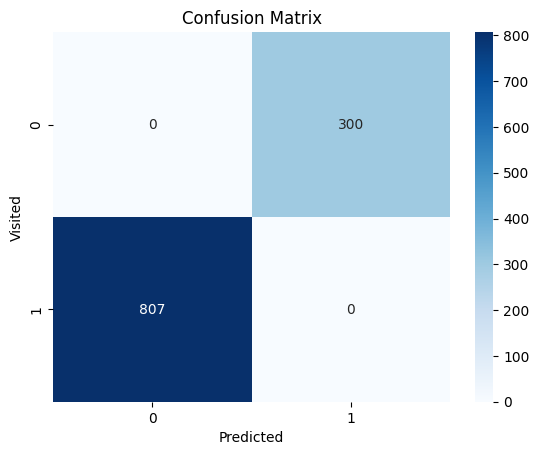

              precision  recall  f1-score  support
0                   0.0     0.0       0.0    300.0
1                   0.0     0.0       0.0    807.0
accuracy            0.0     0.0       0.0      0.0
macro avg           0.0     0.0       0.0   1107.0
weighted avg        0.0     0.0       0.0   1107.0


In [50]:
# Generar y_test y y_test_pred
y_test = []
y_test_pred = []

for id_user in test_df['id_user'].unique():
    recommendations = get_recommendations(id_user, train_df, test_df, train_cosine_sim)

    relevant_items = test_df[test_df['id_user'] == id_user]['id_business'].values

    # Si no hay recomendaciones, registrar un 0 en y_test para todos los ítems relevantes
    if recommendations.empty:
        for item in relevant_items:
            y_test.append(1)
            y_test_pred.append(0)
        print(f"No se encontraron recomendaciones para el usuario {id_user}.")
        continue

    recommended_items = recommendations['id_business'].values

    for item in relevant_items:
        y_test.append(1)
        if item in recommended_items:
            y_test_pred.append(1)
        else:
            y_test_pred.append(0)

    for item in recommended_items:
        if item not in relevant_items:
            y_test.append(0)
            y_test_pred.append(1)

# Verificar el contenido de las listas y_test y y_test_pred
print("y_test:", y_test)
print("y_test_pred:", y_test_pred)

# Calcular el reporte de clasificación
report = classification_report(y_test, y_test_pred, output_dict=True)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Visited')
plt.title('Confusion Matrix')
plt.show()

# Convertir el reporte a un DataFrame para una mejor visualización
report_df = pd.DataFrame(report).transpose()
print(report_df)

In [51]:
# Calcular NDCG
ndcg = ndcg_score([y_test], [y_test_pred])
print(f"NDCG: {ndcg}")

NDCG: 0.835001076426025


### Observaciones:
* La evaluación del modelo por la matriz de confusión y por recall, precision, f1-score y accuracy funciona muy mal. 
* La evaluación del modelo por NDCG funciona de forma adecuada.
* Las primeras dos observaciones plantean lo siguiente:
  * El dataset ha sido muy recortado. Aunque lo extraño que los lugares que sí visitó el usuario, tampoco estaría recomendando el sistema.
  * No sirve evaluar el modelo entre lo que predice y las reseñas de cada usuario en los establecimientos. El sistema podria estar dando recomendaciones acertadas pero el usuario no los ha visitado, y el usuario visita lugares que no son adecuados para ellos. 
  * Del anterior, lo ideal sería implementar el sistema de recomendación en producción, y registrar las reseñas de los usuarios que efectivamente visitaron el establecimiento segun recomendación del sistema. Esto será un KPI y creo que es la mejor forma de medir el sistema.
  * El filtro solo de contenido no es útil. Los usuarios quizás se guian por otras cuestiones, como las calificaciones de los negocios y las reseñas de otros usuarios.


### Planteos:
1. Aunque no se pueda evaluar, un sistema de recomendación por contenido en base a filtros que el usuario puede escoger, podria ser una buena alternativa para empezar.
2. Aunque la evaluación del modelo por filtro de contenido no ha sido bien evaluado, podria implementarse en producción (etapas futuras de este proyecto) y registrar el feedback del usuario.
3. Se puede agregar más filtros para que el usuario en cuestión tenga la posibilidad de elegir y probar cuál le funciona mejor.
4. Se podría implementar análisis de sentimiento en las reseñas de cada usuario.

### Endpoint 3: Filtro colaborativo basado en la calificación 'user_rating'

Recomendación:

Para cada usuario en el conjunto de prueba:

Obtiene las valoraciones del usuario y encuentra usuarios similares.

Calcula la puntuación ponderada para cada restaurante basándose en las similitudes entre usuarios.

Filtra los restaurantes que el usuario ya ha valorado con 4 o 5 estrellas.

Selecciona los restaurantes con las mayores puntuaciones ponderadas y los ordena.

Devuelve un DataFrame con las recomendaciones y la columna similarity formateada en porcentajes.

In [ ]:
# Crear una copia del DataFrame para evitar modificaciones en el original
sample_df_3 = sample_df_2.copy()

# Filtrar un subconjunto de usuarios más activos
active_users = sample_df_3['id_user'].value_counts().head(100).index.tolist()
sample_df_3 = sample_df_3[sample_df_3['id_user'].isin(active_users)]

# Crear una columna con 0 y 1 segun calificacion por usuario
sample_df_3['user_rating_binary'] = sample_df_3['user_rating'].apply(lambda x: 1 if x >= 4 else 0)

# Filtrar los restaurantes con una calificación de 4 o más estrellas
sample_df_3 = sample_df_3[sample_df_3['business_rating'] >= 4]

# Crear una matriz de usuario-restaurante basada en las reseñas de 4 o 5 estrellas
user_restaurant_matrix = sample_df_3.pivot_table(index='id_user', columns='restaurant_name', values='user_rating_binary')
user_restaurant_matrix.fillna(0, inplace=True)

# Reducir la dimensionalidad con TruncatedSVD
svd = TruncatedSVD(n_components=100)
user_restaurant_matrix_reduced = svd.fit_transform(user_restaurant_matrix)

# Calcular la similitud entre usuarios usando la matriz reducida
user_similarity = cosine_similarity(user_restaurant_matrix_reduced)
user_similarity_df = pd.DataFrame(user_similarity, index=user_restaurant_matrix.index, columns=user_restaurant_matrix.index)

# Separar en conjunto de entrenamiento y prueba
train_df, test_df = train_test_split(sample_df_3, test_size=0.2, random_state=42)

# Crear la matriz usuario-restaurante para entrenamiento y prueba
train_user_restaurant_matrix = train_df.pivot_table(index='id_user', columns='restaurant_name', values='user_rating_binary')
train_user_restaurant_matrix.fillna(0, inplace=True)

# Función de recomendaciones colaborativas
def get_recommendations(id_user, n_recommendations=3, user_restaurant_matrix=train_user_restaurant_matrix, user_similarity_df=user_similarity_df, sample_df=train_df):
    # Obtener las valoraciones del usuario
    user_ratings = user_restaurant_matrix.loc[id_user]
    
    # Encontrar usuarios similares
    similar_users = user_similarity_df[id_user].sort_values(ascending=False)
    
    # Calcular la puntuación ponderada para cada restaurante
    weighted_ratings = user_restaurant_matrix.T.dot(similar_users)
    
    # Escalar las puntuaciones para que estén entre 0 y 1
    scaler = MinMaxScaler()
    weighted_ratings = pd.Series(scaler.fit_transform(weighted_ratings.values.reshape(-1, 1)).flatten(), index=weighted_ratings.index)
    
    # Filtrar los restaurantes que el usuario actual ya ha valorado con 4 o 5 estrellas
    rated_restaurants = user_ratings[user_ratings == 1].index
    weighted_ratings.drop(rated_restaurants, inplace=True)
    
    # Seleccionar los n restaurantes con mayor puntuación
    top_recommendations = weighted_ratings.sort_values(ascending=False).head(n_recommendations)
    
    # Crear el DataFrame de recomendaciones con el mismo índice que top_recommendations
    recommendations = sample_df[sample_df['restaurant_name'].isin(top_recommendations.index)].drop_duplicates(subset=['restaurant_name'])
    
    # Emparejar y asignar las similitudes correctas
    similarity_dict = top_recommendations.to_dict()
    recommendations['similarity'] = recommendations['restaurant_name'].map(similarity_dict)
    
    # Convertir la similaridad a porcentajes
    recommendations['similarity'] = recommendations['similarity'].apply(lambda x: "{:.2f}%".format(x * 100))
    
    # Ordenar el DataFrame por la puntuación de similaridad
    recommendations = recommendations.sort_values(by='similarity', ascending=False).head(n_recommendations)
    
    return recommendations[['restaurant_name', 'similarity', 'business_city', 'postal_code', 'business_rating', 'cuisine']]

# Seleccionar un id_user aleatorio del DataFrame y obtener recomendaciones
random_user = random.choice(train_df['id_user'].unique())
recommendations = get_recommendations(random_user, n_recommendations=3)
print(f"Recommended Restaurants for user {random_user}:")
recommendations

Recommended Restaurants for user 288895:


,restaurant_name,similarity,business_city,postal_code,business_rating,cuisine
937645,American Restaurant,82.08%,New York,10028,4.4,Regional-American Cuisine
990945,Italian Restaurant,76.04%,New York,10003,4.4,Mediterranean Cuisine
1638424,Chinese Restaurant,63.31%,New York,10002,4.4,Regional-Chinese Asian Cuisine


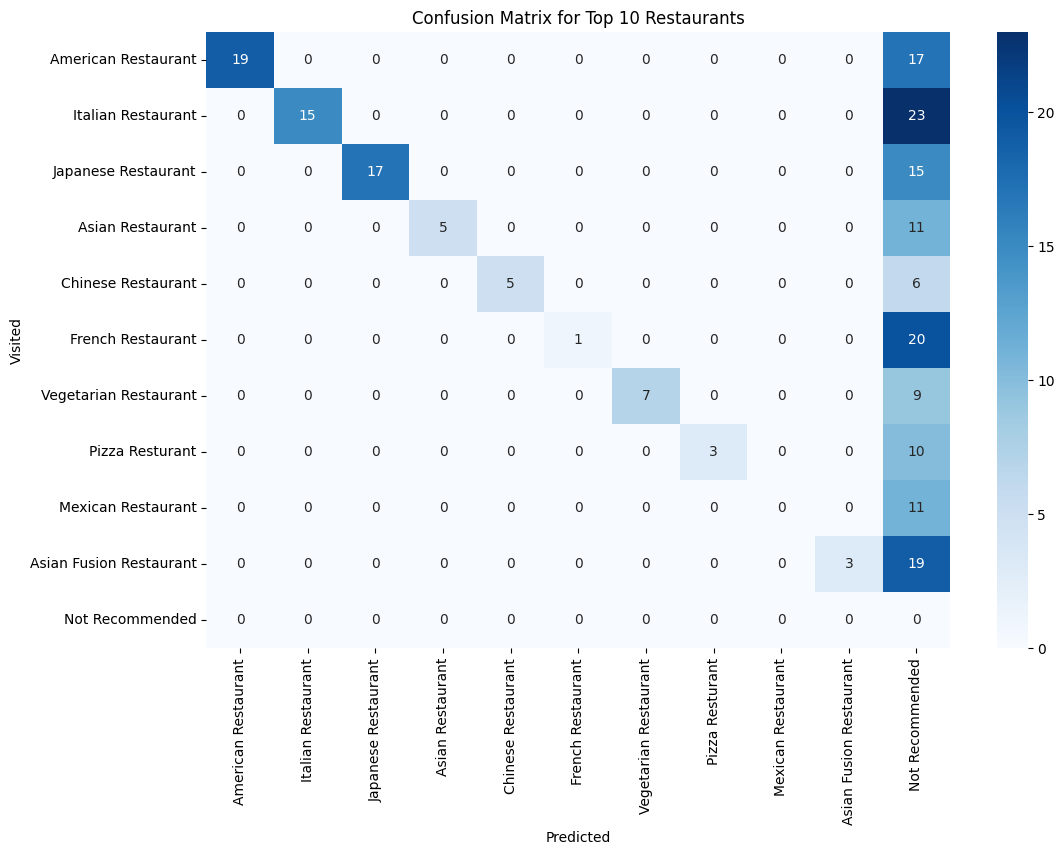

Classification Report:
                         precision    recall  f1-score   support

    American Restaurant       1.00      0.53      0.69        36
     Italian Restaurant       1.00      0.39      0.57        38
    Japanese Restaurant       1.00      0.53      0.69        32
       Asian Restaurant       1.00      0.31      0.48        16
     Chinese Restaurant       1.00      0.45      0.62        11
      French Restaurant       1.00      0.05      0.09        21
  Vegetarian Restaurant       1.00      0.44      0.61        16
        Pizza Resturant       1.00      0.23      0.38        13
     Mexican Restaurant       0.00      0.00      0.00        11
Asian Fusion Restaurant       1.00      0.14      0.24        22
        Not Recommended       0.00      0.00      0.00         0

               accuracy                           0.35       216
              macro avg       0.82      0.28      0.40       216
           weighted avg       0.95      0.35      0.49       216


c:\Users\Josue\OneDrive\Data_Scientist\Henry\Bootcamp\10. PF\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Josue\OneDrive\Data_Scientist\Henry\Bootcamp\10. PF\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Josue\OneDrive\Data_Scientist\Henry\Bootcamp\10. PF\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior

In [53]:
# Evaluar el modelo con el conjunto de prueba considerando los 10 primeros restaurantes
y_true = []
y_pred = []
top_10_restaurants = sample_df_3['restaurant_name'].value_counts().index[:10]  # Seleccionar los 10 restaurantes más comunes

for id_user in test_df['id_user'].unique():
    actual_restaurants = test_df[test_df['id_user'] == id_user]['restaurant_name'].values[:10]  # Considerar los 10 primeros restaurantes
    recommendations = get_recommendations(id_user, user_restaurant_matrix=train_user_restaurant_matrix, user_similarity_df=user_similarity_df)
    recommended_restaurants = recommendations['restaurant_name'].values
    
    # Evaluación
    for restaurant in actual_restaurants:
        if restaurant in top_10_restaurants:  # Considerar solo los 10 restaurantes más comunes
            y_true.append(restaurant)
            if restaurant in recommended_restaurants:
                y_pred.append(restaurant)
            else:
                y_pred.append("Not Recommended")

# Calcular la matriz de confusión solo para los 10 restaurantes más comunes
cm = confusion_matrix(y_true, y_pred, labels=list(top_10_restaurants) + ["Not Recommended"])

# Crear un mapa de calor para la matriz de confusión
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(top_10_restaurants) + ["Not Recommended"], yticklabels=list(top_10_restaurants) + ["Not Recommended"])
plt.xlabel('Predicted')
plt.ylabel('Visited')
plt.title('Confusion Matrix for Top 10 Restaurants')
plt.show()

# Calcular y mostrar el reporte de clasificación
print("Classification Report:")
print(classification_report(y_true, y_pred, labels=list(top_10_restaurants) + ["Not Recommended"]))

# Calcular y mostrar la precisión del modelo
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Calcular la métrica NDCG
# Generar una lista binaria para y_true
y_true_binary = [1 if restaurant in y_true else 0 for restaurant in recommended_restaurants]
# Calcular el NDCG
ndcg = ndcg_score([y_true_binary], [list(recommendations['similarity'].str.rstrip('%').astype('float') / 100)])
print("NDCG Score:", ndcg)

### Endpoint 4: Recomendación basado en la calificación más alta que el usuario asigno a un restaurant

Cómo Funciona el Sistema

Filtrado de usuarios activos: Filtra a los 100 usuarios más activos del DataFrame sample_df_2.

División de datos: Divide los datos en conjuntos de entrenamiento (train_df) y prueba (test_df).

Combinar cuisine y restaurant_name: Combina las columnas cuisine y restaurant_name para crear una nueva columna cuisine_restaurant.

Vectorización de descripciones: Vectoriza las descripciones de la nueva columna combinada utilizando TF-IDF.

Similitud coseno: Calcula la similitud coseno entre los restaurantes en el conjunto de entrenamiento.

Recomendación:

Para cada usuario en el conjunto de prueba:

Filtra las interacciones del usuario con calificaciones de 5 estrellas.

Ordena los restaurantes por business_rating y selecciona los 3 más altos.

Calcula la similitud promedio para los restaurantes recomendados y los convierte a porcentajes.

Devuelve un DataFrame con las recomendaciones y la columna similarity formateada en porcentajes

In [54]:
# Crear una copia del DataFrame para evitar modificaciones en el original
sample_df_4 = sample_df_2.copy()

# Filtrar un subconjunto de usuarios más activos
active_users = sample_df_2['id_user'].value_counts().head(100).index.tolist()  # Convertir a lista
sample_df_2 = sample_df_2[sample_df_2['id_user'].isin(active_users)]

# Dividir los datos en conjunto de entrenamiento y prueba
train_df, test_df = train_test_split(sample_df_2, test_size=0.2, random_state=42)

# Verificar el tamaño de los conjuntos de datos
print(f"Tamaño del conjunto de entrenamiento: {train_df.shape}")
print(f"Tamaño del conjunto de prueba: {test_df.shape}")

# Reindexar el DataFrame de entrenamiento
train_df = train_df.reset_index(drop=True)

# Combinar 'cuisine' y 'restaurant_name' en una nueva columna
train_df['cuisine_restaurant'] = train_df['cuisine'] + ' ' + train_df['restaurant_name']

# Crear la matriz TF-IDF para la nueva columna combinada
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(train_df['cuisine_restaurant'])

# Calcular la similitud coseno
cosine_sim = cosine_similarity(tfidf_matrix)

# Convertir la matriz de similitud coseno en un DataFrame
cosine_sim_df = pd.DataFrame(cosine_sim, index=train_df.index, columns=train_df.index)

# Crear una función de recomendación basada en calificaciones de 5 estrellas y filtrar por los 3 business_rating más altos
def get_top_rated_recommendation(id_user, df, sim_df):
    user_interactions = df[(df['id_user'] == id_user) & (df['user_rating'] == 5)]
    if user_interactions.empty:
        return pd.DataFrame(columns=['restaurant_name', 'similarity', 'business_city', 'postal_code', 'business_rating', 'cuisine'])  # Devolver DataFrame vacío si el usuario no tiene interacciones de 5 estrellas
    
    # Ordenar por business_rating y seleccionar los 3 más altos
    top_rated = user_interactions.sort_values(by='business_rating', ascending=False).head(3)
    
    # Calcular la similitud promedio para los restaurantes recomendados
    similarities = []
    for idx in top_rated.index:
        sim_scores = sim_df.loc[idx].values
        sim_avg = sim_scores.mean()
        similarities.append(f"{sim_avg * 100:.2f}%")  # Convertir la similitud a porcentajes y agregar el símbolo %
    
    top_rated['similarity'] = similarities
    
    # Reordenar las columnas en el DataFrame de recomendaciones
    recommendations = top_rated[['restaurant_name', 'similarity', 'business_city', 'postal_code', 'business_rating', 'cuisine']]
    
    return recommendations

# Generar una recomendación para un usuario en el conjunto de prueba
test_id_user = sample_df_2['id_user'].sample(n=1).iloc[0]  # Seleccionar un usuario al azar del subconjunto
print(f"Recomendaciones basadas en las calificaciones de 5 estrellas y los 3 business_rating más altos para el usuario: {test_id_user}")
top_rated_recommendation = get_top_rated_recommendation(test_id_user, train_df, cosine_sim_df)

print("Recomendaciones basadas en las calificaciones de 5 estrellas y los 3 business_rating más altos:")
top_rated_recommendation

Tamaño del conjunto de entrenamiento: (2582, 10)
Tamaño del conjunto de prueba: (646, 10)
Recomendaciones basadas en las calificaciones de 5 estrellas y los 3 business_rating más altos para el usuario: 659095
Recomendaciones basadas en las calificaciones de 5 estrellas y los 3 business_rating más altos:


,restaurant_name,similarity,business_city,postal_code,business_rating,cuisine
1776,American Restaurant,17.03%,New York,10003,4.1,Regional-American Cuisine
803,Hamburger Restaurant,9.90%,New York,10012,3.9,American Fast-Casual Cuisine
2320,American Restaurant,17.03%,New York,10012,3.9,Regional-American Cuisine


### Endpoint 5: Recomendación basado en un filtro híbrido

Criterios:
* Sistema 1: Basado en Calificaciones de Usuarios: Filtra y recomienda restaurantes que el usuario ha calificado con 5 estrellas.
* Sistema 2: Basado en Similitud Coseno: Calcula la similitud coseno combinando las variables cuisine y restaurant_name.
* Sistema 3: Filtrado por los 3 business_rating más altos: Recomienda los tres restaurantes con las calificaciones más altas (business_rating).

In [106]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# Inicializar el vectorizador TF-IDF
vectorizer = TfidfVectorizer(max_df=0.85, min_df=10, stop_words='english')

# Crear una copia del DataFrame para evitar modificaciones en el original
sample_df_4 = sample_df_2.copy()

# Filtrar un subconjunto de usuarios más activos
active_users = sample_df_2['id_user'].value_counts().head(100).index.tolist()  # Convertir a lista
sample_df_2 = sample_df_2[sample_df_2['id_user'].isin(active_users)]

# **Filtrar solo los restaurantes con 4 o 5 estrellas**
sample_df_2 = sample_df_2[sample_df_2['business_rating'].isin([4, 5])]

# Verificar el DataFrame después del filtrado
print(f"DataFrame después del filtrado de 4 y 5 estrellas: {sample_df_2.shape}")
print(sample_df_2.head())

# Dividir los datos en conjunto de entrenamiento y prueba
train_df, test_df = train_test_split(sample_df_2, test_size=0.2, random_state=42)

# Reindexar el DataFrame de entrenamiento
train_df = train_df.reset_index(drop=True)

# Verificar el tamaño de los conjuntos de datos
print(f"Tamaño del conjunto de entrenamiento: {train_df.shape}")
print(f"Tamaño del conjunto de prueba: {test_df.shape}")

# Asegurarse de que ambas matrices se calculen sobre el mismo conjunto de datos
combined_df = train_df.copy()

# 1. **Similitud Basada en Contenido**
# Combinar 'cuisine' y 'restaurant_name' en una nueva columna
combined_df['cuisine_restaurant'] = combined_df['cuisine'] + ' ' + combined_df['restaurant_name']

# Crear la matriz TF-IDF para la nueva columna combinada
tfidf_matrix = vectorizer.fit_transform(combined_df['cuisine_restaurant'])

# Calcular la similitud coseno
cosine_sim_content = cosine_similarity(tfidf_matrix)

# Verificar la matriz de similitud de contenido
print(f"Tamaño de la matriz de similitud de contenido: {cosine_sim_content.shape}")

# 2. **Similitud Basada en Calificaciones**
# Crear una matriz binaria de usuario-restaurante
combined_df['user_rating_binary'] = combined_df['user_rating'].apply(lambda x: 1 if x >= 4 else 0)
user_restaurant_matrix = combined_df.pivot_table(index='id_user', columns='restaurant_name', values='user_rating_binary')
user_restaurant_matrix.fillna(0, inplace=True)

# Verificar la matriz binaria de usuario-restaurante
print(f"Tamaño de la matriz binaria de usuario-restaurante: {user_restaurant_matrix.shape}")

# Calcular la similitud de coseno para usuarios y promediar por restaurante
user_sim_matrix = cosine_similarity(user_restaurant_matrix)
user_similarity_df = pd.DataFrame(user_sim_matrix, index=user_restaurant_matrix.index, columns=user_restaurant_matrix.index)
restaurant_similarity_matrix = user_restaurant_matrix.T.dot(user_similarity_df).dot(user_restaurant_matrix)

# Verificar la matriz de similitud de restaurante
print(f"Tamaño de la matriz de similitud de restaurante: {restaurant_similarity_matrix.shape}")

# Escalar las similitudes a un rango de 0 a 1
scaler = MinMaxScaler()
cosine_sim_ratings = scaler.fit_transform(restaurant_similarity_matrix)

# Asegurarse de que ambas matrices tienen el mismo tamaño
cosine_sim_ratings = cosine_sim_ratings[:len(tfidf_matrix), :len(tfidf_matrix)]

# 3. **Combinar Similitudes**
# Ponderar las dos matrices de similitud
alpha = 0.5  # Peso para la similitud basada en contenido
beta = 0.5   # Peso para la similitud basada en calificaciones

hybrid_cosine_sim = (alpha * cosine_sim_content) + (beta * cosine_sim_ratings)

# Convertir la matriz híbrida de similitud en un DataFrame
hybrid_cosine_sim_df = pd.DataFrame(hybrid_cosine_sim, index=combined_df.index, columns=combined_df.index)

# Verificar la matriz híbrida de similitud
print(f"Tamaño de la matriz híbrida de similitud: {hybrid_cosine_sim_df.shape}")

# Función para obtener recomendaciones híbridas
def get_hybrid_recommendation(id_user, df, sim_df):
    user_interactions = df[df['id_user'] == id_user]
    visited_restaurants = user_interactions['restaurant_name'].tolist()
    
    # Filtrar restaurantes no visitados por el usuario
    not_visited_df = df[~df['restaurant_name'].isin(visited_restaurants)]
    
    # Calcular la similitud coseno y ordenar por business_rating
    not_visited_df['similarity'] = not_visited_df.index.map(lambda idx: sim_df.loc[idx].mean() * 100)
    top_recommendations = not_visited_df.sort_values(by=['similarity', 'business_rating'], ascending=False).head(3)
    
    # Formatear la columna similarity con el término %
    top_recommendations['similarity'] = top_recommendations['similarity'].apply(lambda x: f"{x:.2f}%")
    
    # Reordenar las columnas en el DataFrame de recomendaciones
    recommendations = top_recommendations[['restaurant_name', 'similarity', 'business_city', 'postal_code', 'business_rating', 'cuisine']]
    
    return recommendations

# Generar una recomendación para un usuario en el conjunto de prueba
test_id_user = sample_df_2['id_user'].sample(n=1).iloc[0]  # Seleccionar un usuario al azar del subconjunto
print(f"Recomendaciones híbridas para el usuario: {test_id_user}")
hybrid_recommendation = get_hybrid_recommendation(test_id_user, combined_df, hybrid_cosine_sim_df)

print("Recomendaciones híbridas:")
hybrid_recommendation

DataFrame después del filtrado de 4 y 5 estrellas: (221, 10)
        id_user                            id_business     restaurant_name  \
99870    440961  0x89c2597879f30bf1:0xf583fd68a81761dd     Pizza Resturant   
192419   736152  0x89c2f6281fc2da11:0x9c3ca7e7db9b93b4     Pizza Resturant   
325069   671520  0x89c258bbf97f7297:0x46500164dbe67a5f     Pizza Resturant   
408503   689466  0x89c259816223d199:0xba8efa2f9f969fdb  Mexican Restaurant   
408513   707926  0x89c259816223d199:0xba8efa2f9f969fdb  Mexican Restaurant   

                              cuisine  \
99870   Italian Mediterranean Cuisine   
192419  Italian Mediterranean Cuisine   
325069  Italian Mediterranean Cuisine   
408503   Mesoamerican Spanish Cuisine   
408513   Mesoamerican Spanish Cuisine   

                                              description  \
99870   Pizza Resturant Italian Mediterranean Cuisine ...   
192419  Pizza Resturant Italian Mediterranean Cuisine ...   
325069  Pizza Resturant Italian Mediterr

TypeError: sparse array length is ambiguous; use getnnz() or shape[0]

In [55]:
# Crear una copia del DataFrame para evitar modificaciones en el original
sample_df_4 = sample_df_2.copy()

# Filtrar un subconjunto de usuarios más activos
active_users = sample_df_2['id_user'].value_counts().head(100).index.tolist()  # Convertir a lista
sample_df_2 = sample_df_2[sample_df_2['id_user'].isin(active_users)]

# Dividir los datos en conjunto de entrenamiento y prueba
train_df, test_df = train_test_split(sample_df_2, test_size=0.2, random_state=42)

# Verificar el tamaño de los conjuntos de datos
print(f"Tamaño del conjunto de entrenamiento: {train_df.shape}")
print(f"Tamaño del conjunto de prueba: {test_df.shape}")

# Reindexar el DataFrame de entrenamiento
train_df = train_df.reset_index(drop=True)

# Combinar 'cuisine' y 'restaurant_name' en una nueva columna
train_df['cuisine_restaurant'] = train_df['cuisine'] + ' ' + train_df['restaurant_name']

# Crear la matriz TF-IDF para la nueva columna combinada
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(train_df['cuisine_restaurant'])

# Calcular la similitud coseno
cosine_sim = cosine_similarity(tfidf_matrix)

# Convertir la matriz de similitud coseno en un DataFrame
cosine_sim_df = pd.DataFrame(cosine_sim, index=train_df.index, columns=train_df.index)

# Función para obtener recomendaciones híbridas
def get_hybrid_recommendation(id_user, df, sim_df):
    user_interactions = df[df['id_user'] == id_user]
    visited_restaurants = user_interactions['restaurant_name'].tolist()
    
    # Filtrar restaurantes no visitados por el usuario
    not_visited_df = df[~df['restaurant_name'].isin(visited_restaurants)]
    
    # Calcular la similitud coseno y ordenar por business_rating
    not_visited_df['similarity'] = not_visited_df.index.map(lambda idx: sim_df.loc[idx].mean() * 100)
    top_recommendations = not_visited_df.sort_values(by=['similarity', 'business_rating'], ascending=False).head(3)
    
    # Formatear la columna similarity con el término %
    top_recommendations['similarity'] = top_recommendations['similarity'].apply(lambda x: f"{x:.2f}%")
    
    # Reordenar las columnas en el DataFrame de recomendaciones
    recommendations = top_recommendations[['restaurant_name', 'similarity', 'business_city', 'postal_code', 'business_rating', 'cuisine']]
    
    return recommendations

# Generar una recomendación para un usuario en el conjunto de prueba
test_id_user = sample_df_2['id_user'].sample(n=1).iloc[0]  # Seleccionar un usuario al azar del subconjunto
print(f"Recomendaciones híbridas para el usuario: {test_id_user}")
hybrid_recommendation = get_hybrid_recommendation(test_id_user, train_df, cosine_sim_df)

print("Recomendaciones híbridas:")
hybrid_recommendation

Tamaño del conjunto de entrenamiento: (2582, 10)
Tamaño del conjunto de prueba: (646, 10)
Recomendaciones híbridas para el usuario: 660612
Recomendaciones híbridas:


C:\Users\Josue\AppData\Local\Temp\ipykernel_6548\4145710907.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_visited_df['similarity'] = not_visited_df.index.map(lambda idx: sim_df.loc[idx].mean() * 100)


,restaurant_name,similarity,business_city,postal_code,business_rating,cuisine
265,American Restaurant,17.03%,New York,10009,4.9,Regional-American Cuisine
623,American Restaurant,17.03%,New York,10014,4.8,Regional-American Cuisine
1168,American Restaurant,17.03%,New York,10012,4.7,Regional-American Cuisine


# Validación cruzada

In [ ]:
# Definir el número de folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Almacenar los índices de los folds
fold_indices = list(kf.split(df_content))

# Función para calcular precisión y cobertura
def calculate_metrics(recommendations, test_df, user_id):
    relevant_items = test_df[test_df['id_user'] == user_id]['id_business'].values
    recommended_items = recommendations['id_business'].values
    true_positives = len(set(recommended_items) & set(relevant_items))
    precision = true_positives / len(recommended_items) if len(recommended_items) > 0 else 0
    recall = true_positives / len(relevant_items) if len(relevant_items) > 0 else 0
    return precision, recall

# Función para procesar cada fold por separado
def process_fold(fold_num):
    train_index, test_index = fold_indices[fold_num]
    train_df = df_content.iloc[train_index]
    test_df = df_content.iloc[test_index]
    
    # Asegurarse de que df_users contiene solo los usuarios en train_df
    df_users_fold = df_users[df_users['id_user'].isin(train_df['id_user'])]

    # Reindexar el DataFrame de entrenamiento
    train_df = train_df.reset_index(drop=True)

    # Vectorizar las descripciones de los ítems del conjunto de entrenamiento
    vectorizer = TfidfVectorizer(max_features=5000)
    train_tfidf_matrix = vectorizer.fit_transform(train_df['description'])

    # Calcular la similitud de coseno para el conjunto de entrenamiento
    train_cosine_sim = cosine_similarity(train_tfidf_matrix, train_tfidf_matrix)

    # Asignar una ciudad aleatoria a cada usuario
    df_users_fold['user_city'] = df_users_fold['id_user'].apply(lambda x: random.choice(top_20_cities))

    precisions = []
    recalls = []

    for id_user in test_df['id_user'].unique():
        user_city = df_users_fold[df_users_fold['id_user'] == id_user]['user_city'].iloc[0]
        recommendations = get_city_food_recommendations_test(id_user, user_city, train_df, test_df, train_cosine_sim)
        precision, recall = calculate_metrics(recommendations, test_df, id_user)
        precisions.append(precision)
        recalls.append(recall)

    return np.mean(precisions), np.mean(recalls)

# Procesar cada fold y guardar los resultados
fold_results = [process_fold(fold_num) for fold_num in range(len(fold_indices))]

# Calcular las métricas promedio
average_precision = np.mean([result[0] for result in fold_results])
average_recall = np.mean([result[1] for result in fold_results])

print(f"Average Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")


In [62]:
# Definir el número de folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Almacenar las métricas de cada fold
precisions = []
recalls = []

# Función para calcular precisión y cobertura
def calculate_metrics(recommendations, test_df, user_id):
    relevant_items = test_df[test_df['id_user'] == user_id]['id_business'].values
    recommended_items = recommendations['id_business'].values
    true_positives = len(set(recommended_items) & set(relevant_items))
    precision = true_positives / len(recommended_items) if len(recommended_items) > 0 else 0
    recall = true_positives / len(relevant_items) if len(relevant_items) > 0 else 0
    return precision, recall

# Realizar la validación cruzada
for train_index, test_index in kf.split(df_content):
    train_df = df_content.iloc[train_index]
    test_df = df_content.iloc[test_index]
    
    # Asegurarse de que df_users contiene solo los usuarios en train_df
    df_users_fold = df_users[df_users['id_user'].isin(train_df['id_user'])]

    # Reindexar el DataFrame de entrenamiento
    train_df = train_df.reset_index(drop=True)

    # Vectorizar las descripciones de los ítems del conjunto de entrenamiento
    vectorizer = TfidfVectorizer(max_features=5000)
    train_tfidf_matrix = vectorizer.fit_transform(train_df['description'])

    # Calcular la similitud de coseno para el conjunto de entrenamiento
    train_cosine_sim = cosine_similarity(train_tfidf_matrix, train_tfidf_matrix)

    # Asignar una ciudad aleatoria a cada usuario
    df_users_fold['user_city'] = df_users_fold['id_user'].apply(lambda x: random.choice(top_20_cities))

    for id_user in test_df['id_user'].unique():
        user_city = df_users_fold[df_users_fold['id_user'] == id_user]['user_city'].iloc[0]
        recommendations = get_city_food_recommendations_test(id_user, user_city, train_df, test_df, train_cosine_sim)
        precision, recall = calculate_metrics(recommendations, test_df, id_user)
        precisions.append(precision)
        recalls.append(recall)

# Calcular la precisión y cobertura promedio
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)

print(f"Average Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")


KeyboardInterrupt: 

### Filtro híbrido

In [92]:
# Vectorizar las descripciones
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['Full Description'])

# Calcular la similitud de coseno
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Crear una función de recomendación basada en la similitud de coseno
def get_content_based_recommendations(keyword, cosine_sim=cosine_sim, df=df, vectorizer=vectorizer):
    keyword_tfidf = vectorizer.transform([keyword])
    keyword_sim = cosine_similarity(keyword_tfidf, tfidf_matrix)
    sim_scores = list(enumerate(keyword_sim[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    umbral_similitud = 0.1
    filtered_scores = [score for score in sim_scores if score[1] > umbral_similitud]
    category_indices = [i[0] for i in filtered_scores[:5]]
    scores = [i[1] for i in filtered_scores[:5]]
    recommendations = pd.DataFrame({
        'Restaurant Name': df['Restaurant Name'].iloc[category_indices],
        'Cosine_Similarity_Score': scores
    })
    return recommendations

# Crear una función de recomendación basada en filtrado colaborativo
def get_collaborative_recommendations(id_user, df_reviews=df_reviews):
    user_reviews = df_reviews[df_reviews['id_user'] == id_user]
    other_reviews = df_reviews[df_reviews['id_user'] != id_user]
    scores = other_reviews.groupby('Restaurant Name')['rating'].mean()
    recommended_restaurants = scores.sort_values(ascending=False).index[:5]
    return recommended_restaurants

# Sistema de recomendación híbrido
def hybrid_recommendation(user_id, keyword):
    content_based_recommendations = get_content_based_recommendations(keyword)
    collaborative_recommendations = get_collaborative_recommendations(user_id)
    combined_recommendations = pd.concat([content_based_recommendations, pd.DataFrame(collaborative_recommendations, columns=['Restaurant Name'])])
    return combined_recommendations.drop_duplicates().reset_index(drop=True)

# Ejemplo de uso: Obtener recomendaciones para el usuario 1 y la palabra clave 'Meat'
recommended = hybrid_recommendation(1, 'Meat')
print("Hybrid Recommended Restaurants:")
print(recommended)

KeyError: 'Restaurant Name'

Para el motor de búsqueda puede servir este dataframe

In [51]:
import pandas as pd

# Lista de datos, donde cada lista interna representa una fila
data = [
    ['Modern French Restaurant', 'French', 'European','Continent'],
    ['Pizza Resturant', 'Italian', 'European', ''],
    ['Mexican Restaurant', 'Mexican', 'Latin American', 'Continent'],
    ['Family Restaurant', None, None, 'Type'],
    ['American Restaurant', 'Traditional American', 'North American', 'Continent'],
    ['Italian Restaurant', 'Italian', 'European', 'Continent'],
    ['Creole Restaurant', 'Southern American Cuisine', 'North American', 'Continent'],
    ['Caribbean Restaurant', None, 'Caribbean', 'Continent'],
    ['Soul Food Restaurant', 'Southern American Cuisine', 'North American', 'Continent'],
    ['Health Food Restaurant', None, None, 'Healthy'],
    ['Cheesesteak Restaurant', 'American Fast Food', 'North American', 'Continent'],
    ['Jamaican Restaurant', 'Jamaican', 'Caribbean', 'Continent'],
    ['Vegan Restaurant', None, None, 'Healthy'],
    ['Kosher', 'Israel', 'Middle Eastern', 'Continent'],
    ['Vegetarian Restaurant', None, None, 'Healthy'],
    ['Chicken Restaurant', None, None, 'Global Dishes'],
    ['Seafood Restaurant', None, None, 'Global Dishes'],
    ['Chinese Restaurant', 'Chinese', 'Asian', 'Continent'],
    ['Guatemalan Restaurant', 'Guatemalan', 'Latin American', 'Continent'],
    ['Peruvian Restaurant', 'Peruvian', 'Latin American', 'Continent'],
    ['Fusion Restaurant', None, None, 'Fusion'],
    ['Middle Estearn Restaurant', None, 'Middle Eastern', 'Continent'],
    ['Turkish Restaurant', 'Turkish', 'Middle Eastern', 'Continent'],
    ['Vietnamese Restaurant', 'Vietnamese', 'Asian', 'Continent'],
    ['Japanese Restaurant', 'Japanese', 'Asian', 'Continent'],
    ['Indian Restaurant', 'Indian', 'Asian', 'Continent'],
    ['Cajun Restaurant', 'Southern American Cuisine', 'North American', 'Continent'],
    ['Chicken Wings Restaurant', None, None, 'Global Dishes'],
    ['Hamburger Restaurant', 'American Fast Food', 'North American', 'Continent'],
    ['Asian Fusion Restaurant', None, None, 'Fusion'],
    ['Asian Restaurant', None, 'Asian', 'Continent'],
    ['Pho Restaurant', 'Vietnamese', 'Asian', 'Continent'],
    ['Sushi Restaurant', 'Japanese', 'Asian', 'Continent'],
    ['Tex-Mex Restaurant', None, None, 'Fusion'],
    ['Mediterranean Restaurant', None, 'European', 'Continent'],
    ['Thai Restaurant', 'Thailand', 'Asian', 'Continent'],
    ['African Restaurant', None, 'African', 'Continent'],
    ['West African Restaurant', None, 'African', 'Continent'],
    ['Eclectic Restaurant', None, None, 'Fusion'],
    ['German Restaurant', 'German', 'European', 'Continent'],
    ['Latin American Restaurant', None, 'Latin American', 'Continent'],
    ['Barbecue Restaurant', 'American Specialty', 'North American', 'Continent'],
    ['Hunan Restaurant', 'Chinese', 'Asian', 'Continent'],
    ['Halal Restaurant', None, 'Middle Eastern', 'Continent'],
    ['Puerto Rican Restaurant', 'Puerto Rican', 'Caribbean', 'Continent'],
    ['Nuevo Latino Restaurant', None, 'Latin American', 'Continent'],
    ['Salvadoran Restaurant', 'Salvadoran', 'Latin American', 'Continent'],
    ['Organic Restaurant', None, None, 'Healthy'],
    ['Ramen Restaurant', 'Japanese', 'Asian', 'Continent'],
    ['Korean Restaurant', 'Korean', 'Asian', 'Continent'],
    ['Chinese Noodle Restaurant', 'Chinese', 'Asian', 'Continent'],
    ['Cold Noodle Restaurant', 'Korean', 'Asian', 'Continent'],
    ['Dan Dan Noodle Restaurant', 'Chinese', 'Asian', 'Continent'],
    ['Udon Noodle Restaurant', 'Chinese', 'Asian', 'Continent'],
    ['Cuban Restaurant', 'Cuban', 'Caribbean', 'Continent'],
    ['Colombian Restaurant', 'Colombian', 'Latin American', 'Continent'],
    ['Taiwanese Restaurant', 'Taiwanese', 'Asian', 'Continent'],
    ['Pakistani Restaurant', 'Pakistani', 'Asian', 'Continent'],
    ['Mandarin Restaurant', 'Chinese', 'Asian', 'Continent'],
    ['Central American Restaurant', None, 'Latin American', 'Continent'],
    ['Ecuadorian Restaurant', 'Ecuadorian', 'Latin American', 'Continent'],
    ['Greek Restaurant', 'Greek', 'European', 'Continent'],
    ['Fine Dining Restaurant', 'French', 'European', 'Continent'],
    ['New American Restaurant', 'Traditional American', 'North American', 'Continent'],
    ['Hoagie Restaurant', 'American Fast Food', 'North American', 'Continent'],
    ['Taco Restaurant', 'Mexican', 'Latin American', 'Continent'],
    ['Honduran Restaurant', 'Honduran', 'Latin American', 'Continent'],
    ['Burrito Restaurant', 'Mexican', 'Latin American', 'Continent'],
    ['Small Plates Restaurant', None, None, 'Fusion'],
    ['Traditional American Restaurant', 'Traditional American', 'North American', 'Continent'],
    ['Delivery Chinese Restaurant', 'Chinese', 'Asian', 'Continent'],
    ['Hot Pot Restaurant', 'Chinese', 'Asian', 'Continent'],
    ['Mexican Torta Restaurant', 'Mexican', 'Latin American', 'Continent'],
    ['Dominican Restaurant', 'Dominican', 'Caribbean', 'Continent'],
    ['Gluten-Free Restaurant', None, None, 'Healthy'],
    ['Portuguese Restaurant', 'Portuguese', 'European', 'Continent'],
    ['Fish and Chips Restaurant', 'British', 'European', 'Continent'],
    ['Filipino Restaurant', 'Filipino', 'Asian', 'Continent'],
    ['Spanish Restaurant', 'Spanish', 'European', 'Continent'],
    ['Rice Restaurant', None, None, 'Global Dishes'],
    ['Hot Dog Restaurant', 'American Fast Food', 'North American', 'Continent'],
    ['Authentic Japanese Restaurant', 'Japanese', 'Asian', 'Continent'],
    ['Southern Restaurant (US)', 'Southern American Cuisine', 'North American', 'Continent'],
    ['Pancake Restaurant', None, None, 'Global Dishes'],
    ['Jewish Restaurant', 'Israeli', 'Middle Eastern', 'Continent'],
    ['Teppanyaki Restaurant', 'Japanese', 'Asian', 'Continent'],
    ['Malaysian Restaurant', 'Malaysian', 'Asian', 'Continent'],
    ['Soup Restaurant', None, None, 'Global Dishes'],
    ['Brazilian Restaurant', 'Brazilian', 'Latin American', 'Continent'],
    ['Moroccan Restaurant', 'Moroccan', 'African', 'Continent'],
    ['Dance Restaurant', None, None, 'Type'],
    ['Southwestern Restaurant (US)', 'Southern American Cuisine', 'North American', 'Continent'],
    ['Down Home Cooking Restaurant', 'Southern American Cuisine', 'North American', 'Continent'],
    ['Hawaiian Restaurant', 'Regional American', 'North American', 'Continent'],
    ['Lebanese Restaurant', 'Lebanese', 'Middle Eastern', 'Continent'],
    ['Southeast Asian Restaurant', 'Southeast Asian', 'Asian', 'Continent'],
    ['Dim Sum Restaurant', 'Chinese', 'Asian', 'Continent'],
    ['Southern Italian Restaurant', 'Italian', 'European', 'Continent'],
    ['Gyro Restaurant', 'Greek', 'European', 'Continent'],
    ['Polish Restaurant', 'Polish', 'European', 'Continent'],
    ['Hong Kong Style Fast Food Restaurant', 'Hong Kong', 'Asian', 'Continent'],
    ['Tapas Restaurant', 'Spanish', 'European', 'Continent'],
    ['Haitian Restaurant', 'Haitian', 'Restaurant', 'Continent'],
    ['Swedish Restaurant', 'Swedish', 'European', 'Continent'],
    ['French Restaurant', 'French', 'European', 'Continent'],
    ['South Asian Restaurant', 'South Asian', 'Asian', 'Continent'],
    ['Puebla Restaurant', 'Mexican', 'Latin American', 'Continent'],
    ['Pan-Asian Restaurant', 'Fusion', 'Asian', 'Continent'],
    ['Pozole Restaurant', 'Mexican', 'Latin American', 'Continent'],
    ['Modern Indian Restaurant', 'Indian', 'Asian', 'Continent'],
    ['South American Restaurant', 'South America', 'Latin American', 'Continent'],
    ['Cantonese Restaurant', 'Chinese', 'Asian', 'Continent'],
    ['Continental Restaurant', 'European Continental', 'European', 'Continent'],
    ['Dumpling Restaurant', None, None, 'Global Dishes'],
    ['Californian Restaurant', 'Regional American', 'North American', 'Continent'],
    ['North Eastern Indian Restaurant', 'Indian', 'Asian', 'Continent'],
    ['Fondue Restaurant', 'Swiss', 'European', 'Continent'],
    ['Falafel Restaurant', 'Middle Eastern', 'Middle Eastern', 'Continent'],
    ['Venezuelan Restaurant', 'Venezuelan', 'Latin American', 'Continent'],
    ['Ethnic Restaurant', None, None, 'Ethnic'],
    ['Bangladeshi Restaurant', 'Bangladeshi', 'Asian', 'Continent'],
    ['Sichuan Restaurant', 'Chinese', 'Asian', 'Continent'],
    ['Cambodian Restaurant', 'Cambodian', 'Asian', 'Continent'],
    ['Indian Muslim Restaurant', 'Indian', 'Asian', 'Continent'],
    ['Neapolitan Restaurant', 'Italian', 'European', 'Continent'],
    ['Japanese Curry Restaurant', 'Japanese', 'Asian', 'Continent'],
    ['Uzbeki Restaurant', 'Uzbeki', 'Asia', 'Continent'],
    ['Shawarma Restaurant', 'Middle Eastern', 'Middle Eastern', 'Continent'],
    ['Egyptian Restaurant', 'Egyptian', 'Middle Eastern', 'Continent'],
    ['Georgian Restaurant', 'Georgian', 'European', 'Continent'],
    ['Russian Restaurant', 'Russian', 'European', 'Continent'],
    ['Pan-Latin Restaurant', 'America Latina', 'América Latina', 'Continent'],
    ['Nicaraguan Restaurant', 'Nicaraguan', 'America Latina', 'Continent'],
    ['Ethiopian Restaurant', 'Ethiopian', 'African', 'Continent'],
    ['Mid-Atlantic Restaurant (US)', 'Regional American', 'North American', 'Continent'],
    ['Israeli Restaurant', 'Israeli', 'Middle Eastern', 'Continent'],
    ['Northern Italian Restaurant', 'Italian', 'European', 'Continent'],
    ['Romanian Restaurant', 'Romanian', 'European', 'Continent'],
    ['Eastern European Restaurant', 'Eastern European', 'European', 'Continent'],
    ['Irish Restaurant', 'Irish', 'European', 'Continent'],
    ['Belgian Restaurant', 'Belgian', 'European', 'Continent'],
    ['Korean Barbecue Restaurant', 'Korean', 'Asian', 'Continent'],
    ['Afghani Restaurant', 'Afghani', 'Asian', 'Continent'],
    ['Modern European Restaurant', 'Modern European', 'European', 'Continent'],
    ['Scandinavian Restaurant', 'Scandinavian', 'European', 'Continent'],
    ['Floridian Restaurant', 'Regional American', 'North American', 'Continent'],
    ['Raw Food Restaurant', None, None, 'Healthy'],
    ['Country Food Restaurant', 'American Specialty', 'North American', 'Continent'],
    ['Eritrean Restaurant', 'Eritrean', 'African', 'Continent'],
    ['Persian Restaurant', 'Persian', 'Middle Eastern', 'Continent'],
    ['Porridge Restaurant', None, None, 'Global Dishes'],
    ['Syrian Restaurant', 'Syrian', 'Middle Eastern', 'Continent'],
    ['Tuscan Restaurant', 'Italian', 'European', 'Continent'],
    ['Raclette Restaurant', 'Swiss', 'European', 'Continent'],
    ['Traditional Restaurant', 'Traditional American', 'North American', 'Continent'],
    ['Argentinian Restaurant', 'Argentinian', 'Latin American', 'Continent'],
    ['Armenian Restaurant', 'Armenian', 'European', 'Continent'],
    ['Croatian Restaurant', 'Croatian', 'European', 'Continent'],
    ['Australian Restaurant', 'Australian', 'European', 'Continent'],
    ['Chophouse Restaurant', 'American Specialty', 'North American', 'Continent'],
    ['Indonesian Restaurant', 'Indonesian', 'Asian', 'Continent'],
    ['Paraguaya Restaurant', 'Paraguayan', 'Latin American', 'Continent'],
    ['Wok Restaurant', 'Traditional Asian', 'Asian', 'Continent'],
    ['Japanese Sweets Restaurant', 'Japanese', 'Asian', 'Continent'],
    ['Kyoto Style Japanese Restaurant', 'Japanese', 'Asian', 'Continent'],
    ['Nepalese Restaurant', 'Nepalese', 'Asian', 'Continent'],
    ['Ukrainian Restaurant', 'Ukrainian', 'European', 'Continent'],
    ['Sicilian Restaurant', 'Italian Sicilian', 'European', 'Continent'],
    ['Basque Restaurant', 'Spanish Basque', 'European', 'Continent'],
    ['South African Restaurant', 'South African', 'African', 'Continent'],
    ['Izakaya Restaurant', 'Japanese', 'Asian', 'Continent'],
    ['Yemenite Restaurant', 'Yemenite', 'African', 'Continent'],
    ['Sri Lankan Restaurant', 'Sri Lankan', 'Asian', 'Continent'],
    ['Laotian Restaurant', 'Laotian', 'Asian', 'Continent'],
    ['Costa Rican Restaurant', 'Costa Rican', 'Latin American', 'Continent'],
    ['Shanghainese Restaurant', 'Chinese', 'Asian', 'Continent'],
    ['New England Restaurant', 'Regional American', 'North American', 'Continent'],
    ['Hakka Restaurant', 'Chinese', 'Asian', 'Continent'],
    ['Meat Dish Restaurant', None, None, 'Global Dishes'],
    ['British Restaurant', 'British', 'European', 'Continent'],
    ['Tofu Restaurant', None, None, 'Healthy'],
    ['North African Restaurant', 'North African', 'African', 'Continent'],
    ['Singaporean Restaurant', 'Singaporean', 'Asian', 'Continent'],
    ['Modern Izakaya Restaurant', 'Japanese', 'Asian', 'Continent'],
    ['Yakitori Restaurant', 'Japanese', 'Asian', 'Continent'],
    ['East African Restaurant', 'Eastern African', 'African', 'Continent'],
    ['Mongolian Barbecue Restaurant', 'Mongolian', 'Asian', 'Continent'],
    ['Pennsilvania Dutch Restaurant', 'Regional American', 'North American', 'Continent'],
    ['Austrian Restaurant', 'Austrian', 'European', 'Continent'],
    ['Fish and Seafood Restaurant', None, None, 'Global Dishes'],
    ['Cape Verdean Restaurant', 'Cape Verdean', 'African', 'Continent'],
    ['Punjabi Restaurant', 'Indian', 'Asian', 'Continent'],
    ['Biryani Restaurant', 'Indian', 'Asian', 'Continent'],
    ['Seafood Donburi Restaurant', 'Japanese', 'Asian', 'Continent'],
    ['Yakiniku Restaurant', 'Japanese', 'Asian', 'Continent'],
    ['Couscous Restaurant', 'North African', 'Afican', 'Continent'],
    ['New Zealand Restaurant', 'New Zealand', 'Oceania', 'Continent'],
    ['Burmese Restaurant', 'Burmese', 'Asian', 'Continent'],
    ['English Restaurant', 'British', 'European', 'Continent'],
    ['French Steakhouse Restaurant', 'French', 'European', 'Continent'],
    ['Roman Restaurant', 'Italian', 'European', 'Continent'],
    ['Tibetan Restaurant', 'Chinese', 'Asian', 'Continent'],
    ['Tempura Restaurant', 'Japanese', 'Asian', 'Continent'],
    ['Tunisian Restaurant', 'Tunisian', 'African', 'Continent'],
    ['Chesapeake Restaurant', 'Regional American', 'North American', 'Continent'],
    ['Asturian Restaurant', 'Spanish Asturian', 'European', 'Continent'],
    ['Indian Sizzler Restaurant', 'Indian', 'Asian', 'Continent'],
    ['Danish Restaurant', 'Danish', 'European', 'Continent'],
    ['Chilean Restaurant', 'Chilean', 'Latin American', 'Continent'],
    ['Shabu-Shabu Restaurant', 'Japanese', 'Asian', 'Continent'],
    ['Czech Restaurant', 'Czech', 'European', 'Continent'],
    ['Hungarian Restaurant', 'Hungarian', 'European', 'Continent'],
    ['Japanese Regional Restaurant', 'Japanese', 'Asian', 'Continent'],
    ['Conveyor Belt Sushi Restaurant', 'Japanese', 'Asian', 'Continent'],
    ['Western Restaurant', None, None, 'Global Dishes'],
    ['Dutch Restaurant', 'Dutch', 'European', 'Continent'],
    ['Serbian Restaurant', 'Serbian', 'European', 'Continent'],
    ['Bulgarian Restaurant', 'Bulgarian', 'European', 'Continent'],
    ['Fujian Restaurant', 'Chinese', 'Asian', 'Continent'],
    ['Katsudun Restaurant', 'Japanese', 'Asian', 'Continent'],
    ['Polynesian Restaurant', 'Pacific', 'Oceania', 'Contient'],
    ['Madrilian Restaurant', 'Spanish', 'European', 'Continent'],
    ['Poâ€™ Boys Restaurant', 'Southern American Cuisine', 'North American', 'Continent'],
    ['Canadian Restaurant', 'Canadian', 'North American', 'Continent'],
    ['Pacific Rim Restaurant', 'Pacific', 'Oceania', 'Continent'],
    ['Macrobiotic Restaurant', None, None, 'Healthy'],
    ['Icelandic Restaurant', 'Icelandic', 'European', 'Continent'],
    ['Champon Noodle Restaurant', 'Japanese', 'Asian', 'Continent'],
    ['Korean Beef Restaurant', 'Korean', 'Asian', 'Continent'],
    ['Welsh Restaurant', 'Welsh', 'European', 'Continent'],
    ['Obanzai Restaurant', 'Japanese', 'Asian', 'Continent'],
    ['Contemporary Louisiana Restaurant', 'Southern American Cuisine', 'North American', 'Continent'],
    ['Kazakhstani Restaurant', 'Kazakhstania', 'Asian', 'Continent'],
    ['Modern British Restaurant', 'British', 'European', 'Continent'],
    ['Jiangsu Restaurant', 'Chinese', 'Asian', 'Continent'],
    ['Provence Restaurant', 'French', 'European', 'Continent'],
    ['Uruguayan Restaurant', 'Uruguayan', 'Latin American', 'Continent'],
    ['Syokudo and Teishoku Restaurant', 'Japanese', 'Asian', 'Continent'],
    ['Satay Restaurant', 'Southern Asian', 'Asian', 'Continent'],
    ['Chettinad Restaurant', 'Indian', 'Asian', 'Continent'],
    ['Tonkatsu Restaurant', 'Japanese', 'Asian', 'Continent'],
    ['Yucatan Restaurant', 'Mexican', 'Latin American', 'Continent'],
    ['Oaxacan Restaurant', 'Mexican', 'Latin American', 'Continent'],
    ['Japanized Western Restaurant', 'Japanese', 'Asian', 'Continent'],
    ['Kaiseki Restaurant', 'Japanese', 'Asian', 'Continent'],
    ['Korean Rib Restaurant', 'Korean', 'Asian', 'Continent'],
    ['Tempura Donburi Restaurant', 'Japanese', 'Asian', 'Continent'],
    ['Mutton Barbecue Restaurant', None, None, 'Global Dishes']       
]

# Crear el DataFrame
df = pd.DataFrame(data, columns=['Restaurant_Name', 'Cuisine', 'Region', 'Type'])

# Mostrar el DataFrame
df

,Restaurant_Name,Cuisine,Region,Type
0,Modern French Restaurant,French,European,Continent
1,Pizza Resturant,Italian,European,
2,Mexican Restaurant,Mexican,Latin American,Continent
3,Family Restaurant,None,None,Type
4,American Restaurant,Traditional American,North American,Continent
...,...,...,...,...
243,Japanized Western Restaurant,Japanese,Asian,Continent
244,Kaiseki Restaurant,Japanese,Asian,Continent
245,Korean Rib Restaurant,Korean,Asian,Continent
246,Tempura Donburi Restaurant,Japanese,Asian,Continent


In [52]:
# Rellenar valores None con cadenas vacías para evitar NaN en la concatenación 
df.fillna('', inplace=True)

# Agregar una columna 'Full Description' para facilitar la recomendación 
df['Full Description'] = df['Restaurant_Name'] + ' ' + df['Cuisine'] + ' ' + df['Region'] + ' ' + df['Type']

df.head(30)

,Restaurant_Name,Cuisine,Region,Type,Full Description
0,Modern French Restaurant,French,European,Continent,Modern French Restaurant French European Conti...
1,Pizza Resturant,Italian,European,,Pizza Resturant Italian European
2,Mexican Restaurant,Mexican,Latin American,Continent,Mexican Restaurant Mexican Latin American Cont...
3,Family Restaurant,,,Type,Family Restaurant Type
4,American Restaurant,Traditional American,North American,Continent,American Restaurant Traditional American North...
5,Italian Restaurant,Italian,European,Continent,Italian Restaurant Italian European Continent
6,Creole Restaurant,Southern American Cuisine,North American,Continent,Creole Restaurant Southern American Cuisine No...
7,Caribbean Restaurant,,Caribbean,Continent,Caribbean Restaurant Caribbean Continent
8,Soul Food Restaurant,Southern American Cuisine,North American,Continent,Soul Food Restaurant Southern American Cuisine...
9,Health Food Restaurant,,,Healthy,Health Food Restaurant Healthy


In [2]:
df.to_csv('restaurant.csv')

In [93]:
# Contar la frecuencia de cada país
country_counts = df['Subcategory2'].value_counts()

# Convertir la serie resultante a un DataFrame
country_counts_df = country_counts.reset_index()
country_counts_df.columns = ['País', 'Frecuencia']

print(country_counts_df)

KeyError: 'Subcategory2'

In [3]:
# Filtrar las filas donde 'Subcategory2' sea 'Japanese' 
japanese_rows = df[df['Subcategory2'] == 'Japanese']
japanese_rows

,Restaurant_Name,Subcategory2,Subcategory1,Type
24,Japanese Restaurant,Japanese,Asian,Continent
32,Sushi Restaurant,Japanese,Asian,Continent
48,Ramen Restaurant,Japanese,Asian,Continent
81,Authentic Japanese Restaurant,Japanese,Asian,Continent
85,Teppanyaki Restaurant,Japanese,Asian,Continent
125,Japanese Curry Restaurant,Japanese,Asian,Continent
163,Japanese Sweets Restaurant,Japanese,Asian,Continent
164,Kyoto Style Japanese Restaurant,Japanese,Asian,Continent
170,Izakaya Restaurant,Japanese,Asian,Continent
183,Modern Izakaya Restaurant,Japanese,Asian,Continent


In [5]:
# Filtrar las filas donde 'Subcategory2' sea 'Japanese' 
chinese_rows = df[df['Subcategory2'] == 'Chinese']
chinese_rows

,Restaurant_Name,Subcategory2,Subcategory1,Type
17,Chinese Restaurant,Chinese,Asian,Continent
42,Hunan Restaurant,Chinese,Asian,Continent
50,Chinese Noodle Restaurant,Chinese,Asian,Continent
52,Dan Dan Noodle Restaurant,Chinese,Asian,Continent
53,Udon Noodle Restaurant,Chinese,Asian,Continent
58,Mandarin Restaurant,Chinese,Asian,Continent
70,Delivery Chinese Restaurant,Chinese,Asian,Continent
71,Hot Pot Restaurant,Chinese,Asian,Continent
96,Dim Sum Restaurant,Chinese,Asian,Continent
111,Cantonese Restaurant,Chinese,Asian,Continent


In [12]:
us_rows = df[df['Subcategory2'] == '%American%']
us_rows

,Restaurant_Name,Subcategory2,Subcategory1,Type


In [23]:
lunch = ['continent', 'fusion', 'healthy']
fusion = ['Fusion restaurant', 'Asian fusion restaurant', 'Seafood', 'Eclectic',]
continents = ['Latin American', 'Caribbean', 'North American', 'European', 'African', 'Middle Eastern', 'Eastern', 'Oceania', 'Ethnic']
countries = ['Mexican', 'Italian', 'Jamaican', 'Chinese', 'Guatemalan', 'Peruvian', 'Turkish', 'Vietnamese', 'Japanese', 'Indian', 'Thai', 'German', 'Polish', 'Hong Kong', 'French', 'Venezuelan', 'Bagladeshi', 'Cambodian', 'Uzbeki', 'Egyptian', 'Georgian', 'Russian', 'Nicaraguan', 'Ethiopian', 'Israeli', 'Romanian', 'Irish', 'Persian', 'Syrian', 'Argentinian', 'Croatian', 'Australian', 'Indonesian', 'Paraguayan', 'Ukrainian', 'Yemenite', 'Costa Rican', 'Sri Lankan', 'Laotian', 'British', 'Cuban', 'Puerto Rican', 'Salvadoran', 'Korean', 'Colombian', 'Taiwanese', 'Pakistani', 'Ecuadorian', 'Greek', 'Honduran', 'Dominican', 'Portuguese', 'Filipino', 'Spanish', 'Malaysian', 'Brazilian', 'Moroccan', 'Lebanese', 'Haitian', 'Swedish', 'Bangladeshi', 'Belgian', 'Afghani', 'Armenian', 'Nepalese',  'Singaporean', 'Mongolian', 'Austrian', 'Cape Verdean', 'Tunisian', 'Danish', 'Chilean', 'Czech', 'Hungarian', 'Dutch', 'Serbian', 'Bulgarian', 'Canadian', 'Icelandic', 'Uruguayan']

In [26]:
# Crear un set para almacenar los elementos únicos
unicos = set()
duplicados = set()

# Iterar sobre la lista y agregar los elementos duplicados al set de duplicados
for item in countries:
    if item in unicos:
        duplicados.add(item)
    else:
        unicos.add(item)

# Imprimir los duplicados
print("Elementos duplicados:", duplicados)


Elementos duplicados: set()


In [1]:
continent_grouping = {
    'Latin America': ['pan_latin', 'traditional_latin'],
    'Caribbean': ['region_dish', 'dish'],
    'North American': ['region_dish', 'dish'],
    'European': ['modern european', 'traditional european'],
    'African': ['region_dish', 'dish'],
    'Middle Eastern': ['region_dish', 'dish'],
    'Eastern': ['modern_asian', 'traditional_asian'],
    'Oceania': ['region_dish', 'dish']
}

# Imprimir el diccionario resultante
print("Diccionario de agrupación por continentes:")
print(continent_grouping)

df_continent_country = pd.DataFrame(continent_grouping)

Diccionario de agrupación por continentes:
{'Latin America': ['region_dish', 'dish'], 'Caribbean': ['region_dish', 'dish'], 'North American': ['region_dish', 'dish'], 'European': ['region_dish', 'dish'], 'African': ['region_dish', 'dish'], 'Middle Eastern': ['region_dish', 'dish'], 'Eastern': ['region_dish', 'dish'], 'Oceania': ['region_dish', 'dish']}


NameError: name 'pd' is not defined

In [24]:
continent_grouping = {
    'Latin America': ['Latino', 'Mexican', 'Guatemalan', 'Peruvian', 'Venezuelan', 'Argentinian', 'Paraguayan', 'Costa Rican', 'Colombian', 'Ecuadorian', 'Honduran', 'Chilean', 'Uruguayan'],
    'Caribbean': ['Jamaican', 'Cuban', 'Puerto Rican', 'Dominican', 'Haitian'],
    'North American': ['American', 'Canadian'],
    'European': ['European', 'Italian', 'German', 'Polish', 'French', 'Georgian', 'Romanian', 'Irish', 'Croatian', 'British', 'Greek', 'Portuguese', 'Spanish', 'Swedish', 'Belgian', 'Austrian', 'Danish', 'Czech', 'Hungarian', 'Dutch', 'Serbian', 'Bulgarian', 'Icelandic'],
    'African': ['West Africa', 'African', 'Egyptian', 'Ethiopian', 'Moroccan', 'Cape Verdean', 'Tunisian'],
    'Middle Eastern': ['Turkish', 'Israeli', 'Persian', 'Syrian', 'Yemenite', 'Lebanese', 'Afghani', 'Armenian', 'Middle Eastern'],
    'Eastern': ['Asian', 'Southeast asian', 'South asian', 'Chinese', 'Vietnamese', 'Japanese', 'Indian', 'Thai', 'Hong Kong', 'Bangladeshi', 'Cambodian', 'Uzbeki', 'Russian', 'Sri Lankan', 'Laotian', 'Korean', 'Taiwanese', 'Pakistani', 'Filipino', 'Malaysian', 'Nepalese', 'Singaporean', 'Mongolian'],
    'Oceania': ['Australian']
}

# Imprimir el diccionario resultante
print("Diccionario de agrupación por continentes:")
print(continent_grouping)

df_continent_country = pd.DataFrame(continent_grouping)

Diccionario de agrupación por continentes:
{'Latin America': ['Mexican', 'Guatemalan', 'Peruvian', 'Venezuelan', 'Argentinian', 'Paraguayan', 'Costa Rican', 'Colombian', 'Ecuadorian', 'Honduran', 'Chilean', 'Uruguayan'], 'Caribbean': ['Jamaican', 'Cuban', 'Puerto Rican', 'Dominican', 'Haitian'], 'Anglo America': ['American', 'Canadian'], 'European': ['Italian', 'German', 'Polish', 'French', 'Georgian', 'Romanian', 'Irish', 'Croatian', 'British', 'Greek', 'Portuguese', 'Spanish', 'Swedish', 'Belgian', 'Austrian', 'Danish', 'Czech', 'Hungarian', 'Dutch', 'Serbian', 'Bulgarian', 'Icelandic'], 'African': ['Egyptian', 'Ethiopian', 'Moroccan', 'Cape Verdean', 'Tunisian'], 'Middle Eastern': ['Turkish', 'Israeli', 'Persian', 'Syrian', 'Yemenite', 'Lebanese', 'Afghani', 'Armenian'], 'Eastern': ['Chinese', 'Vietnamese', 'Japanese', 'Indian', 'Thai', 'Hong Kong', 'Bangladeshi', 'Cambodian', 'Uzbeki', 'Russian', 'Sri Lankan', 'Laotian', 'Korean', 'Taiwanese', 'Pakistani', 'Filipino', 'Malaysian', 

In [33]:
import pandas as pd

# Tu diccionario de ejemplo
continent_grouping = {
    'Latin America': ['Latino', 'Mexican', 'Guatemalan', 'Peruvian', 'Venezuelan', 'Argentinian', 'Paraguayan', 'Costa Rican', 'Colombian', 'Ecuadorian', 'Honduran', 'Chilean', 'Uruguayan'],
    'Caribbean': ['Jamaican', 'Cuban', 'Puerto Rican', 'Dominican', 'Haitian'],
    'Anglo America': ['American', 'Canadian'],
    'European': ['European', 'Italian', 'German', 'Polish', 'French', 'Georgian', 'Romanian', 'Irish', 'Croatian', 'British', 'Greek', 'Portuguese', 'Spanish', 'Swedish', 'Belgian', 'Austrian', 'Danish', 'Czech', 'Hungarian', 'Dutch', 'Serbian', 'Bulgarian', 'Icelandic'],
    'African': ['West Africa', 'African', 'Egyptian', 'Ethiopian', 'Moroccan', 'Cape Verdean', 'Tunisian'],
    'Middle Eastern': ['Turkish', 'Israeli', 'Persian', 'Syrian', 'Yemenite', 'Lebanese', 'Afghani', 'Armenian', 'Middle Eastern'],
    'Eastern': ['Asian', 'Southeast asian', 'South asian', 'Chinese', 'Vietnamese', 'Japanese', 'Indian', 'Thai', 'Hong Kong', 'Bangladeshi', 'Cambodian', 'Uzbeki', 'Russian', 'Sri Lankan', 'Laotian', 'Korean', 'Taiwanese', 'Pakistani', 'Filipino', 'Malaysian', 'Nepalese', 'Singaporean', 'Mongolian'],
    'Oceania': ['Australian']
}

# Aplanar el diccionario en una lista de tuplas
flattened_data = [(continent, country) for continent, countries in continent_grouping.items() for country in countries]

# Convertir la lista de tuplas a un DataFrame
df_continent_country = pd.DataFrame(flattened_data, columns=['Continent', 'Country'])

# Mostrar el DataFrame resultante
print(df_continent_country)

        Continent      Country
0   Latin America       Latino
1   Latin America      Mexican
2   Latin America   Guatemalan
3   Latin America     Peruvian
4   Latin America   Venezuelan
..            ...          ...
78        Eastern    Malaysian
79        Eastern     Nepalese
80        Eastern  Singaporean
81        Eastern    Mongolian
82        Oceania   Australian

[83 rows x 2 columns]


In [28]:
servicio = ['takeout', 'delivery', 'delivery chinese']

In [30]:
healthy_eating = ['health', 'vegan', 'vegetarian', 'gluten-free']

In [ ]:
import pandas as pd

# Tu diccionario de ejemplo
continent_group = {
    'South American': ,
    'Latin American': , 
    'Caribbean': ,
    'Anglo America': ,
    'European': ,
    'African': ,
    'Middle Eastern': ,
    'Eastern': , 
    'Asian',  
    'Oceania': 
}

# Aplanar el diccionario en una lista de tuplas
flattened_data = [(continent, country) for continent, countries in continent_grouping.items() for country in countries]

# Convertir la lista de tuplas a un DataFrame
df_continent_country = pd.DataFrame(flattened_data, columns=['Continent', 'Country'])

# Mostrar el DataFrame resultante
print(df_continent_country)

In [31]:
plates = [
    'buffet', 'breakfast', 'fast food', 'pizza', 'modern french',
    'family', 'creole', 'caribbean', 'soul', 'steak',
    'health', 'cheesesteak', 'vegan', 'kosher',
    'chicken', 'seafood', 'fusion', 'cajun',
    'wings', 'hamburger', 'pho', 'sushi', 'tex-mex', 'mediterranean',
    'thai', 'lunch', 'brunch', 'eclectic', 'latin', 'barbecue', 'hunan', 'halal', 'organic', 'ramen', 'oyster', 'noodle', 'cold', 'dan', 'udon',
    'mandarin', "Dessert", "Fine dining", "New American", "Hoagie", "Taco", "Burrito", "Small plates", "Traditional American", "Hot pot",
    "Mexican torta", "Dominican",
    "Fish & chips", 
    "Ribs",
    "Hot dog",
    "Authentic Japanese",
    "Southern (US)",
    "Pancake",
    "Jewish",
    "Teppanyaki",
    "Dance",
    "Southwestern (US)",
    "Down home cooking",
    "Hawaiian",
    "Dim sum",
    "Southern Italian",
    "Gyro",
    "Polish",
    "Hong Kong style fast food",
    "Tapas",
    "Puebla",
    "Pan-Asian",
    "Pozole",
    "Modern Indian",
    "South American",
    "Cantonese",
    "Continental",
    "Dumpling",
    "Californian",
    "North Eastern Indian",
    "Fondue",
    "Falafel",
    "Ethnic",
    "Sichuan",
    "Bar furniture",
    "Indian Muslim",
    "Neapolitan",
    "Japanese curry",
    "Afghan",
    "Russian",
    "Pan-Latin",
    "Chifa",
    "Mid-Atlantic (US)",
    "Northern Italian",
    "Eastern European",
    "Belgian",
    "Korean barbecue",
    "Afghan",
    "Modern European",
    "Scandinavian",
    "Floridian",
    "Raw food",
    "Country food",
    "Eritrean",
    "Porridge",
    "Tuscan",
    "Raclette",
    "Traditional",
    "Armenian",
    "Croatian",
    "Australian",
    "Chophouse",
    "Indonesian",
    "Paraguayan",
    "Sundae",
    "Wok",
    "Japanese sweets",
    "Kappo style Japanese",
    "Nepalese",
    "Ukrainian",
    "Sicilian",
    "Basque",
    "South African",
    "Izakaya",
    "Yemenite",
    "Sri Lankan",
    "Laotian",
    "Costa Rican",
    "Shanghainese",
    "New England",
    "Hakka",
    "Meat dish",
    "British",
    "Kolk",
    "North African",
    "Singaporean",
    "Modern Izakaya",
    "Yakitori",
    "East African",
    "Mongolian barbecue",
    "Pennsylvania Dutch",
    "Austrian",
    "Fish and seafood",
    "Cape Verdean",
    "Punjabi",
    "Bihari",
    "Seafood donburi",
    "Yakiniku",
    "Couscous",
    "Self service",
    "New Zealand",
    "Burmese",
    "English",
    "Tibetan",
    "Roman"
    "Tempura",
    "Tunisian",
    "Chesapeake",
    "Asturian",
    "Indian seizer",
    "Danish",
    "Chilean",
    "Shabu-shabu",
    "Czech",
    "Hungarian",
    "Japanese regional",
    "Conveyor belt sushi",
    "Western",
    "Dutch",
    "Serbian",
    "Bulgarian",
    "Fijian",
    "Katsudon",
    "Polynesian",
    "Madrilian",
    "Po'Boy",
    "Canadian",
    "Pacific Rim",
    "Macrobiotic",
    "Icelandic",
    "Champion noodle",
    "Korean beef",
    "Welsh",
    "Oden",
    "Contemporary Louisiana",
    "Kazakhstani",
    "Modern British",
    "Jiangsu",
    "Provence",
    "Uruguayan",
    "Sukiyaki and Teishoku",
    "Satay",
    "Chettinad",
    "Angler fish",
    "Turkish",
    "Yucatan",
    "Oaxacan",
    "Israeli",
    "Kaiseki",
    "Japanese western",
    "Tempura donburi",
    "Mutton barbecue",
    'Mexican', 'American', 'Italian', 'Jamaican', 'Chinese', 'Guatemalan', 'Peruvian', 'Turkish', 'Vietnamese', 'Japanese', 'Indian', 'Thai', 'German', 'Polish', 'Hong Kong', 'French', 'Venezuelan', 'Bagladeshi', 'Cambodian', 'Uzbeki', 'Egyptian', 'Georgian', 'Russian', 'Nicaraguan', 'Ethiopian', 'Israeli', 'Romanian', 'Irish', 'Persian', 'Syrian', 'Argentinian', 'Croatian', 'Australian', 'Indonesian', 'Paraguayan', 'Ukrainian', 'Yemenite', 'Costa Rican', 'Sri Lankan', 'Laotian', 'British', 'Cuban', 'Puerto Rican', 'Salvadoran', 'Korean', 'Colombian', 'Taiwanese', 'Pakistani', 'Ecuadorian', 'Greek', 'Honduran', 'Dominican', 'Portuguese', 'Filipino', 'Spanish', 'Malaysian', 'Brazilian', 'Moroccan', 'Lebanese', 'Haitian', 'Swedish', 'Bangladeshi', 'Belgian', 'Afghani', 'Armenian', 'Nepalese',  'Singaporean', 'Mongolian', 'Austrian', 'Cape Verdean', 'Tunisian', 'Danish', 'Chilean', 'Czech', 'Hungarian', 'Dutch', 'Serbian', 'Bulgarian', 'Canadian', 'Icelandic', 'Uruguayan'

]


In [ ]:
plates = [
    'buffet', 'breakfast', 'fast food', 'pizza', 'modern french',
    'family', 'creole', 'caribbean', 'soul', 'steak',
    'health', 'cheesesteak', 'vegan', 'kosher',
    'chicken', 'seafood', 'fusion', 'cajun',
    'wings', 'hamburger', 'pho', 'sushi', 'tex-mex', 'mediterranean',
    'thai', 'lunch', 'brunch', 'eclectic', 'latin', 'barbecue', 'hunan', 'halal', 'organic', 'ramen', 'oyster', 'noodle', 'cold', 'dan', 'udon',
    'mandarin', "Dessert", "Fine dining", "New American", "Hoagie", "Taco", "Burrito", "Small plates", "Traditional American", "Hot pot",
    "Mexican torta", "Dominican",
    "Fish & chips", 
    "Ribs",
    "Hot dog",
    "Authentic Japanese",
    "Southern (US)",
    "Pancake",
    "Jewish",
    "Teppanyaki",
    "Dance",
    "Southwestern (US)",
    "Down home cooking",
    "Hawaiian",
    "Dim sum",
    "Southern Italian",
    "Gyro",
    "Polish",
    "Hong Kong style fast food",
    "Tapas",
    "Puebla",
    "Pan-Asian",
    "Pozole",
    "Modern Indian",
    "South American",
    "Cantonese",
    "Continental",
    "Dumpling",
    "Californian",
    "North Eastern Indian",
    "Fondue",
    "Falafel",
    "Ethnic",
    "Sichuan",
    "Bar furniture",
    "Indian Muslim",
    "Neapolitan",
    "Japanese curry",
    "Afghan",
    "Russian",
    "Pan-Latin",
    "Chifa",
    "Mid-Atlantic (US)",
    "Northern Italian",
    "Eastern European",
    "Belgian",
    "Korean barbecue",
    "Afghan",
    "Modern European",
    "Scandinavian",
    "Floridian",
    "Raw food",
    "Country food",
    "Eritrean",
    "Porridge",
    "Tuscan",
    "Raclette",
    "Traditional",
    "Armenian",
    "Croatian",
    "Australian",
    "Chophouse",
    "Indonesian",
    "Paraguayan",
    "Sundae",
    "Wok",
    "Japanese sweets",
    "Kappo style Japanese",
    "Nepalese",
    "Ukrainian",
    "Sicilian",
    "Basque",
    "South African",
    "Izakaya",
    "Yemenite",
    "Sri Lankan",
    "Laotian",
    "Costa Rican",
    "Shanghainese",
    "New England",
    "Hakka",
    "Meat dish",
    "British",
    "Kolk",
    "North African",
    "Singaporean",
    "Modern Izakaya",
    "Yakitori",
    "East African",
    "Mongolian barbecue",
    "Pennsylvania Dutch",
    "Austrian",
    "Fish and seafood",
    "Cape Verdean",
    "Punjabi",
    "Bihari",
    "Seafood donburi",
    "Yakiniku",
    "Couscous",
    "Self service",
    "New Zealand",
    "Burmese",
    "English",
    "Tibetan",
    "Roman",
    "Tempura",
    "Tunisian",
    "Chesapeake",
    "Asturian",
    "Indian seizer",
    "Danish",
    "Chilean",
    "Shabu-shabu",
    "Czech",
    "Hungarian",
    "Japanese regional",
    "Conveyor belt sushi",
    "Western",
    "Dutch",
    "Serbian",
    "Bulgarian",
    "Fijian",
    "Katsudon",
    "Polynesian",
    "Madrilian",
    "Po'Boy",
    "Canadian",
    "Pacific Rim",
    "Macrobiotic",
    "Icelandic",
    "Champion noodle",
    "Korean beef",
    "Welsh",
    "Oden",
    "Contemporary Louisiana",
    "Kazakhstani",
    "Modern British",
    "Jiangsu",
    "Provence",
    "Uruguayan",
    "Sukiyaki and Teishoku",
    "Satay",
    "Chettinad",
    "Angler fish",
    "Turkish",
    "Yucatan",
    "Oaxacan",
    "Israeli",
    "Kaiseki",
    "Japanese western",
    "Tempura donburi",
    "Mutton barbecue",
    'Mexican', 'American', 'Italian', 'Jamaican', 'Chinese', 'Guatemalan', 'Peruvian', 'Turkish', 'Vietnamese', 'Japanese', 'Indian', 'Thai', 'German', 'Polish', 'Hong Kong', 'French', 'Venezuelan', 'Bagladeshi', 'Cambodian', 'Uzbeki', 'Egyptian', 'Georgian', 'Russian', 'Nicaraguan', 'Ethiopian', 'Israeli', 'Romanian', 'Irish', 'Persian', 'Syrian', 'Argentinian', 'Croatian', 'Australian', 'Indonesian', 'Paraguayan', 'Ukrainian', 'Yemenite', 'Costa Rican', 'Sri Lankan', 'Laotian', 'British', 'Cuban', 'Puerto Rican', 'Salvadoran', 'Korean', 'Colombian', 'Taiwanese', 'Pakistani', 'Ecuadorian', 'Greek', 'Honduran', 'Dominican', 'Portuguese', 'Filipino', 'Spanish', 'Malaysian', 'Brazilian', 'Moroccan', 'Lebanese', 'Haitian', 'Swedish', 'Bangladeshi', 'Belgian', 'Afghani', 'Armenian', 'Nepalese',  'Singaporean', 'Mongolian', 'Austrian', 'Cape Verdean', 'Tunisian', 'Danish', 'Chilean', 'Czech', 'Hungarian', 'Dutch', 'Serbian', 'Bulgarian', 'Canadian', 'Icelandic', 'Uruguayan'
]

continent = [
    'South American',
    'Latin American', 
    'Caribbean', 
    'Anglo America', 
    'European', 
    'African', 
    'West African', 
    'South African', 
    'Middle Eastern', 
    'Eastern', 
    'Asian', 
    'Southeast asian', 
    'South asian', 
    'Oceania'
]

continent_country = {
    'South American': ['Argentinian', 'Brazilian', 'Chilean', 'Colombian', 'Ecuadorian', 'Paraguayan', 'Peruvian', 'Uruguayan', 'Venezuelan'],
    'Latin American': ['Latin', 'Mexican', 'Guatemalan', 'Costa Rican', 'Pan-Latin', 'Nicaraguan'],
    'Caribbean': ['Jamaican', 'Cuban', 'Puerto Rican', 'Dominican', 'Haitian'],
    'Anglo America': ['American', 'Canadian'],
    'European': ['European', 'Italian', 'German', 'Polish', 'French', 'Romanian', 'Irish', 'Croatian', 'British', 'Greek', 'Portuguese', 'Spanish', 'Swedish', 'Belgian', 'Austrian', 'Danish', 'Czech', 'Hungarian', 'Dutch', 'Serbian', 'Bulgarian', 'Icelandic'],
    'African': ['African', 'Egyptian', 'Ethiopian', 'Moroccan', 'Cape Verdean', 'Tunisian'],
    'West African': ['West African'],
    'South African': ['South African'],
    'Middle Eastern': ['Middle Eastern', 'Afghan', 'Armenian', 'Georgian', 'Israeli', 'Lebanese', 'Syrian'],
    'Eastern': ['Asian', 'Chinese', 'Indian', 'Vietnamese', 'Japanese', 'Korean', 'Filipino', 'Sri Lankan', 'Pakistani', 'Nepalese'],
    'Asian': ['Asian'],
    'Southeast asian': ['Bangladeshi', 'Cambodian', 'Indonesian', 'Malaysian', 'Singaporean', 'Thai', 'Burmese'],
    'South asian': ['South Asian'],
    'Oceania': ['Australian', 'New Zealand', 'Fijian', 'Polynesian']
}

# Imprimir el diccionario resultante
print("Diccionario de agrupación por continentes:")
print(continent_grouping)


In [ ]:
continent_plates = {
    'South American': [
        'Argentinian', 'Brazilian', 'Chilean', 'Colombian', 'Ecuadorian', 'Paraguayan', 'Peruvian', 'Uruguayan', 'Venezuelan',
        'Empanadas', 'Churrasco', 'Ceviche', 'Picanha', 'Asado', 'Feijoada'
    ],
    'Latin American': [
        'Latin', 'Mexican', 'Guatemalan', 'Costa Rican', 'Pan-Latin', 'Nicaraguan',
        'Taco', 'Burrito', 'Pozole', 'Tamales', 'Quesadilla', 'Fajitas', 'Elote'
    ],
    'Caribbean': [
        'Jamaican', 'Cuban', 'Puerto Rican', 'Dominican', 'Haitian',
        'Jerk Chicken', 'Mofongo', 'Ropa Vieja', 'Tostones', 'Sancocho'
    ],
    'Anglo America': [
        'American', 'Canadian',
        'Burger', 'Hot dog', 'BBQ Ribs', 'Poutine', 'Mac and Cheese', 'Apple Pie'
    ],
    'European': [
        'European', 'Italian', 'German', 'Polish', 'French', 'Romanian', 'Irish', 'Croatian', 'British', 'Greek', 'Portuguese', 'Spanish', 'Swedish', 'Belgian', 'Austrian', 'Danish', 'Czech', 'Hungarian', 'Dutch', 'Serbian', 'Bulgarian', 'Icelandic',
        'Pizza', 'Pasta', 'Paella', 'Bratwurst', 'Gulasch', 'Ratatouille', 'Fish and Chips', 'Moussaka', 'Baklava', 'Crepes', 'Waffles', 'scandinavian'
    ],
    'African': [
        'African', 'Egyptian', 'Ethiopian', 'Moroccan', 'Cape Verdean', 'Tunisian',
        'Tagine', 'Jollof Rice', 'Bobotie', 'Couscous', 'Bunny Chow'
    ],
    'West African': [
        'West African',
        'Egusi Soup', 'Fufu', 'Suya'
    ],
    'South African': [
        'South African',
        'Braai', 'Biltong'
    ],
    'Middle Eastern': [
        'Middle Eastern', 'Afghan', 'Armenian', 'Georgian', 'Israeli', 'Lebanese', 'Syrian',
        'Shawarma', 'Falafel', 'Hummus', 'Kebab', 'Baklava'
    ],
    'Eastern': [
        'Asian', 'Chinese', 'Indian', 'Vietnamese', 'Japanese', 'Korean', 'Filipino', 'Sri Lankan', 'Pakistani', 'Nepalese',
        'Sushi', 'Ramen', 'Dim Sum', 'Pho', 'Bibimbap', 'Satay', 'Curry'
    ],
    'Asian': [
        'Asian',
        'Sashimi', 'Tempura'
    ],
    'Southeast asian': [
        'Bangladeshi', 'Cambodian', 'Indonesian', 'Malaysian', 'Singaporean', 'Thai', 'Burmese',
        'Pad Thai', 'Laksa', 'Nasi Goreng'
    ],
    'South asian': [
        'South Asian',
        'Biryani', 'Tandoori Chicken'
    ],
    'Oceania': [
        'Australian', 'New Zealand', 'Fijian', 'Polynesian',
        'Pavlova', 'Lamington', 'Hangi', 'Kokoda'
    ]
}

# Imprimir el diccionario resultante
print("Diccionario de agrupación por continentes:")
print(continent_grouping)
